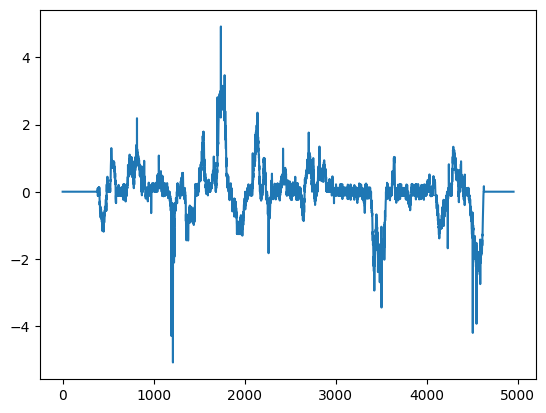

VVV 0.3029599894936305


In [1]:
import numpy as np

# Load the npz file
filePathE1 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Encoders20.npz"
data = np.load(filePathE1)


#counts for differnet wheels 
encoder_counts = data['counts']
FR = encoder_counts[0]
FL = encoder_counts[1]
RR = encoder_counts[2]
RL = encoder_counts[3]

L = (0.47625+0.31115)/2 #in meters
travel_per_tic = 0.0022

encoder_time_stamps = data['time_stamps']
#print(encoder_time_stamps.shape)
#print(encoder_time_stamps)

v_r = []
v_l = []
encoder_angular_velocity = []
v = []
for i in range(len(encoder_time_stamps)):
    tau = encoder_time_stamps[i]-encoder_time_stamps[i-1]
    d_r_i = ((FR[i]+RR[i])/2)*travel_per_tic
    v_r_i = d_r_i/tau
    v_r.append(v_r_i)
    d_l_i = ((FL[i]+RL[i])/2)*travel_per_tic
    v_l_i = d_l_i/tau
    v_l.append(v_l_i)
    omega_i = (v_r_i-v_l_i)/L
    encoder_angular_velocity.append(omega_i)
    v_i = (v_r_i+v_l_i)/2
    v.append(v_i)

import matplotlib.pyplot as plt
plt.plot(encoder_angular_velocity)
plt.show()

print("VVV",v[500])




In [2]:
# Load the npz file
filePathIMU20 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Imu20.npz"
data = np.load(filePathIMU20)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
print(data['angular_velocity'].shape)
yaw = data['angular_velocity'][2]
print(yaw)
imu_time_stamps = data['time_stamps']


#syncronize IMu with encoder
yaw_sync = []
for i in range(len(encoder_time_stamps)):
    e_time_stamp = encoder_time_stamps[i]
    l_diff = 10
    corr_time_stamp_index = 0
    for j in range(len(imu_time_stamps)):
        i_time_stamp = imu_time_stamps[j]
        diff = abs(e_time_stamp-i_time_stamp)
        if diff<l_diff:
            #print("gg")
            l_diff = diff
            #print(diff)
            corr_time_stamp_index = j
    corr_imu_val = yaw[corr_time_stamp_index]
    yaw_sync.append(corr_imu_val)




Keys in the npz file:
['angular_velocity', 'linear_acceleration', 'time_stamps']
[array([[ 0.00658551,  0.00424913,  0.00279578, ..., -0.00227567,
        -0.00624112, -0.01028513],
       [-0.00578402, -0.00286166, -0.00025825, ..., -0.00183984,
        -0.00542604, -0.00655069],
       [ 0.00490467,  0.00208956, -0.00030337, ...,  0.00427145,
         0.00483386,  0.00511853]]), array([[ 6.24603149e-04,  8.68602488e-05, -4.14567382e-04, ...,
        -1.28033057e-02, -1.27858161e-02, -1.27722843e-02],
       [-1.61259512e-02, -1.61229602e-02, -1.61197752e-02, ...,
        -1.41738861e-02, -1.42381361e-02, -1.43159987e-02],
       [ 1.02199933e+00,  1.02154318e+00,  1.02111573e+00, ...,
         1.01423169e+00,  1.01437542e+00,  1.01450887e+00]]), array([1.29844527e+09, 1.29844527e+09, 1.29844527e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])]
(3, 12187)
[ 0.00490467  0.00208956 -0.00030337 ...  0.00427145  0.00483386
  0.00511853]


In [3]:
e_ind = []
for i in range(len(encoder_time_stamps)):
    e_ind_i = [encoder_time_stamps[i],"e",i]
    e_ind.append(e_ind_i)
print(len(e_ind))
imu_ind = []
for i in range(len(imu_time_stamps)):
    imu_ind_i = [imu_time_stamps[i],"imu",i]
    imu_ind.append(imu_ind_i)
print(len(imu_ind))
all_time_stamps_with_indicies = e_ind + imu_ind
sorted_time_stamps = sorted(all_time_stamps_with_indicies, key = lambda x: x[0])
#print(sorted_time_stamps)

imu_sync = []
for i in range(len(encoder_time_stamps)):
    e_time_stamp = encoder_time_stamps[i]
    
    for j in range(len(sorted_time_stamps)):
        if sorted_time_stamps[j][0] == e_time_stamp and sorted_time_stamps[j][1] == "e":
            sorted_index = j
    for t in range(sorted_index,len(sorted_time_stamps)):
        if sorted_time_stamps[t][1] == "imu":
            ind = sorted_time_stamps[t][2]
            imu_val = yaw[ind]
            imu_sync.append(imu_val)
            break
    if len(imu_sync) < i:##to get same length on imu_sync as encoder
        imu_sync.append(0)
imu_sync.append(0) ##to get same length on imu_sync as encoder

print(len(imu_sync))


4956
12187
4956


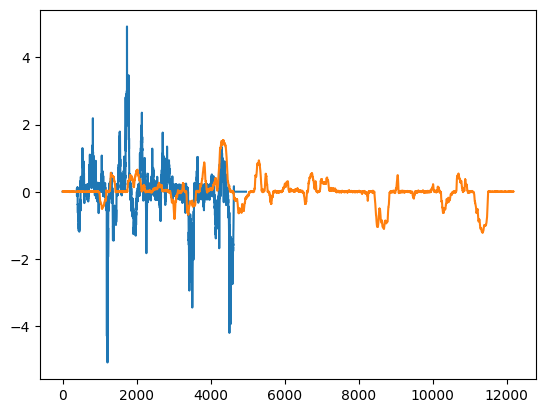

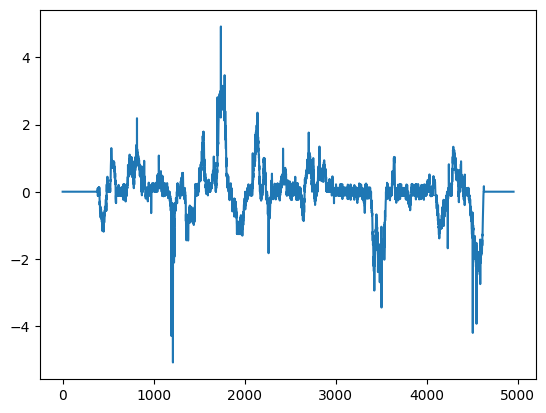

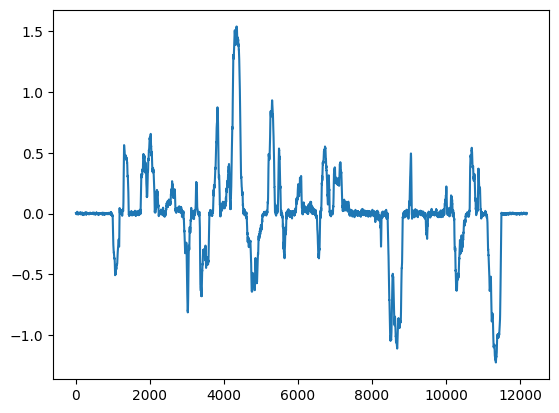

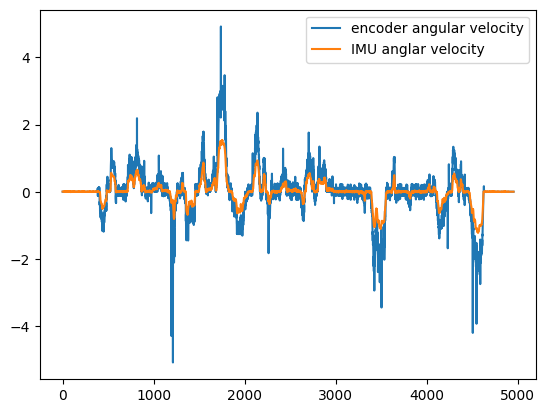

In [4]:
import matplotlib.pyplot as plt
plt.plot(encoder_angular_velocity)
plt.plot(yaw)
plt.show()
plt.plot(encoder_angular_velocity)
plt.show()
plt.plot(yaw)
plt.show()
plt.plot(encoder_angular_velocity)
plt.plot(imu_sync)
plt.legend(["encoder angular velocity", "IMU anglar velocity"])
plt.show()
#print(yaw_sync)

In [5]:
from scipy.integrate import quad
#Differentila-drive kinematic Model
x_0 = np.array([0,0,0])
x = []
x.append(x_0)
for t in range(1,len(encoder_time_stamps)):
    tau = encoder_time_stamps[t]-encoder_time_stamps[t-1]
    omega = imu_sync[t-1]
    #theta = quad(omega,0,tau)
    #theta = omega*tau #simple integratino of angular velocity to find thea 
    theta = x[t-1][2]
    x_t = x[t-1]+ tau*np.array([v[t-1]*np.cos(theta),v[t-1]*np.sin(theta),omega])
    x.append(x_t)
print(len(x))
#print(x)

# Initialize empty lists for each element position
x_only = []
y_only = []
theta_only = []

# Iterate over the list of arrays and append each element to the appropriate list
x_pose = x

for array in x:
    x_only.append(array[0])
    y_only.append(array[1])
    theta_only.append(array[2])
    

4956


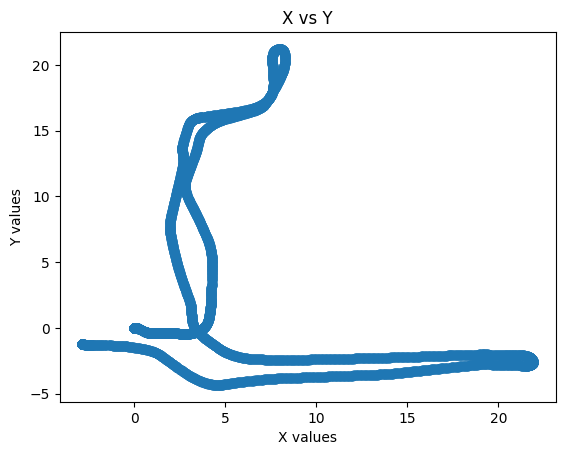

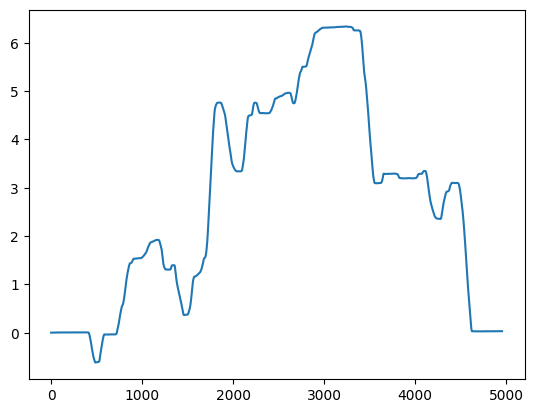

In [6]:
import matplotlib.pyplot as plt

#print(y_only)

# Create a scatter plot of the x and y values
plt.scatter(x_only, y_only)

# Set the x and y axis labels
plt.xlabel("X values")
plt.ylabel("Y values")

# Set the title of the plot
plt.title("X vs Y")

# Show the plot
plt.show()

plt.plot(theta_only)
plt.show()


In [7]:
import numpy as np

# Load the npz file
filePathE2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Encoders21.npz"
data = np.load(filePathE2)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
print(data['counts'].shape)


Keys in the npz file:
['counts', 'time_stamps']
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16), array([1.29888199e+09, 1.29888200e+09, 1.29888200e+09, ...,
       1.29888211e+09, 1.29888211e+09, 1.29888211e+09])]
(4, 4789)


In [8]:




# Load the npz file
filePathH2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Hokuyo20.npz"
data = np.load(filePathH2)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
#print(data['counts'].shape)

lidar_time_stamps = data['time_stamps']
print(lidar_time_stamps.shape)
print(data['ranges'].shape)
print(data['angle_increment'])
initial_scan_ranges = data['ranges'][:,0]
print(initial_scan_ranges.shape)
angle_increment = data['angle_increment'][0][0]
print("inc,",angle_increment)
angle_min = data['angle_min']
angle_max = data['angle_max']
lidar_ranges = data['ranges']

total_angle =  (3/2)*np.pi

angles = np.linspace(angle_min,angle_max,num=1081)

ranges = data['ranges']
print(ranges.shape)


Keys in the npz file:
['angle_min', 'angle_max', 'angle_increment', 'range_min', 'range_max', 'ranges', 'time_stamps']
[array(-2.35619449), array(2.35619449), array([[0.00436332]]), array(0.1), array(30), array([[3.375     , 3.38899994, 3.39400005, ..., 3.01300001, 3.02900004,
        3.02999997],
       [3.375     , 3.39299989, 3.39899993, ..., 3.06500006, 3.06200004,
        3.06900001],
       [3.38199997, 3.41700006, 3.39899993, ..., 3.079     , 3.08299994,
        3.07800007],
       ...,
       [4.90999985, 4.92399979, 4.91900015, ..., 1.83399999, 1.824     ,
        1.84099996],
       [4.90999985, 4.92399979, 4.91900015, ..., 1.829     , 1.81299996,
        1.82200003],
       [4.90999985, 4.92399979, 4.91900015, ..., 1.829     , 1.81299996,
        1.80700004]]), array([1.29844527e+09, 1.29844527e+09, 1.29844527e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])]
(4962,)
(1081, 4962)
[[0.00436332]]
(1081,)
inc, 0.004363323129985824
(1081, 4962)


In [9]:
#think this is worng 
import pr2_utils as utils

MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  20
MAP['ymax']  =  20 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64) #DATA TYPE: char or int8

#remove measurments outside range(0.1,30)
indValid = np.logical_and((initial_scan_ranges < 30),(initial_scan_ranges> 0.1))
initial_scan_ranges = initial_scan_ranges[indValid]
angles = angles[indValid]

#start points of lidar ray in lidar frame
sx = np.ceil((x_only[0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
sy = np.ceil((y_only[0] - MAP['ymin']) / MAP['res']).astype(np.int16)-1

#end points of lidar ray in lidar frame 
ex = initial_scan_ranges*np.cos(angles)
ey = initial_scan_ranges*np.sin(angles)
print(ex.shape)

x_length_from_lidar_to_body_center = 0.29833/2
z_length_from_lidar_to_body_center = 0.51435

rTl1 = np.array([[1,0,0,-x_length_from_lidar_to_body_center],
               [0,1,0,0],
               [0,0,1,-z_length_from_lidar_to_body_center],
               [0,0,0,1]])

rTl = np.array([[1,0,-x_length_from_lidar_to_body_center],
                [0,1,0],
                [0,0,1]])
#print(rTl)

#exyz = np.ones((4,np.size(ex))) #np.zeros?
#exyz[0, :] = ex
#exyz[1,:] = ey
#print(exyz.shape)

exy = np.ones((3,np.size(ex))) #np.zeros?
exy[0, :] = ex
exy[1,:] = ey

#transform to body frame
exyz = np.dot(rTl,exy)
#print(exyz.shape)

def worldTbody1(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),0,x],
                    [np.sin(theta),np.cos(theta),0,y],
                    [0,0,1,0],
                    [0,0,0,1]])
    return wTb

def worldTbody(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                    [np.sin(theta),np.cos(theta),y],
                    [0,0,1]])
    return wTb
    

wTb1 = worldTbody(x[0][0],x[0][1],x[0][2])
#print(wTb0)

#transform to world frame
#exyz_w = np.dot(wTb0,exyz)
exy_w = np.dot(wTb1,exy)
print(exy_w.shape)







(1078,)
(3, 1078)


In [10]:
import pr2_utils as utils

MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  20
MAP['ymax']  =  20 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64) #DATA TYPE: char or int8

#remove measurments outside range(0.1,30)
indValid = np.logical_and((initial_scan_ranges < 30),(initial_scan_ranges> 0.1))
initial_scan_ranges = initial_scan_ranges[indValid]
angles = angles[indValid]

#start points of lidar ray in lidar frame
sx = np.ceil((x_only[0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
sy = np.ceil((y_only[0] - MAP['ymin']) / MAP['res']).astype(np.int16)-1

#end points of lidar ray in lidar frame 
ex = initial_scan_ranges*np.cos(angles)
ey = initial_scan_ranges*np.sin(angles)
print(ex.shape)

x_length_from_lidar_to_body_center = 0.29833/2
z_length_from_lidar_to_body_center = 0.51435

rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                [0,1,0],
                [0,0,1]])
#print(rTl)

exy = np.zeros((3,np.size(ex))) #np.zeros?
exy[0, :] = ex
exy[1,:] = ey

#transform to body frame
exy = np.dot(rTl,exy)

def worldTbody(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                    [np.sin(theta),np.cos(theta),y],
                    [0,0,1]])
    return wTb
    

wTb0 = worldTbody(x[0][0],x[0][1],x[0][2])
#print(wTb0)

#transform to world frame
#exyz_w = np.dot(wTb0,exyz)
exy_w = np.dot(wTb0,exy)
print(exy_w.shape)







(1078,)
(3, 1078)


In [11]:
print(exy_w)

[[-2.38648539 -2.3760497  -2.37047511 ... -3.44146438 -3.45671219
  -3.47189419]
 [-2.38648539 -2.39687564 -2.412213   ...  3.5020596   3.48701009
   3.47189419]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


(1078,)
(1078,)
ind [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
de [-1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436]
ind [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tr

/var/folders/pd/j077h3nd74d5kqhjn0jk727m0000gn/T/ipykernel_3313/2543200298.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Text(0.5, 1.0, 'Occupancy grid map')

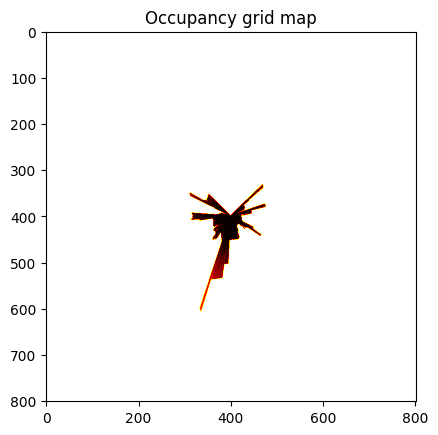

In [12]:
#convert end points to cells 
ex = exy_w[0, :] 
ey  = exy_w[1,:]
print(ey.shape)
ex = np.ceil((ex - MAP['xmin']) / MAP['res']).astype(np.int16)-1
ey = np.ceil((ey - MAP['ymin']) / MAP['res']).astype(np.int16)-1
print(ey.shape)

for i in range(np.size(initial_scan_ranges)):
    bresenham_points = utils.bresenham2D(sx, sy, ex[i], ey[i])
    #print(bresenham_points)
    bresenham_points_x = bresenham_points[0, :].astype(np.int16)
    bresenham_points_y = bresenham_points[1, :].astype(np.int16)
    #print(bresenham_points_x.shape)
    #print(bresenham_points_y.shape)

    indGood = np.logical_and(
        np.logical_and(np.logical_and((bresenham_points_x > 1), (bresenham_points_y > 1)), (bresenham_points_x < MAP['sizex'])), (bresenham_points_y < MAP['sizey']))
    print("ind",indGood)
    # Decrease log-odds if cell is free
    MAP['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]] -= np.log(4)
   #print("bresh", bresenham_points_x[indGood] )
    print("de", MAP['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]])

    # Increase log-odds if cell is occupied
    if ((ex[i] > 1) and (ex[i] < MAP['sizex']) and (ey[i] > 1) and (ey[i] < MAP['sizey'])):
        MAP['map'][ex[i], ey[i]] += np.log(4)
        #print("ex", ex[i], "ey", ey[i])
        #print("inc", MAP['map'][ex[i], ey[i]].shape)

    # clip range to prevent over-confidence
#MAP['map'] = np.clip(MAP['map'], -10*np.log(4), 10*np.log(4))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print(MAP['map'])
fig2 = plt.figure()
plt.imshow(sigmoid(MAP['map']), cmap = 'hot');
plt.title("Occupancy grid map")

(801, 801)
(801,)


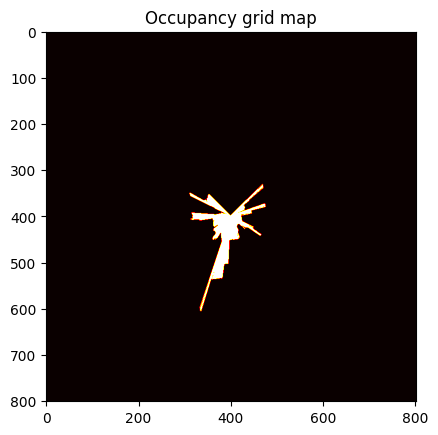

In [13]:
OMAP = {}
OMAP['res']   = 0.05 #meters
OMAP['xmin']  = -20  #meters
OMAP['ymin']  = -20
OMAP['xmax']  =  20
OMAP['ymax']  =  20 
OMAP['sizex']  = int(np.ceil((OMAP['xmax'] - OMAP['xmin']) / OMAP['res'] + 1)) #cells
OMAP['sizey']  = int(np.ceil((OMAP['ymax'] - OMAP['ymin']) / OMAP['res'] + 1))
OMAP['map'] = np.zeros((OMAP['sizex'],OMAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8

print(OMAP['map'].shape)
print(MAP['map'][0].shape)
for x in range(MAP['map'].shape[0]):
    for y in range(MAP['map'].shape[1]):
        #print("map_val",MAP['map'][x,y])
        if MAP['map'][x,y] < 0:
            OMAP['map'][x,y] = 1
            
        else:
            #print("gg")
            OMAP['map'][x,y] = 0

fig3 = plt.figure()
plt.imshow(OMAP['map'],cmap="hot");
plt.title("Occupancy grid map")


def update_omap(OMAP,MAP):
    for x in range(MAP['map'].shape[0]):
        for y in range(MAP['map'].shape[1]):
        #print("map_val",MAP['map'][x,y])
            if MAP['map'][x,y] < 0:
                OMAP['map'][x,y] = 1
            
            else:
            #print("gg")
                OMAP['map'][x,y] = 0
    return OMAP


In [14]:

angles = np.linspace(angle_min, angle_max, num=1081)
def update_map(MAP, pose, ranges, angles):
    map = MAP.copy()
    #remove measurments outside range(0.1,30)
    indValid = np.logical_and((ranges < 30), (ranges > 0.1))
    ranges =ranges[indValid]
    angles = angles[indValid]
    x = pose[0]
    y = pose[1]
    thet = pose[2]

    x_length_from_lidar_to_body_center = 0.29833 / 2

    rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                    [0,1,0],
                    [0,0,1]])
    
    lTr = np.array([[1,0,-x_length_from_lidar_to_body_center],
                   [0,1,0],
                   [0,0,1]])
    
    #def bodyTworld(x,y,theta):
       # bTw = np.array([[np.cos(theta),np.sin(theta),-np.cos(theta)*x-np.sin(theta)*y],
                        #[-np.sin(theta),np.cos(theta),np.sin(theta)*x-np.cos(theta)*y],
                        #[0,0,1]])
        #return bTw
    
    #bTw0 = bodyTworld(x,y,thet)
    
    #wxy = np.array([x,y,thet])
    #bxy = np.dot(bTw0,wxy)
    #lxy = np.dot(lTr,bxy)
    #lxy = np.dot(lTr,wxy)
    #lx = lxy[0]
    #ly = lxy[1]

    

    #start points of lidar ray in lidar frame
    sxu = np.ceil((x - map['xmin']) / map['res']).astype(np.int16)-1
    syu = np.ceil((y - map['ymin']) / map['res']).astype(np.int16)-1
    #sxu = np.ceil((lx - map['xmin']) / map['res']).astype(np.int16)-1
    #syu = np.ceil((ly - map['ymin']) / map['res']).astype(np.int16)-1

    #end points of lidar ray in lidar frame 
    exu =ranges*np.cos(angles)
    eyu =ranges*np.sin(angles)
    #print(ex.shape)

    
    #print(rTl)

    exyu = np.zeros((3,np.size(exu))) #np.zeros?
    exyu[0, :] = exu
    exyu[1,:] = eyu

    #transform to body frame
    exyu = np.dot(rTl,exyu)

    def worldTbody(x,y,theta):
        wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                        [np.sin(theta),np.cos(theta),y],
                        [0,0,1]])
        return wTb
        

    wTb0 = worldTbody(x,y,thet)
    #print(wTb0)

    #transform to world frame
    #exyz_w = np.dot(wTb0,exyz)
    exyu_w = np.dot(wTb0,exyu)
    #print(exy_w.shape)

    #convert end points to cells 
    exu = exyu_w[0, :] 
    eyu  = exyu_w[1,:]
    #print(ey.shape)
    exu = np.ceil((exu - map['xmin']) / map['res']).astype(np.int16)-1
    eyu = np.ceil((eyu - map['ymin']) / map['res']).astype(np.int16)-1
    #print(ey.shape)

    
    for i in range(np.size(ranges)):
        bresenham_points = utils.bresenham2D(sxu, syu, exu[i], eyu[i])
        bresenham_points_x = bresenham_points[0, :].astype(np.int16)
        bresenham_points_y = bresenham_points[1, :].astype(np.int16)
    

        indGood = np.logical_and(
            np.logical_and(np.logical_and((bresenham_points_x > 1), (bresenham_points_y > 1)), (bresenham_points_x < map['sizex'])), (bresenham_points_y < map['sizey']))
        # Decrease log-odds if cell is free
        map['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]] -= np.log(4)
        #print("de", map['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]])

    # Increase log-odds if cell is occupied
    if ((exu[i] > 1) and (exu[i] < map['sizex']) and (eyu[i] > 1) and (eyu[i] < map['sizey'])):
        map['map'][exu[i], eyu[i]] += np.log(4)
        #print("ex", ex[i], "ey", ey[i])
        #print("inc", MAP['map'][ex[i], ey[i]].shape)

    # clip range to prevent over-confidence
    map['map'] = np.clip(map['map'], -10*np.log(4), 10*np.log(4))
    return map

In [15]:
# Load the npz file
filePathH2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Hokuyo20.npz"
data = np.load(filePathH2)
print(data['ranges'].shape)

(1081, 4962)


In [47]:
from tqdm import tqdm

angles = np.linspace(angle_min, angle_max, num=1081)
print(angles.shape)
print(len(x_pose))

MAP1 = MAP.copy()

for index,pose in tqdm(enumerate(x_pose)):
    #print(pose)
    ranges =  data['ranges'][:, index]
    MAP1 = update_map(MAP1,pose,ranges,angles)
    #OMAP = update_omap(OMAP,MAP1)
    #print("iteration:", index)

print(MAP['map'])
fig2 = plt.figure()
plt.imshow(sigmoid(MAP1['map']), cmap = 'hot');
plt.title("Occupancy grid map")

    

(1081,)
4956


237it [00:28,  8.43it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Occupancy grid map')

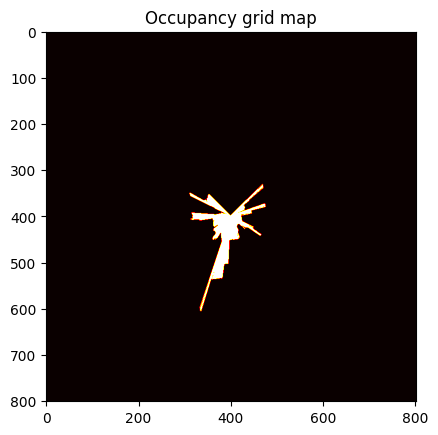

In [17]:
fig3 = plt.figure()
plt.imshow(OMAP['map'],cmap="hot");
plt.title("Occupancy grid map")

In [18]:
def init_particles(N):
  particle_state = np.zeros((3,N))
  particle_weight = np.zeros((1,N))
  particle_weight[0, 0:N] = 1 / N
  return particle_state,particle_weight


def prediction(particle_state, tau, v_t, w_t):
    N = np.shape(particle_state)[1]
    state = particle_state
    x_w = particle_state[0,:]
    y_w = particle_state[1,:]
    #print(y_w)
    theta_w = state[2,:]
    delta_x = tau * v_t * np.cos(theta_w)
    delta_y = tau * v_t * np.sin(theta_w)
    #print(delta_y)
    x_w += delta_x
    y_w += delta_y
    theta_w += tau * w_t
    #print("X_W",x_w)

    # Add noise 
    noise_x = np.random.normal(0, abs(np.max(delta_x)) / 10, N)
    noise_y = np.random.normal(0, abs(np.max(delta_y)) / 10, N)
    noise_theta = np.random.normal(0, abs(tau*w_t)/10, N)

    state[0, :] = x_w + noise_x
    state[1, :] = y_w + noise_y
    state[2, :] = theta_w + noise_theta
    print("p", state[0, 0])
    return state

In [19]:

state_list = np.zeros([4956, 3, 10])

N = 10

state_0, weights = init_particles(N)
#print("=",state_0)
state_list[0] = state_0
#print(state_list)
#print(np.shape(state_list)[0])
for t in range(1,len(encoder_time_stamps)):
    tau = encoder_time_stamps[t] - encoder_time_stamps[t-1]
    w = imu_sync[t-1]
    #print(state_list[t])
    state_t = prediction(state_list[t-1].copy(), tau, v[t-1], w)
    #print("state", state_t)
    state_list[t] = state_t
#print("state_t",state_t)
#print("state_list",state_list[0])
#print("state_list",state_list[4000])
#print("len,",len(state_list))
#print(state_list)
    

p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.

In [20]:
for t in range(state_list.shape[0]):
    print(state_list[t, 0, 0])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [21]:
state_list.T.shape

(10, 3, 4956)

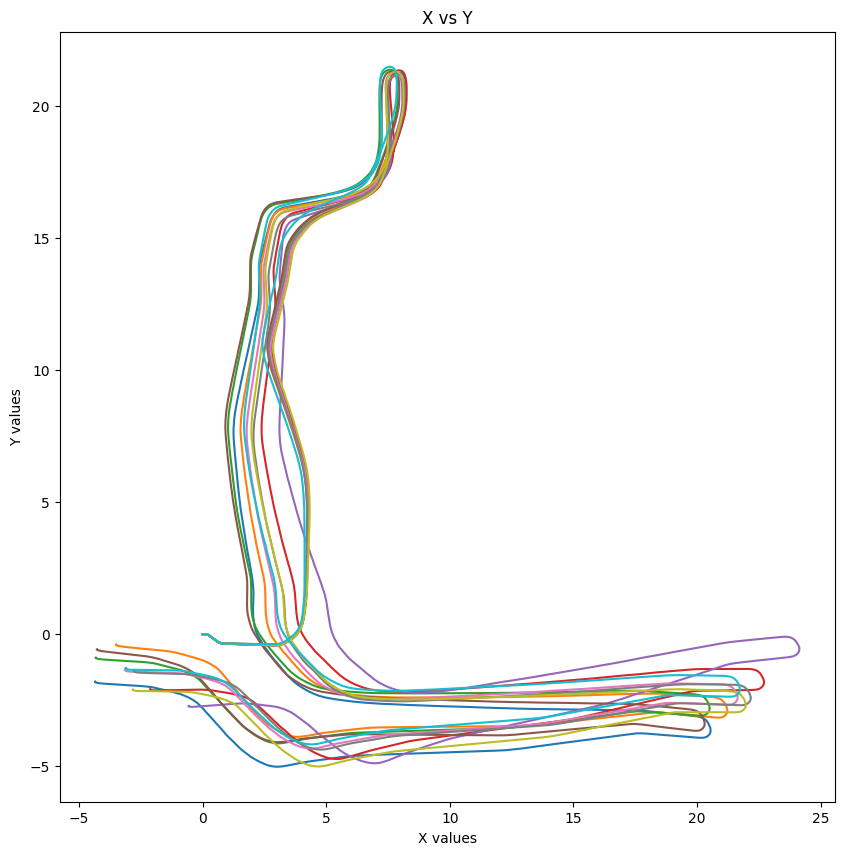

In [22]:
plt.subplots(1, 1, figsize=(10, 10))
plt.xlabel("X values")
plt.ylabel("Y values")

# Set the title of the plot
plt.title("X vs Y")
for p in range(state_list.shape[2]):
    plt.plot(state_list[:, 0, p], state_list[:, 1, p])

In [38]:
from pr2_utils import mapCorrelation

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return e_x / np.sum(e_x)


def update(MAP, particle_state, particle_weight, ranges, angles, N):

    # Binary map for map correlation
    #map1 = update_omap(OMAP,MAP)
    #map = map1['map']
    map = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.5).astype(np.int)

    x_im = np.arange(MAP['xmin'], MAP['xmax'] + MAP['res'], MAP['res'])  # x index of each pixel on log-odds map
    y_im = np.arange(MAP['ymin'], MAP['ymax'] + MAP['res'], MAP['res'])  # y index of each pixel on log-odds map

    # Grid around particle
    x_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # x deviation
    y_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # y deviation

    


    rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                    [0,1,0],
                    [0,0,1]])
    
   
    

    #end points of lidar ray in lidar frame 
    exu =ranges*np.cos(angles)
    eyu =ranges*np.sin(angles)
    #print(ex.shape)


    exyu = np.zeros((3,np.size(exu))) #np.zeros?
    exyu[0, :] = exu
    exyu[1,:] = eyu

    #transform to body frame
    exyu = np.dot(rTl,exyu)

    correlation = np.zeros(N)
    

    for i in range(N):
        
        x_t = particle_state[:, i]
        x_w = x_t[0]
        y_w = x_t[1]
        theta_w = x_t[2]

        # Transform to world frame
        wTb0 = worldTbody(x_w,y_w,theta_w)
  

    
        s_w = np.dot(wTb0,exyu)
        ex_w = s_w[0, :]
        ey_w = s_w[1, :]
        Y = np.stack((ex_w, ey_w))

        c = mapCorrelation(map, x_im, y_im, Y, x_range, y_range)

        correlation[i] = np.max(c)

    # Update particle weight with softmax
    p_h = softmax(correlation)
    particle_weight *= p_h / np.sum(particle_weight * p_h)
    return particle_state, particle_weight



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/4955 [00:00<?, ?it/s]/var/folders/pd/j077h3nd74d5kqhjn0jk727m0000gn/T/ipykernel_3313/897778223.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.5).astype(np.int)
  0%|          | 2/4955 [00:00<11:35,  7.12it/s]

p 0.0
p 0.0


  0%|          | 4/4955 [00:00<11:37,  7.09it/s]

p 0.0
p 0.0


  0%|          | 6/4955 [00:00<11:50,  6.97it/s]

p 0.0
p 0.0


  0%|          | 7/4955 [00:00<11:52,  6.95it/s]

p 0.0
p 0.0


  0%|          | 10/4955 [00:01<11:48,  6.98it/s]

p 0.0
p 0.0


  0%|          | 12/4955 [00:01<11:51,  6.94it/s]

p 0.0
p 0.0


  0%|          | 14/4955 [00:02<11:51,  6.94it/s]

p 0.0
p 0.0


  0%|          | 16/4955 [00:02<11:44,  7.01it/s]

p 0.0
p 0.0


  0%|          | 18/4955 [00:02<11:40,  7.04it/s]

p 0.0
p 0.0


  0%|          | 20/4955 [00:02<11:41,  7.04it/s]

p 0.0
p 0.0


  0%|          | 22/4955 [00:03<11:46,  6.99it/s]

p 0.0
p 0.0


  0%|          | 24/4955 [00:03<11:44,  7.00it/s]

p 0.0
p 0.0


  1%|          | 26/4955 [00:03<11:43,  7.01it/s]

p 0.0
p 0.0


  1%|          | 28/4955 [00:04<11:43,  7.00it/s]

p 0.0
p 0.0


  1%|          | 30/4955 [00:04<11:51,  6.92it/s]

p 0.0
p 0.0


  1%|          | 32/4955 [00:04<11:50,  6.93it/s]

p 0.0
p 0.0


  1%|          | 34/4955 [00:04<11:50,  6.92it/s]

p 0.0
p 0.0


  1%|          | 36/4955 [00:05<11:54,  6.89it/s]

p 0.0
p 0.0


  1%|          | 38/4955 [00:05<11:46,  6.96it/s]

p 0.0
p 0.0


  1%|          | 40/4955 [00:05<11:46,  6.96it/s]

p 0.0
p 0.0


  1%|          | 42/4955 [00:06<11:48,  6.93it/s]

p 0.0
p 0.0


  1%|          | 44/4955 [00:06<11:44,  6.97it/s]

p 0.0
p 0.0


  1%|          | 46/4955 [00:06<11:48,  6.93it/s]

p 0.0
p 0.0


  1%|          | 48/4955 [00:06<11:45,  6.96it/s]

p 0.0
p 0.0


  1%|          | 50/4955 [00:07<11:41,  7.00it/s]

p 0.0
p 0.0


  1%|          | 52/4955 [00:07<11:45,  6.95it/s]

p 0.0
p 0.0


  1%|          | 54/4955 [00:07<11:37,  7.02it/s]

p 0.0
p 0.0


  1%|          | 56/4955 [00:08<11:41,  6.98it/s]

p 0.0
p 0.0


  1%|          | 58/4955 [00:08<11:43,  6.96it/s]

p 0.0
p 0.0


  1%|          | 60/4955 [00:08<11:41,  6.98it/s]

p 0.0
p 0.0


  1%|▏         | 62/4955 [00:08<11:44,  6.94it/s]

p 0.0
p 0.0


  1%|▏         | 64/4955 [00:09<11:47,  6.91it/s]

p 0.0
p 0.0


  1%|▏         | 66/4955 [00:09<11:38,  7.00it/s]

p 0.0
p 0.0


  1%|▏         | 68/4955 [00:09<11:31,  7.07it/s]

p 0.0
p 0.0


  1%|▏         | 70/4955 [00:10<11:42,  6.95it/s]

p 0.0
p 0.0


  1%|▏         | 72/4955 [00:10<11:46,  6.91it/s]

p 0.0
p 0.0


  1%|▏         | 74/4955 [00:10<11:52,  6.85it/s]

p 0.0
p 0.0


  2%|▏         | 76/4955 [00:10<11:44,  6.92it/s]

p 0.0
p 0.0


  2%|▏         | 78/4955 [00:11<11:35,  7.01it/s]

p 0.0
p 0.0


  2%|▏         | 80/4955 [00:11<11:27,  7.09it/s]

p 0.0
p 0.0


  2%|▏         | 82/4955 [00:11<11:32,  7.03it/s]

p 0.0
p 0.0


  2%|▏         | 84/4955 [00:12<11:29,  7.06it/s]

p 0.0
p 0.0


  2%|▏         | 86/4955 [00:12<11:26,  7.09it/s]

p 0.0
p 0.0


  2%|▏         | 88/4955 [00:12<11:28,  7.07it/s]

p 0.0
p 0.0


  2%|▏         | 90/4955 [00:12<11:28,  7.07it/s]

p 0.0
p 0.0


  2%|▏         | 92/4955 [00:13<11:27,  7.07it/s]

p 0.0
p 0.0


  2%|▏         | 94/4955 [00:13<11:36,  6.98it/s]

p 0.0
p 0.0


  2%|▏         | 96/4955 [00:13<11:28,  7.06it/s]

p 0.0
p 0.0


  2%|▏         | 98/4955 [00:14<11:26,  7.08it/s]

p 0.0
p 0.0


  2%|▏         | 100/4955 [00:14<11:23,  7.10it/s]

p 0.0
p 0.0


  2%|▏         | 102/4955 [00:14<11:26,  7.07it/s]

p 0.0
p 0.0


  2%|▏         | 104/4955 [00:14<11:24,  7.08it/s]

p 0.0
p 0.0


  2%|▏         | 106/4955 [00:15<11:25,  7.08it/s]

p 0.0
p 0.0


  2%|▏         | 108/4955 [00:15<11:21,  7.11it/s]

p 0.0
p 0.0


  2%|▏         | 110/4955 [00:15<11:24,  7.08it/s]

p 0.0
p 0.0


  2%|▏         | 112/4955 [00:16<11:25,  7.07it/s]

p 0.0
p 0.0


  2%|▏         | 114/4955 [00:16<11:19,  7.13it/s]

p 0.0
p 0.0


  2%|▏         | 116/4955 [00:16<11:20,  7.12it/s]

p 0.0
p 0.0


  2%|▏         | 118/4955 [00:16<11:18,  7.13it/s]

p 0.0
p 0.0


  2%|▏         | 120/4955 [00:17<11:19,  7.11it/s]

p 0.0
p 0.0


  2%|▏         | 122/4955 [00:17<11:26,  7.04it/s]

p 0.0
p 0.0


  3%|▎         | 124/4955 [00:17<11:28,  7.02it/s]

p 0.0
p 0.0


  3%|▎         | 126/4955 [00:17<11:29,  7.00it/s]

p 0.0
p 0.0


  3%|▎         | 128/4955 [00:18<11:28,  7.01it/s]

p 0.0
p 0.0


  3%|▎         | 130/4955 [00:18<11:27,  7.01it/s]

p 0.0
p 0.0


  3%|▎         | 132/4955 [00:18<11:28,  7.01it/s]

p 0.0
p 0.0


  3%|▎         | 134/4955 [00:19<11:23,  7.05it/s]

p 0.0
p 0.0


  3%|▎         | 136/4955 [00:19<11:19,  7.09it/s]

p 0.0
p 0.0


  3%|▎         | 138/4955 [00:19<11:20,  7.08it/s]

p 0.0
p 0.0


  3%|▎         | 140/4955 [00:19<11:16,  7.11it/s]

p 0.0
p 0.0


  3%|▎         | 142/4955 [00:20<11:11,  7.16it/s]

p 0.0
p 0.0


  3%|▎         | 144/4955 [00:20<11:19,  7.08it/s]

p 0.0
p 0.0


  3%|▎         | 146/4955 [00:20<11:16,  7.11it/s]

p 0.0
p 0.0


  3%|▎         | 148/4955 [00:21<11:16,  7.11it/s]

p 0.0
p 0.0


  3%|▎         | 150/4955 [00:21<11:15,  7.11it/s]

p 0.0
p 0.0


  3%|▎         | 152/4955 [00:21<11:14,  7.12it/s]

p 0.0
p 0.0


  3%|▎         | 154/4955 [00:21<11:12,  7.13it/s]

p 0.0
p 0.0


  3%|▎         | 156/4955 [00:22<11:09,  7.17it/s]

p 0.0
p 0.0


  3%|▎         | 158/4955 [00:22<11:09,  7.16it/s]

p 0.0
p 0.0


  3%|▎         | 160/4955 [00:22<11:12,  7.13it/s]

p 0.0
p 0.0


  3%|▎         | 162/4955 [00:23<11:13,  7.11it/s]

p 0.0
p 0.0


  3%|▎         | 164/4955 [00:23<11:10,  7.14it/s]

p 0.0
p 0.0


  3%|▎         | 166/4955 [00:23<11:10,  7.15it/s]

p 0.0
p 0.0


  3%|▎         | 168/4955 [00:23<11:08,  7.16it/s]

p 0.0
p 0.0


  3%|▎         | 170/4955 [00:24<11:12,  7.12it/s]

p 0.0
p 0.0


  3%|▎         | 172/4955 [00:24<11:13,  7.10it/s]

p 0.0
p 0.0


  4%|▎         | 174/4955 [00:24<11:12,  7.11it/s]

p 0.0
p 0.0


  4%|▎         | 176/4955 [00:25<11:11,  7.12it/s]

p 0.0
p 0.0


  4%|▎         | 178/4955 [00:25<11:10,  7.13it/s]

p 0.0
p 0.0


  4%|▎         | 180/4955 [00:25<11:09,  7.13it/s]

p 0.0
p 0.0


  4%|▎         | 182/4955 [00:25<11:10,  7.12it/s]

p 0.0
p 0.0


  4%|▎         | 184/4955 [00:26<11:06,  7.15it/s]

p 0.0
p 0.0


  4%|▍         | 186/4955 [00:26<11:06,  7.15it/s]

p 0.0
p 0.0


  4%|▍         | 188/4955 [00:26<11:04,  7.18it/s]

p 0.0
p 0.0


  4%|▍         | 190/4955 [00:26<11:03,  7.18it/s]

p 0.0
p 0.0


  4%|▍         | 192/4955 [00:27<11:03,  7.18it/s]

p 0.0
p 0.0


  4%|▍         | 194/4955 [00:27<11:12,  7.08it/s]

p 0.0
p 0.0


  4%|▍         | 196/4955 [00:27<11:08,  7.12it/s]

p 0.0
p 0.0


  4%|▍         | 198/4955 [00:28<11:06,  7.14it/s]

p 0.0
p 0.0


  4%|▍         | 200/4955 [00:28<11:03,  7.17it/s]

p 0.0
p 0.0


  4%|▍         | 202/4955 [00:28<11:03,  7.17it/s]

p 0.0
p 0.0


  4%|▍         | 204/4955 [00:28<11:06,  7.13it/s]

p 0.0
p 0.0


  4%|▍         | 206/4955 [00:29<11:05,  7.13it/s]

p 0.0
p 0.0


  4%|▍         | 208/4955 [00:29<11:05,  7.14it/s]

p 0.0
p 0.0


  4%|▍         | 210/4955 [00:29<11:01,  7.18it/s]

p 0.0
p 0.0


  4%|▍         | 212/4955 [00:30<11:02,  7.16it/s]

p 0.0
p 0.0


  4%|▍         | 214/4955 [00:30<11:02,  7.16it/s]

p 0.0
p 0.0


  4%|▍         | 216/4955 [00:30<11:01,  7.17it/s]

p 0.0
p 0.0


  4%|▍         | 218/4955 [00:30<11:03,  7.14it/s]

p 0.0
p 0.0


  4%|▍         | 220/4955 [00:31<11:07,  7.10it/s]

p 0.0
p 0.0


  4%|▍         | 222/4955 [00:31<11:04,  7.12it/s]

p 0.0
p 0.0


  5%|▍         | 224/4955 [00:31<11:03,  7.13it/s]

p 0.0
p 0.0


  5%|▍         | 226/4955 [00:32<11:03,  7.13it/s]

p 0.0
p 0.0


  5%|▍         | 228/4955 [00:32<11:03,  7.13it/s]

p 0.0
p 0.0


  5%|▍         | 230/4955 [00:32<11:02,  7.13it/s]

p 0.0
p 0.0


  5%|▍         | 232/4955 [00:32<11:00,  7.16it/s]

p 0.0
p 0.0


  5%|▍         | 234/4955 [00:33<10:58,  7.16it/s]

p 0.0
p 0.0


  5%|▍         | 236/4955 [00:33<10:59,  7.16it/s]

p 0.0
p 0.0


  5%|▍         | 238/4955 [00:33<10:59,  7.16it/s]

p 0.0
p 0.0


  5%|▍         | 240/4955 [00:33<11:00,  7.14it/s]

p 0.0
p 0.0


  5%|▍         | 242/4955 [00:34<10:55,  7.19it/s]

p 0.0
p 0.0


  5%|▍         | 244/4955 [00:34<11:05,  7.08it/s]

p 0.0
p 0.0


  5%|▍         | 246/4955 [00:34<11:03,  7.10it/s]

p 0.0
p 0.0


  5%|▌         | 248/4955 [00:35<10:55,  7.18it/s]

p 0.0
p 0.0


  5%|▌         | 250/4955 [00:35<10:57,  7.15it/s]

p 0.0
p 0.0


  5%|▌         | 252/4955 [00:35<10:56,  7.16it/s]

p 0.0
p 0.0


  5%|▌         | 254/4955 [00:35<10:56,  7.17it/s]

p 0.0
p 0.0


  5%|▌         | 256/4955 [00:36<10:57,  7.15it/s]

p 0.0
p 0.0


  5%|▌         | 258/4955 [00:36<10:53,  7.18it/s]

p 0.0
p 0.0


  5%|▌         | 260/4955 [00:36<10:54,  7.17it/s]

p 0.0
p 0.0


  5%|▌         | 262/4955 [00:37<10:56,  7.15it/s]

p 0.0
p 0.0


  5%|▌         | 264/4955 [00:37<10:56,  7.15it/s]

p 0.0
p 0.0


  5%|▌         | 266/4955 [00:37<10:54,  7.17it/s]

p 0.0
p 0.0


  5%|▌         | 268/4955 [00:37<10:54,  7.16it/s]

p 0.0
p 0.0


  5%|▌         | 270/4955 [00:38<10:54,  7.15it/s]

p 0.0
p 0.0


  5%|▌         | 272/4955 [00:38<10:51,  7.19it/s]

p 0.0
p 0.0


  6%|▌         | 274/4955 [00:38<10:50,  7.20it/s]

p 0.0
p 0.0


  6%|▌         | 276/4955 [00:39<10:50,  7.20it/s]

p 0.0
p 0.0


  6%|▌         | 278/4955 [00:39<10:50,  7.19it/s]

p 0.0
p 0.0


  6%|▌         | 280/4955 [00:39<10:50,  7.18it/s]

p 0.0
p 0.0


  6%|▌         | 282/4955 [00:39<10:49,  7.19it/s]

p 0.0
p 0.0


  6%|▌         | 284/4955 [00:40<10:50,  7.18it/s]

p 0.0
p 0.0


  6%|▌         | 286/4955 [00:40<10:50,  7.17it/s]

p 0.0
p 0.0


  6%|▌         | 288/4955 [00:40<10:51,  7.16it/s]

p 0.0
p 0.0


  6%|▌         | 290/4955 [00:40<10:49,  7.18it/s]

p 0.0
p 0.0


  6%|▌         | 292/4955 [00:41<10:52,  7.15it/s]

p 0.0
p 0.0


  6%|▌         | 294/4955 [00:41<10:54,  7.12it/s]

p 0.0
p 0.0


  6%|▌         | 296/4955 [00:41<10:55,  7.11it/s]

p 0.0
p 0.0


  6%|▌         | 298/4955 [00:42<10:52,  7.14it/s]

p 0.0
p 0.0


  6%|▌         | 300/4955 [00:42<10:52,  7.13it/s]

p 0.0
p 0.0


  6%|▌         | 302/4955 [00:42<10:50,  7.15it/s]

p 0.0
p 0.0


  6%|▌         | 304/4955 [00:42<10:51,  7.13it/s]

p 0.0
p 0.0


  6%|▌         | 306/4955 [00:43<10:51,  7.14it/s]

p 0.0
p 0.0


  6%|▌         | 308/4955 [00:43<10:50,  7.14it/s]

p 0.0
p 0.0


  6%|▋         | 310/4955 [00:43<10:48,  7.17it/s]

p 0.0
p 0.0


  6%|▋         | 312/4955 [00:44<10:48,  7.16it/s]

p 0.0
p 0.0


  6%|▋         | 314/4955 [00:44<10:50,  7.14it/s]

p 0.0
p 0.0


  6%|▋         | 316/4955 [00:44<10:58,  7.04it/s]

p 0.0
p 0.0


  6%|▋         | 318/4955 [00:44<10:54,  7.08it/s]

p 0.0
p 0.0


  6%|▋         | 320/4955 [00:45<10:51,  7.11it/s]

p 0.0
p 0.0


  6%|▋         | 322/4955 [00:45<10:49,  7.14it/s]

p 0.0
p 0.0


  7%|▋         | 324/4955 [00:45<10:46,  7.16it/s]

p 0.0
p 0.0


  7%|▋         | 326/4955 [00:46<10:46,  7.16it/s]

p 0.0
p 0.0


  7%|▋         | 328/4955 [00:46<10:46,  7.16it/s]

p 0.0
p 0.0


  7%|▋         | 330/4955 [00:46<10:48,  7.13it/s]

p 0.0
p 0.0


  7%|▋         | 332/4955 [00:46<10:48,  7.13it/s]

p 0.0
p 0.0


  7%|▋         | 334/4955 [00:47<10:48,  7.12it/s]

p 0.0
p 0.0


  7%|▋         | 336/4955 [00:47<10:47,  7.13it/s]

p 0.0
p 0.0


  7%|▋         | 338/4955 [00:47<10:48,  7.12it/s]

p 0.0
p 0.0


  7%|▋         | 340/4955 [00:47<10:48,  7.12it/s]

p 0.0
p 0.0


  7%|▋         | 342/4955 [00:48<10:52,  7.07it/s]

p 0.0
p 0.0


  7%|▋         | 344/4955 [00:48<10:49,  7.10it/s]

p 0.0
p 0.0


  7%|▋         | 346/4955 [00:48<10:47,  7.12it/s]

p 0.0
p 0.0


  7%|▋         | 348/4955 [00:49<10:53,  7.05it/s]

p 0.0
p 0.0


  7%|▋         | 350/4955 [00:49<10:57,  7.00it/s]

p 0.0
p 0.0


  7%|▋         | 352/4955 [00:49<10:57,  7.00it/s]

p 0.0
p 0.0


  7%|▋         | 354/4955 [00:49<10:50,  7.07it/s]

p 0.0
p 0.0


  7%|▋         | 356/4955 [00:50<10:47,  7.10it/s]

p 0.0
p 0.0


  7%|▋         | 358/4955 [00:50<10:45,  7.12it/s]

p 0.0
p 0.0


  7%|▋         | 360/4955 [00:50<10:46,  7.11it/s]

p 0.0
p 0.0


  7%|▋         | 362/4955 [00:51<10:47,  7.09it/s]

p 0.0
p 0.0


  7%|▋         | 364/4955 [00:51<10:46,  7.10it/s]

p 0.0
p 0.0


  7%|▋         | 366/4955 [00:51<10:55,  7.00it/s]

p 0.0
p 0.0


  7%|▋         | 368/4955 [00:51<10:54,  7.01it/s]

p 0.0
p 0.0


  7%|▋         | 370/4955 [00:52<10:48,  7.07it/s]

p 0.0
p 0.0


  8%|▊         | 372/4955 [00:52<10:45,  7.10it/s]

p 0.0
p 0.0


  8%|▊         | 374/4955 [00:52<10:49,  7.06it/s]

p 0.0
p 0.0


  8%|▊         | 376/4955 [00:53<10:49,  7.05it/s]

p 0.0
p 0.0


  8%|▊         | 378/4955 [00:53<10:48,  7.06it/s]

p 0.0
p 0.0


  8%|▊         | 380/4955 [00:53<10:50,  7.03it/s]

p 0.0
p 0.0


  8%|▊         | 382/4955 [00:53<10:50,  7.03it/s]

p 0.0
p 0.0


  8%|▊         | 384/4955 [00:54<10:47,  7.06it/s]

p 0.0
p 0.0


  8%|▊         | 386/4955 [00:54<10:44,  7.09it/s]

p 0.0
p 0.0


  8%|▊         | 388/4955 [00:54<10:52,  7.00it/s]

p 0.00045736793190619054
p 0.0012351184413727358


  8%|▊         | 390/4955 [00:55<10:46,  7.06it/s]

p 0.002344281398095613
p 0.005231368606032671


  8%|▊         | 392/4955 [00:55<10:46,  7.06it/s]

p 0.0075197032956439355
p 0.010648983791601226


  8%|▊         | 394/4955 [00:55<10:50,  7.01it/s]

p 0.012422379269409504
p 0.0144677792123073


  8%|▊         | 396/4955 [00:55<10:50,  7.00it/s]

p 0.016827375878218278
p 0.020240612206022253


  8%|▊         | 398/4955 [00:56<10:46,  7.05it/s]

p 0.023217680646761087
p 0.0259937748269413


  8%|▊         | 400/4955 [00:56<10:45,  7.06it/s]

p 0.02939558331891387
p 0.03502789276969381


  8%|▊         | 402/4955 [00:56<10:42,  7.09it/s]

p 0.038786698649507526
p 0.04315644668378885


  8%|▊         | 404/4955 [00:57<10:49,  7.01it/s]

p 0.046608269549460415
p 0.051551831998731354


  8%|▊         | 406/4955 [00:57<10:48,  7.02it/s]

p 0.05385812686239807
p 0.05865605706768939


  8%|▊         | 408/4955 [00:57<10:47,  7.03it/s]

p 0.06205284002418952
p 0.06703545143503299


  8%|▊         | 410/4955 [00:57<10:49,  6.99it/s]

p 0.06944113815005147
p 0.07292640933097809


  8%|▊         | 412/4955 [00:58<10:49,  6.99it/s]

p 0.0746357174004259
p 0.07859905099874384


  8%|▊         | 414/4955 [00:58<10:46,  7.03it/s]

p 0.08110148418558641
p 0.08521894954213818


  8%|▊         | 416/4955 [00:58<10:54,  6.94it/s]

p 0.08741369235546055
p 0.0902067410423146


  8%|▊         | 418/4955 [00:59<10:47,  7.01it/s]

p 0.09278158003006738
p 0.09696224623525208


  8%|▊         | 420/4955 [00:59<10:43,  7.05it/s]

p 0.0991100400003565
p 0.10310228959110611


  9%|▊         | 422/4955 [00:59<10:38,  7.10it/s]

p 0.10530664746282843
p 0.1086630366045128


  9%|▊         | 424/4955 [00:59<10:39,  7.09it/s]

p 0.11094023503033566
p 0.11618720826559063


  9%|▊         | 426/4955 [01:00<10:40,  7.07it/s]

p 0.11861480743047563
p 0.12175126968711061


  9%|▊         | 428/4955 [01:00<10:41,  7.06it/s]

p 0.1242725189653711
p 0.1283733873788517


  9%|▊         | 430/4955 [01:00<10:41,  7.05it/s]

p 0.13026181297862835
p 0.13422095279907925


  9%|▊         | 432/4955 [01:01<10:40,  7.06it/s]

p 0.13642980240381422
p 0.14054985436649914


  9%|▉         | 434/4955 [01:01<10:48,  6.97it/s]

p 0.14257114613985725
p 0.1461616127980243


  9%|▉         | 436/4955 [01:01<10:43,  7.02it/s]

p 0.14843362245313316
p 0.15126660406004674


  9%|▉         | 438/4955 [01:01<10:47,  6.98it/s]

p 0.15558206728882554
p 0.15722392000947286


  9%|▉         | 440/4955 [01:02<10:41,  7.03it/s]

p 0.1609237748422979
p 0.16332777308232554


  9%|▉         | 442/4955 [01:02<10:44,  7.00it/s]

p 0.16697763134492363
p 0.16989923599547008


  9%|▉         | 443/4955 [01:02<11:08,  6.75it/s]

p 0.1730063400545807
p 0.17811372930903674


  9%|▉         | 446/4955 [01:03<10:57,  6.86it/s]

p 0.18109890706744275
p 0.18354525872957683


  9%|▉         | 448/4955 [01:03<10:52,  6.91it/s]

p 0.18763953290043026
p 0.1910298319013389


  9%|▉         | 450/4955 [01:03<10:46,  6.97it/s]

p 0.19440351840836617
p 0.1970970950863957


  9%|▉         | 452/4955 [01:03<10:42,  7.01it/s]

p 0.20041323653703935
p 0.203788731823232


  9%|▉         | 454/4955 [01:04<10:37,  7.07it/s]

p 0.2079547310573422
p 0.21168214863939297


  9%|▉         | 456/4955 [01:04<10:44,  6.98it/s]

p 0.21436217424068515
p 0.21740471909883205


  9%|▉         | 458/4955 [01:04<10:36,  7.06it/s]

p 0.22037151822259873
p 0.22345735625114016


  9%|▉         | 460/4955 [01:05<10:37,  7.05it/s]

p 0.2259886752868769
p 0.2286482988689505


  9%|▉         | 462/4955 [01:05<10:35,  7.07it/s]

p 0.23219649926848376
p 0.23488281128923919


  9%|▉         | 464/4955 [01:05<10:31,  7.12it/s]

p 0.23758004812384292
p 0.24038858029688023


  9%|▉         | 466/4955 [01:05<10:30,  7.11it/s]

p 0.24332383704711694
p 0.24517384580695262


  9%|▉         | 468/4955 [01:06<10:42,  6.99it/s]

p 0.24766957051231678
p 0.2501232196721267


  9%|▉         | 470/4955 [01:06<10:40,  7.00it/s]

p 0.25252705611165
p 0.2547004030783758


 10%|▉         | 472/4955 [01:06<10:40,  7.00it/s]

p 0.25710483050479116
p 0.2588145620620487


 10%|▉         | 474/4955 [01:07<10:41,  6.99it/s]

p 0.2616430523019491
p 0.2637052694951939


 10%|▉         | 476/4955 [01:07<10:41,  6.98it/s]

p 0.26567530641857307
p 0.26751572316958466


 10%|▉         | 478/4955 [01:07<10:39,  7.00it/s]

p 0.2693621045277794
p 0.2712647487786693


 10%|▉         | 480/4955 [01:07<10:37,  7.02it/s]

p 0.27491441633914965
p 0.2764162702268156


 10%|▉         | 482/4955 [01:08<10:33,  7.06it/s]

p 0.2800750610867361
p 0.28285657471624814


 10%|▉         | 484/4955 [01:08<10:34,  7.05it/s]

p 0.2870055745267847
p 0.28962937541630757


 10%|▉         | 486/4955 [01:08<10:32,  7.07it/s]

p 0.29323211008271904
p 0.2975209729366107


 10%|▉         | 488/4955 [01:09<10:33,  7.05it/s]

p 0.3018829760065707
p 0.3061211920168442


 10%|▉         | 490/4955 [01:09<10:36,  7.02it/s]

p 0.3113711472569074
p 0.3157604852657243


 10%|▉         | 492/4955 [01:09<10:37,  7.00it/s]

p 0.32233551608310895
p 0.32794363090086365


 10%|▉         | 494/4955 [01:09<10:41,  6.95it/s]

p 0.333785307492812
p 0.3391876170739876


 10%|█         | 496/4955 [01:10<10:36,  7.00it/s]

p 0.34282908027925824
p 0.3530211873875884


 10%|█         | 498/4955 [01:10<10:32,  7.05it/s]

p 0.3588844193558781
p 0.36457827937254694


 10%|█         | 500/4955 [01:10<10:36,  7.00it/s]

p 0.3709748858413731
p 0.3780594667695952


 10%|█         | 502/4955 [01:11<10:34,  7.01it/s]

p 0.3833018751724631
p 0.3901906499477496


 10%|█         | 504/4955 [01:11<10:34,  7.01it/s]

p 0.39850416891593154
p 0.40513809752613555


 10%|█         | 506/4955 [01:11<10:33,  7.02it/s]

p 0.41212940411554877
p 0.4201816240592746


 10%|█         | 508/4955 [01:11<10:29,  7.07it/s]

p 0.4275226273846978
p 0.43721181464046044


 10%|█         | 510/4955 [01:12<10:36,  6.99it/s]

p 0.4457877205311485
p 0.4541222328250102


 10%|█         | 512/4955 [01:12<10:38,  6.96it/s]

p 0.46267083928204017
p 0.46974877796484815


 10%|█         | 514/4955 [01:12<10:39,  6.94it/s]

p 0.4781769212552407
p 0.48606070161316234


 10%|█         | 516/4955 [01:13<10:34,  7.00it/s]

p 0.49623876626043883
p 0.5051533419549236


 10%|█         | 518/4955 [01:13<10:30,  7.04it/s]

p 0.5128840995613724
p 0.5220132608553001


 10%|█         | 520/4955 [01:13<10:24,  7.10it/s]

p 0.5298275576953806
p 0.5367415472560131


 11%|█         | 522/4955 [01:13<10:22,  7.13it/s]

p 0.5440538237279058
p 0.5525123080927332


 11%|█         | 524/4955 [01:14<10:31,  7.02it/s]

p 0.5602512835012308
p 0.5679711451433853


 11%|█         | 526/4955 [01:14<10:36,  6.96it/s]

p 0.5754350523516943
p 0.582057571949681


 11%|█         | 528/4955 [01:14<10:34,  6.98it/s]

p 0.5893532827731931
p 0.5954429029049735


 11%|█         | 530/4955 [01:15<10:35,  6.97it/s]

p 0.6007012458212703
p 0.6082847106765857


 11%|█         | 532/4955 [01:15<10:29,  7.03it/s]

p 0.6140757464175419
p 0.6188690380626458


 11%|█         | 534/4955 [01:15<10:27,  7.04it/s]

p 0.6248684185556516
p 0.6281028892998662


 11%|█         | 536/4955 [01:15<10:28,  7.03it/s]

p 0.6320382544612495
p 0.6374576386653771


 11%|█         | 538/4955 [01:16<10:24,  7.07it/s]

p 0.6415118638946679
p 0.6460006498594656


 11%|█         | 540/4955 [01:16<10:22,  7.10it/s]

p 0.6499430340037706
p 0.6550151254669527


 11%|█         | 542/4955 [01:16<10:26,  7.04it/s]

p 0.6585969878487256
p 0.6622326939611665


 11%|█         | 544/4955 [01:17<10:39,  6.90it/s]

p 0.6660609192732585
p 0.6698156900422884


 11%|█         | 546/4955 [01:17<10:31,  6.98it/s]

p 0.672774440307757
p 0.67559069022603


 11%|█         | 548/4955 [01:17<10:24,  7.06it/s]

p 0.6792481509139857
p 0.6837012325061568


 11%|█         | 550/4955 [01:17<10:22,  7.08it/s]

p 0.6877554688373345
p 0.6909687441779496


 11%|█         | 552/4955 [01:18<10:24,  7.06it/s]

p 0.6946183149012903
p 0.699175364996534


 11%|█         | 554/4955 [01:18<10:19,  7.10it/s]

p 0.7026636561243788
p 0.7078512593350975


 11%|█         | 556/4955 [01:18<10:23,  7.05it/s]

p 0.7126757340413838
p 0.7178231772844301


 11%|█▏        | 558/4955 [01:19<10:26,  7.02it/s]

p 0.7213234423317876
p 0.7272552423165737


 11%|█▏        | 560/4955 [01:19<10:33,  6.93it/s]

p 0.7319497527572355
p 0.7376523105554266


 11%|█▏        | 562/4955 [01:19<10:25,  7.02it/s]

p 0.7431825457728691
p 0.7484417043120821


 11%|█▏        | 564/4955 [01:19<10:22,  7.05it/s]

p 0.7533832426153805
p 0.7593943318621041


 11%|█▏        | 566/4955 [01:20<10:24,  7.03it/s]

p 0.764111404339241
p 0.7731463150168186


 11%|█▏        | 568/4955 [01:20<10:29,  6.97it/s]

p 0.7798235929162143
p 0.7855419452748954


 12%|█▏        | 570/4955 [01:20<10:25,  7.01it/s]

p 0.7914009761516906
p 0.8008558736927944


 12%|█▏        | 572/4955 [01:21<10:27,  6.99it/s]

p 0.8074980317178075
p 0.8150060493510565


 12%|█▏        | 574/4955 [01:21<10:19,  7.08it/s]

p 0.8258823694959874
p 0.8308702326261528


 12%|█▏        | 576/4955 [01:21<10:14,  7.13it/s]

p 0.8410763844715881
p 0.8496936578683936


 12%|█▏        | 578/4955 [01:21<10:20,  7.06it/s]

p 0.8579340797734781
p 0.8687765367207366


 12%|█▏        | 579/4955 [01:22<10:24,  7.01it/s]

p 0.8769061549655532
p 0.8861431158285983


 12%|█▏        | 582/4955 [01:22<10:53,  6.69it/s]

p 0.8956355470867811
p 0.9054996501563379


 12%|█▏        | 584/4955 [01:22<10:47,  6.75it/s]

p 0.9161534485656022
p 0.9266643051615597


 12%|█▏        | 586/4955 [01:23<10:30,  6.93it/s]

p 0.939644820137092
p 0.9527708100325176


 12%|█▏        | 588/4955 [01:23<10:24,  6.99it/s]

p 0.966654652412023
p 0.9784189183463516


 12%|█▏        | 590/4955 [01:23<10:31,  6.92it/s]

p 0.9926935816729223
p 1.006058320832111


 12%|█▏        | 592/4955 [01:23<10:25,  6.98it/s]

p 1.0227978851919832
p 1.0358072823320421


 12%|█▏        | 594/4955 [01:24<10:19,  7.04it/s]

p 1.05080599509985
p 1.0667774486672392


 12%|█▏        | 596/4955 [01:24<10:16,  7.08it/s]

p 1.0805302317520344
p 1.0940034635122606


 12%|█▏        | 598/4955 [01:24<10:21,  7.01it/s]

p 1.1066735129715657
p 1.1190512519773825


 12%|█▏        | 600/4955 [01:25<10:18,  7.05it/s]

p 1.1312811697813088
p 1.1461671770140291


 12%|█▏        | 602/4955 [01:25<10:15,  7.07it/s]

p 1.158810802747546
p 1.1712103506272298


 12%|█▏        | 604/4955 [01:25<10:14,  7.09it/s]

p 1.1870287382467224
p 1.198769662335454


 12%|█▏        | 606/4955 [01:25<10:08,  7.14it/s]

p 1.2153264521969898
p 1.2291009575606042


 12%|█▏        | 608/4955 [01:26<10:07,  7.16it/s]

p 1.241227021288921
p 1.256015809674499


 12%|█▏        | 610/4955 [01:26<10:08,  7.14it/s]

p 1.2694632593839896
p 1.2831999779292382


 12%|█▏        | 612/4955 [01:26<10:17,  7.03it/s]

p 1.2981774136528594
p 1.3132681634130023


 12%|█▏        | 614/4955 [01:27<10:15,  7.06it/s]

p 1.3258465030525615
p 1.3493886710352194


 12%|█▏        | 616/4955 [01:27<10:20,  7.00it/s]

p 1.3559386409521204
p 1.3774883193361747


 12%|█▏        | 618/4955 [01:27<10:36,  6.81it/s]

p 1.3946723871689295
p 1.4076739217473053


 13%|█▎        | 620/4955 [01:27<10:35,  6.82it/s]

p 1.421329327431192
p 1.4378696843151795


 13%|█▎        | 622/4955 [01:28<10:29,  6.89it/s]

p 1.4555482701966735
p 1.4706084698138877


 13%|█▎        | 624/4955 [01:28<10:26,  6.92it/s]

p 1.4844433903732397
p 1.5021991582262786


 13%|█▎        | 626/4955 [01:28<10:23,  6.94it/s]

p 1.5164004133285236
p 1.5350052688059495


 13%|█▎        | 628/4955 [01:29<10:18,  6.99it/s]

p 1.5483753301910514
p 1.5652164890265392


 13%|█▎        | 630/4955 [01:29<10:13,  7.05it/s]

p 1.5788180448829907
p 1.5919846013867012


 13%|█▎        | 632/4955 [01:29<10:10,  7.09it/s]

p 1.6083373640535563
p 1.6233271994766636


 13%|█▎        | 634/4955 [01:29<10:24,  6.92it/s]

p 1.638759122443012
p 1.651640728061264


 13%|█▎        | 636/4955 [01:30<10:29,  6.86it/s]

p 1.666038007835835
p 1.6826718344447875


 13%|█▎        | 638/4955 [01:30<10:25,  6.90it/s]

p 1.697450198197015
p 1.7121347170054237


 13%|█▎        | 640/4955 [01:30<10:18,  6.98it/s]

p 1.7289316402933506
p 1.7455495836355086


 13%|█▎        | 642/4955 [01:31<10:15,  7.01it/s]

p 1.7592399922790158
p 1.7733480704200935


 13%|█▎        | 644/4955 [01:31<10:12,  7.04it/s]

p 1.7891344669714184
p 1.7989740547782798


 13%|█▎        | 646/4955 [01:31<10:07,  7.09it/s]

p 1.8107440991722537
p 1.8241943481810714


 13%|█▎        | 648/4955 [01:31<10:05,  7.11it/s]

p 1.8385693911341356
p 1.8502114231228555


 13%|█▎        | 650/4955 [01:32<10:04,  7.12it/s]

p 1.8655681547195886
p 1.8801751348227391


 13%|█▎        | 652/4955 [01:32<10:02,  7.14it/s]

p 1.894994066767963
p 1.9046520565397482


 13%|█▎        | 654/4955 [01:32<10:13,  7.02it/s]

p 1.9156708055852063
p 1.931208673847916


 13%|█▎        | 656/4955 [01:33<10:14,  7.00it/s]

p 1.940346167477542
p 1.9556598617782717


 13%|█▎        | 658/4955 [01:33<10:18,  6.95it/s]

p 1.9703970689696952
p 1.9820481512374062


 13%|█▎        | 660/4955 [01:33<10:22,  6.90it/s]

p 2.000708786544346
p 2.013197136157813


 13%|█▎        | 662/4955 [01:33<10:11,  7.02it/s]

p 2.0272161670519826
p 2.041248550415734


 13%|█▎        | 664/4955 [01:34<10:11,  7.02it/s]

p 2.0587450068842763
p 2.0682912990210696


 13%|█▎        | 666/4955 [01:34<10:11,  7.01it/s]

p 2.0852673902291303
p 2.099310775186796


 13%|█▎        | 668/4955 [01:34<10:09,  7.03it/s]

p 2.115206406978657
p 2.1254474164223414


 14%|█▎        | 670/4955 [01:35<10:09,  7.03it/s]

p 2.142106718461611
p 2.156516905725578


 14%|█▎        | 672/4955 [01:35<10:12,  7.00it/s]

p 2.176097507783415
p 2.1889267801169128


 14%|█▎        | 673/4955 [01:35<10:22,  6.88it/s]

p 2.2039613490847327
p 2.2165787762601923


 14%|█▎        | 676/4955 [01:35<10:18,  6.92it/s]

p 2.2349142046143884
p 2.2447292883092613


 14%|█▎        | 678/4955 [01:36<10:12,  6.99it/s]

p 2.262505418815333
p 2.2755047668524333


 14%|█▎        | 680/4955 [01:36<10:13,  6.97it/s]

p 2.2909390975308366
p 2.3044463656480962


 14%|█▍        | 682/4955 [01:36<10:09,  7.02it/s]

p 2.3199971410975246
p 2.3348092705624914


 14%|█▍        | 684/4955 [01:37<10:07,  7.03it/s]

p 2.349365345079436
p 2.361648733293391


 14%|█▍        | 686/4955 [01:37<10:05,  7.05it/s]

p 2.37404552943361
p 2.386283348716629


 14%|█▍        | 688/4955 [01:37<10:04,  7.06it/s]

p 2.3988732167725666
p 2.414845407715303


 14%|█▍        | 690/4955 [01:37<10:06,  7.04it/s]

p 2.430650273329969
p 2.442223242980329


 14%|█▍        | 692/4955 [01:38<10:08,  7.01it/s]

p 2.4621737881766435
p 2.4676320320312053


 14%|█▍        | 694/4955 [01:38<10:13,  6.94it/s]

p 2.4859887021879707
p 2.498760259742565


 14%|█▍        | 696/4955 [01:38<10:11,  6.97it/s]

p 2.5204188598797863
p 2.5309406916638366


 14%|█▍        | 698/4955 [01:39<10:06,  7.01it/s]

p 2.5496305132707233
p 2.555493418706923


 14%|█▍        | 700/4955 [01:39<10:08,  7.00it/s]

p 2.588864796028433
p 2.604059893311799


 14%|█▍        | 702/4955 [01:39<10:05,  7.03it/s]

p 2.6191737117643803
p 2.6355039023748605


 14%|█▍        | 704/4955 [01:39<10:01,  7.07it/s]

p 2.6478458566756102
p 2.6637996013473444


 14%|█▍        | 706/4955 [01:40<10:06,  7.01it/s]

p 2.6783848650819992
p 2.689990337130472


 14%|█▍        | 707/4955 [01:40<10:04,  7.03it/s]

p 2.706001863331036
p 2.7184263723941


 14%|█▍        | 710/4955 [01:40<10:13,  6.92it/s]

p 2.7337517796391677
p 2.7439006921406883


 14%|█▍        | 711/4955 [01:40<10:16,  6.88it/s]

p 2.7605174457936643
p 2.7720910776542707


 14%|█▍        | 713/4955 [01:41<10:29,  6.74it/s]

p 2.7845818573040186
p 2.7992126112118965


 14%|█▍        | 716/4955 [01:41<10:19,  6.84it/s]

p 2.8135868583216475
p 2.8286126964931833


 14%|█▍        | 718/4955 [01:41<10:13,  6.90it/s]

p 2.850612768050418
p 2.8545720368022303


 15%|█▍        | 720/4955 [01:42<10:06,  6.98it/s]

p 2.876034665259547
p 2.895242417022514


 15%|█▍        | 722/4955 [01:42<10:04,  7.00it/s]

p 2.9057212562249695
p 2.9183843491209784


 15%|█▍        | 723/4955 [01:42<10:06,  6.97it/s]

p 2.928412022449149
p 2.9414980366133556


 15%|█▍        | 726/4955 [01:43<10:10,  6.92it/s]

p 2.952539472660384
p 2.9628853562904567


 15%|█▍        | 728/4955 [01:43<10:03,  7.00it/s]

p 2.9724870266628383
p 2.982500917796902


 15%|█▍        | 730/4955 [01:43<10:00,  7.03it/s]

p 2.993859961972223
p 3.004860999193697


 15%|█▍        | 732/4955 [01:43<10:05,  6.98it/s]

p 3.0160875123516853
p 3.024635989420223


 15%|█▍        | 734/4955 [01:44<10:11,  6.90it/s]

p 3.033605320743892
p 3.042748656558053


 15%|█▍        | 736/4955 [01:44<10:05,  6.97it/s]

p 3.053756762942753
p 3.058397733562221


 15%|█▍        | 738/4955 [01:44<10:05,  6.97it/s]

p 3.0716572343796167
p 3.0813331063100295


 15%|█▍        | 740/4955 [01:45<10:13,  6.87it/s]

p 3.0892329174645807
p 3.0993460982488905


 15%|█▍        | 742/4955 [01:45<10:09,  6.92it/s]

p 3.109161240785315
p 3.1172556272131446


 15%|█▌        | 744/4955 [01:45<10:08,  6.93it/s]

p 3.125943809865187
p 3.1344278498814595


 15%|█▌        | 746/4955 [01:45<10:05,  6.96it/s]

p 3.144248475763139
p 3.152381197929344


 15%|█▌        | 748/4955 [01:46<09:58,  7.02it/s]

p 3.1625170621094614
p 3.1723592954229236


 15%|█▌        | 750/4955 [01:46<09:56,  7.05it/s]

p 3.1801421555237006
p 3.190227671242358


 15%|█▌        | 751/4955 [01:46<10:04,  6.96it/s]

p 3.1980504914233006
p 3.2065134484005204


 15%|█▌        | 753/4955 [01:46<10:05,  6.94it/s]

p 3.21528549355055
p 3.2236602015573332


 15%|█▌        | 755/4955 [01:47<10:15,  6.83it/s]

p 3.2319213261704336
p 3.2413809803806295


 15%|█▌        | 758/4955 [01:47<10:24,  6.72it/s]

p 3.2487894828994155
p 3.255756522582949


 15%|█▌        | 760/4955 [01:48<10:14,  6.83it/s]

p 3.2656398811470995
p 3.275592786844267


 15%|█▌        | 762/4955 [01:48<10:06,  6.92it/s]

p 3.2842349921185567
p 3.2949908995243327


 15%|█▌        | 764/4955 [01:48<09:59,  6.99it/s]

p 3.304816192087199
p 3.315440391312462


 15%|█▌        | 766/4955 [01:48<09:59,  6.98it/s]

p 3.325028011253672
p 3.3339914616326283


 15%|█▌        | 768/4955 [01:49<09:50,  7.09it/s]

p 3.345061883932665
p 3.3547648071555214


 16%|█▌        | 770/4955 [01:49<09:54,  7.04it/s]

p 3.3649306064464355
p 3.376509062514765


 16%|█▌        | 772/4955 [01:49<09:54,  7.03it/s]

p 3.38760981577404
p 3.3975536582114985


 16%|█▌        | 774/4955 [01:50<09:57,  7.00it/s]

p 3.4095055143239974
p 3.423601409581485


 16%|█▌        | 776/4955 [01:50<09:56,  7.01it/s]

p 3.433373309257086
p 3.443146925962547


 16%|█▌        | 778/4955 [01:50<09:57,  6.99it/s]

p 3.4545027349772526
p 3.4664647365270325


 16%|█▌        | 780/4955 [01:50<09:52,  7.05it/s]

p 3.4783754116007066
p 3.4901389291189555


 16%|█▌        | 782/4955 [01:51<09:42,  7.16it/s]

p 3.498607975922157
p 3.51280672388091


 16%|█▌        | 784/4955 [01:51<09:41,  7.17it/s]

p 3.5214812811533607
p 3.532589464664461


 16%|█▌        | 786/4955 [01:51<09:35,  7.25it/s]

p 3.5429074263638993
p 3.554239242552879


 16%|█▌        | 788/4955 [01:51<09:38,  7.20it/s]

p 3.5647462181753777
p 3.5743182217878138


 16%|█▌        | 790/4955 [01:52<09:46,  7.11it/s]

p 3.5857664443988004
p 3.5957865190304052


 16%|█▌        | 792/4955 [01:52<09:49,  7.06it/s]

p 3.6045369646054386
p 3.6162203435320563


 16%|█▌        | 794/4955 [01:52<09:52,  7.02it/s]

p 3.626223961666419
p 3.6381653037537127


 16%|█▌        | 796/4955 [01:53<09:51,  7.03it/s]

p 3.6497225948914687
p 3.6615926151731673


 16%|█▌        | 798/4955 [01:53<09:44,  7.12it/s]

p 3.6730424334257994
p 3.686163093698905


 16%|█▌        | 800/4955 [01:53<09:41,  7.14it/s]

p 3.6941221139974862
p 3.707776272436892


 16%|█▌        | 802/4955 [01:53<09:45,  7.09it/s]

p 3.717399575401135
p 3.7291853192664854


 16%|█▌        | 804/4955 [01:54<09:56,  6.96it/s]

p 3.737828233135476
p 3.750126377783849


 16%|█▋        | 806/4955 [01:54<09:49,  7.04it/s]

p 3.759866772856403
p 3.7697969887430585


 16%|█▋        | 808/4955 [01:54<09:46,  7.07it/s]

p 3.7774621963121415
p 3.787721926934081


 16%|█▋        | 810/4955 [01:55<09:41,  7.13it/s]

p 3.796321488272306
p 3.8067143233759095


 16%|█▋        | 812/4955 [01:55<09:36,  7.19it/s]

p 3.8148758314383016
p 3.82281580458821


 16%|█▋        | 814/4955 [01:55<09:42,  7.10it/s]

p 3.8337248177414125
p 3.8433747866782126


 16%|█▋        | 816/4955 [01:55<09:55,  6.95it/s]

p 3.851852935464083
p 3.8622757028827497


 16%|█▋        | 817/4955 [01:56<09:50,  7.01it/s]

p 3.8654741583842784
p 3.8815578805813185


 17%|█▋        | 820/4955 [01:56<10:07,  6.81it/s]

p 3.887753250315045
p 3.8964140061850054


 17%|█▋        | 822/4955 [01:56<09:57,  6.91it/s]

p 3.9043524895611137
p 3.910806610206341


 17%|█▋        | 824/4955 [01:57<09:47,  7.03it/s]

p 3.9183599246957166
p 3.9242073298024476


 17%|█▋        | 826/4955 [01:57<09:45,  7.06it/s]

p 3.9319145973023364
p 3.937575289511594


 17%|█▋        | 828/4955 [01:57<09:47,  7.03it/s]

p 3.945535194544834
p 3.9520080928828105


 17%|█▋        | 830/4955 [01:57<09:44,  7.05it/s]

p 3.9589200814907484
p 3.965339512439336


 17%|█▋        | 832/4955 [01:58<09:45,  7.04it/s]

p 3.9713367895106155
p 3.9768515470126458


 17%|█▋        | 834/4955 [01:58<09:45,  7.03it/s]

p 3.9850410528161015
p 3.991193050349391


 17%|█▋        | 836/4955 [01:58<09:41,  7.09it/s]

p 3.996600074653303
p 4.002191639739188


 17%|█▋        | 838/4955 [01:59<09:47,  7.01it/s]

p 4.007563222994295
p 4.012218385377922


 17%|█▋        | 840/4955 [01:59<09:42,  7.07it/s]

p 4.016958865859232
p 4.020971606550954


 17%|█▋        | 842/4955 [01:59<09:40,  7.08it/s]

p 4.025618987860853
p 4.030116483573238


 17%|█▋        | 844/4955 [01:59<09:39,  7.09it/s]

p 4.034937109746859
p 4.039708890828652


 17%|█▋        | 846/4955 [02:00<09:37,  7.12it/s]

p 4.0441971237413785
p 4.0491479380434505


 17%|█▋        | 848/4955 [02:00<09:41,  7.06it/s]

p 4.054124098938132
p 4.057204715234377


 17%|█▋        | 849/4955 [02:00<09:40,  7.07it/s]

p 4.061033738215681
p 4.064579642862321


 17%|█▋        | 852/4955 [02:01<09:58,  6.86it/s]

p 4.067993338361304
p 4.070583225867369


 17%|█▋        | 854/4955 [02:01<09:53,  6.91it/s]

p 4.073859768225696
p 4.0760249590564435


 17%|█▋        | 856/4955 [02:01<09:52,  6.91it/s]

p 4.078791154569007
p 4.081089145625075


 17%|█▋        | 858/4955 [02:01<09:51,  6.93it/s]

p 4.083789299926619
p 4.087093818325585


 17%|█▋        | 860/4955 [02:02<09:41,  7.04it/s]

p 4.089585833578803
p 4.091114064554072


 17%|█▋        | 862/4955 [02:02<09:53,  6.89it/s]

p 4.0935594306625935
p 4.09696062170888


 17%|█▋        | 864/4955 [02:02<09:46,  6.97it/s]

p 4.099356338318627
p 4.101294503711812


 17%|█▋        | 866/4955 [02:03<09:52,  6.90it/s]

p 4.104975844317122
p 4.10599039691712


 18%|█▊        | 868/4955 [02:03<09:51,  6.91it/s]

p 4.1104876121269935
p 4.110681639230015


 18%|█▊        | 870/4955 [02:03<09:42,  7.02it/s]

p 4.118560704210031
p 4.123006730695271


 18%|█▊        | 872/4955 [02:03<09:42,  7.01it/s]

p 4.1254315231498255
p 4.127033984701288


 18%|█▊        | 874/4955 [02:04<09:37,  7.06it/s]

p 4.129442087773241
p 4.131417516403138


 18%|█▊        | 876/4955 [02:04<09:36,  7.08it/s]

p 4.13388276854386
p 4.13655370919641


 18%|█▊        | 878/4955 [02:04<09:33,  7.11it/s]

p 4.138642646442496
p 4.141120336665159


 18%|█▊        | 880/4955 [02:05<09:31,  7.13it/s]

p 4.14335432936673
p 4.1457188934239975


 18%|█▊        | 882/4955 [02:05<09:32,  7.11it/s]

p 4.1481435862710425
p 4.149590647509219


 18%|█▊        | 884/4955 [02:05<09:32,  7.12it/s]

p 4.151802434356457
p 4.1532446429827585


 18%|█▊        | 886/4955 [02:05<09:31,  7.11it/s]

p 4.155748139965632
p 4.157880743812396


 18%|█▊        | 888/4955 [02:06<09:29,  7.14it/s]

p 4.1599327059135796
p 4.161270075531517


 18%|█▊        | 890/4955 [02:06<09:29,  7.14it/s]

p 4.163259293163443
p 4.164952114190147


 18%|█▊        | 892/4955 [02:06<09:28,  7.15it/s]

p 4.167112667327242
p 4.168013371339057


 18%|█▊        | 894/4955 [02:07<09:29,  7.13it/s]

p 4.169642139773339
p 4.171051172015072


 18%|█▊        | 896/4955 [02:07<09:28,  7.14it/s]

p 4.173000360071127
p 4.173215602503699


 18%|█▊        | 898/4955 [02:07<09:27,  7.15it/s]

p 4.176388733395061
p 4.1774169572139455


 18%|█▊        | 899/4955 [02:07<09:28,  7.14it/s]

p 4.178196378620365
p 4.179154282306663


 18%|█▊        | 902/4955 [02:08<09:31,  7.09it/s]

p 4.179767298321442
p 4.180350209648181


 18%|█▊        | 904/4955 [02:08<09:30,  7.10it/s]

p 4.181041232097814
p 4.181603610576404


 18%|█▊        | 906/4955 [02:08<09:27,  7.13it/s]

p 4.182127884588827
p 4.182584409596207


 18%|█▊        | 908/4955 [02:09<09:32,  7.07it/s]

p 4.183311402089089
p 4.183748262227663


 18%|█▊        | 910/4955 [02:09<09:37,  7.01it/s]

p 4.184231983335451
p 4.184577221267855


 18%|█▊        | 911/4955 [02:09<09:40,  6.97it/s]

p 4.185187210115718
p 4.185482013801613


 18%|█▊        | 914/4955 [02:09<09:51,  6.83it/s]

p 4.186090975266852
p 4.186437722644565


 18%|█▊        | 916/4955 [02:10<09:50,  6.84it/s]

p 4.186879762455343
p 4.187412841806756


 19%|█▊        | 918/4955 [02:10<09:48,  6.87it/s]

p 4.187882512751271
p 4.188104075867265


 19%|█▊        | 920/4955 [02:10<09:46,  6.88it/s]

p 4.188645091208462
p 4.188975160341863


 19%|█▊        | 922/4955 [02:11<09:41,  6.93it/s]

p 4.189361970867101
p 4.189896928806528


 19%|█▊        | 924/4955 [02:11<09:36,  6.99it/s]

p 4.190438066904876
p 4.1907731147786045


 19%|█▊        | 925/4955 [02:11<09:54,  6.78it/s]

p 4.191313511297898
p 4.191559351378491


 19%|█▊        | 928/4955 [02:11<09:53,  6.78it/s]

p 4.191827395107593
p 4.19210274097096


 19%|█▉        | 930/4955 [02:12<09:43,  6.90it/s]

p 4.192121988744664
p 4.192476215629295


 19%|█▉        | 932/4955 [02:12<09:36,  6.98it/s]

p 4.192890596394653
p 4.1933458799145935


 19%|█▉        | 933/4955 [02:12<09:57,  6.73it/s]

p 4.194024144817488
p 4.19426728497596


 19%|█▉        | 935/4955 [02:12<10:06,  6.63it/s]

p 4.194834222159867
p 4.194932131587505


 19%|█▉        | 938/4955 [02:13<09:55,  6.75it/s]

p 4.196155645963628
p 4.196616369322848


 19%|█▉        | 939/4955 [02:13<09:50,  6.81it/s]

p 4.197167221872402
p 4.1976312336115384


 19%|█▉        | 942/4955 [02:14<09:49,  6.80it/s]

p 4.1978655033967
p 4.198262869010777


 19%|█▉        | 944/4955 [02:14<09:46,  6.84it/s]

p 4.198705509079857
p 4.198869085499928


 19%|█▉        | 946/4955 [02:14<09:44,  6.86it/s]

p 4.199224140305588
p 4.1994436843659235


 19%|█▉        | 947/4955 [02:14<09:42,  6.88it/s]

p 4.199722040253577
p 4.200055508201213


 19%|█▉        | 950/4955 [02:15<09:51,  6.77it/s]

p 4.200154898514339
p 4.200296707718535


 19%|█▉        | 952/4955 [02:15<10:16,  6.50it/s]

p 4.20045060567323
p 4.2006909316911925


 19%|█▉        | 954/4955 [02:15<10:02,  6.65it/s]

p 4.200909763700167
p 4.201174160789985


 19%|█▉        | 956/4955 [02:16<09:48,  6.79it/s]

p 4.201291605042979
p 4.201620977169576


 19%|█▉        | 958/4955 [02:16<09:39,  6.90it/s]

p 4.202283943164212
p 4.202532887241494


 19%|█▉        | 960/4955 [02:16<09:41,  6.87it/s]

p 4.203098602365541
p 4.203289469927846


 19%|█▉        | 962/4955 [02:16<09:39,  6.90it/s]

p 4.203462473751316
p 4.20356824818808


 19%|█▉        | 964/4955 [02:17<09:30,  7.00it/s]

p 4.20366625099822
p 4.203830415535175


 19%|█▉        | 966/4955 [02:17<09:27,  7.03it/s]

p 4.204392085624243
p 4.204654092016511


 20%|█▉        | 968/4955 [02:17<09:24,  7.06it/s]

p 4.204982557695715
p 4.205382369445394


 20%|█▉        | 970/4955 [02:18<09:32,  6.97it/s]

p 4.205328101006505
p 4.206179701552217


 20%|█▉        | 972/4955 [02:18<09:27,  7.02it/s]

p 4.206541850980551
p 4.20655968739557


 20%|█▉        | 974/4955 [02:18<09:27,  7.01it/s]

p 4.206702666840886
p 4.206723501771135


 20%|█▉        | 976/4955 [02:18<09:30,  6.97it/s]

p 4.20683904306824
p 4.207057305201335


 20%|█▉        | 978/4955 [02:19<09:30,  6.98it/s]

p 4.207211245939617
p 4.207521092320653


 20%|█▉        | 980/4955 [02:19<09:28,  6.99it/s]

p 4.2081114492313
p 4.2084160341655


 20%|█▉        | 982/4955 [02:19<09:27,  7.00it/s]

p 4.208529578497862
p 4.20875840815788


 20%|█▉        | 984/4955 [02:20<09:32,  6.93it/s]

p 4.209039826333068
p 4.209208179230493


 20%|█▉        | 986/4955 [02:20<09:28,  6.98it/s]

p 4.209537171765195
p 4.20987460841487


 20%|█▉        | 988/4955 [02:20<09:30,  6.96it/s]

p 4.210359813565184
p 4.210384377874454


 20%|█▉        | 990/4955 [02:20<09:26,  6.99it/s]

p 4.210562404509112
p 4.2108237321431


 20%|██        | 992/4955 [02:21<09:29,  6.96it/s]

p 4.211197409983014
p 4.211154646676702


 20%|██        | 994/4955 [02:21<09:35,  6.88it/s]

p 4.211209956582048
p 4.211397809464133


 20%|██        | 996/4955 [02:21<09:29,  6.95it/s]

p 4.211679326209772
p 4.211885437219685


 20%|██        | 998/4955 [02:22<09:29,  6.94it/s]

p 4.212099749954197
p 4.21220134131569


 20%|██        | 1000/4955 [02:22<09:26,  6.98it/s]

p 4.212035323983006
p 4.211757828149934


 20%|██        | 1002/4955 [02:22<09:25,  6.99it/s]

p 4.211478528910635
p 4.211281881652549


 20%|██        | 1004/4955 [02:23<09:26,  6.98it/s]

p 4.210910471381785
p 4.210588593400029


 20%|██        | 1006/4955 [02:23<09:28,  6.95it/s]

p 4.210046425546469
p 4.209543897801407


 20%|██        | 1008/4955 [02:23<09:30,  6.92it/s]

p 4.2089697144196005
p 4.208331700891991


 20%|██        | 1010/4955 [02:23<09:27,  6.95it/s]

p 4.207611019091733
p 4.206989566982641


 20%|██        | 1012/4955 [02:24<09:26,  6.96it/s]

p 4.206198257806421
p 4.205622053606433


 20%|██        | 1014/4955 [02:24<09:25,  6.97it/s]

p 4.2047584405296154
p 4.204016190712022


 21%|██        | 1016/4955 [02:24<09:32,  6.88it/s]

p 4.203069749824202
p 4.202058820790228


 21%|██        | 1018/4955 [02:25<09:24,  6.98it/s]

p 4.201120489579379
p 4.200085370080352


 21%|██        | 1020/4955 [02:25<09:25,  6.96it/s]

p 4.198794994318418
p 4.197683402881885


 21%|██        | 1022/4955 [02:25<09:27,  6.93it/s]

p 4.1963127678739784
p 4.195155058149889


 21%|██        | 1024/4955 [02:25<09:25,  6.95it/s]

p 4.193376501655201
p 4.192002210981547


 21%|██        | 1026/4955 [02:26<09:22,  6.98it/s]

p 4.1903973119936655
p 4.188806737539452


 21%|██        | 1028/4955 [02:26<09:18,  7.03it/s]

p 4.18695583266255
p 4.185205452158618


 21%|██        | 1030/4955 [02:26<09:21,  6.99it/s]

p 4.183537277258919
p 4.181694890245993


 21%|██        | 1032/4955 [02:27<09:28,  6.90it/s]

p 4.179391540492781
p 4.177344528228673


 21%|██        | 1033/4955 [02:27<09:27,  6.91it/s]

p 4.17547919988024
p 4.17327326852177


 21%|██        | 1036/4955 [02:27<09:27,  6.91it/s]

p 4.170885679128671
p 4.16868263518682


 21%|██        | 1038/4955 [02:27<09:21,  6.97it/s]

p 4.166590073881346
p 4.164095768752395


 21%|██        | 1040/4955 [02:28<09:18,  7.01it/s]

p 4.161603873339757
p 4.159170690020154


 21%|██        | 1042/4955 [02:28<09:18,  7.01it/s]

p 4.156917957643648
p 4.154376528193823


 21%|██        | 1044/4955 [02:28<09:18,  7.00it/s]

p 4.151503004111628
p 4.14926498273431


 21%|██        | 1046/4955 [02:29<09:16,  7.02it/s]

p 4.145911324560525
p 4.143210531485451


 21%|██        | 1048/4955 [02:29<09:13,  7.06it/s]

p 4.139742171304078
p 4.136866209785441


 21%|██        | 1050/4955 [02:29<09:08,  7.12it/s]

p 4.13317604544481
p 4.1300277530021745


 21%|██        | 1052/4955 [02:29<09:10,  7.09it/s]

p 4.125386785476059
p 4.122554062907795


 21%|██▏       | 1054/4955 [02:30<09:25,  6.90it/s]

p 4.117700986064588
p 4.114501691670024


 21%|██▏       | 1056/4955 [02:30<09:21,  6.95it/s]

p 4.109495366028256
p 4.102546063213753


 21%|██▏       | 1058/4955 [02:30<09:19,  6.96it/s]

p 4.1018099573257585
p 4.086471149324422


 21%|██▏       | 1060/4955 [02:31<09:20,  6.95it/s]

p 4.080863552756503
p 4.076358127069628


 21%|██▏       | 1062/4955 [02:31<09:18,  6.97it/s]

p 4.071261710374474
p 4.067128581427311


 21%|██▏       | 1064/4955 [02:31<09:22,  6.91it/s]

p 4.061978220662217
p 4.05727183246713


 22%|██▏       | 1066/4955 [02:31<09:23,  6.91it/s]

p 4.0510607609095555
p 4.045593554118412


 22%|██▏       | 1068/4955 [02:32<09:22,  6.92it/s]

p 4.039203634897651
p 4.034228266510543


 22%|██▏       | 1070/4955 [02:32<09:20,  6.93it/s]

p 4.0271131879111675
p 4.022112914598362


 22%|██▏       | 1072/4955 [02:32<09:19,  6.94it/s]

p 4.015003281599058
p 4.009549946982194


 22%|██▏       | 1074/4955 [02:33<09:20,  6.92it/s]

p 4.002362926618975
p 3.99636559387226


 22%|██▏       | 1076/4955 [02:33<09:18,  6.95it/s]

p 3.9888549563685665
p 3.982821429003518


 22%|██▏       | 1078/4955 [02:33<09:16,  6.96it/s]

p 3.9761763843520708
p 3.969450218395365


 22%|██▏       | 1080/4955 [02:33<09:15,  6.98it/s]

p 3.9613107062265827
p 3.9551061643935883


 22%|██▏       | 1081/4955 [02:34<09:20,  6.91it/s]

p 3.9472052644445528
p 3.9412134614965857


 22%|██▏       | 1084/4955 [02:34<09:29,  6.79it/s]

p 3.931515806836012
p 3.924013586249317


 22%|██▏       | 1086/4955 [02:34<09:26,  6.83it/s]

p 3.915388474043329
p 3.910178577706959


 22%|██▏       | 1087/4955 [02:34<09:23,  6.87it/s]

p 3.899842806449067
p 3.8928157947193536


 22%|██▏       | 1090/4955 [02:35<09:28,  6.80it/s]

p 3.8837656276664543
p 3.8768335025866567


 22%|██▏       | 1092/4955 [02:35<09:19,  6.91it/s]

p 3.86661577004634
p 3.8590041442074177


 22%|██▏       | 1093/4955 [02:35<09:19,  6.90it/s]

p 3.84790000903157
p 3.8405444062811074


 22%|██▏       | 1096/4955 [02:36<09:25,  6.83it/s]

p 3.830371941129861
p 3.8186438553199706


 22%|██▏       | 1098/4955 [02:36<09:14,  6.95it/s]

p 3.816088155378897
p 3.7978544177504765


 22%|██▏       | 1099/4955 [02:36<09:15,  6.94it/s]

p 3.7895118983804177
p 3.7823155168120883


 22%|██▏       | 1102/4955 [02:37<09:23,  6.83it/s]

p 3.7706680217707604
p 3.7625832394454948


 22%|██▏       | 1104/4955 [02:37<09:17,  6.91it/s]

p 3.7513586939707912
p 3.7437896645470206


 22%|██▏       | 1106/4955 [02:37<09:06,  7.05it/s]

p 3.7340107680655206
p 3.72617103608634


 22%|██▏       | 1108/4955 [02:37<09:01,  7.11it/s]

p 3.7143657049851573
p 3.7060956657431783


 22%|██▏       | 1110/4955 [02:38<09:03,  7.07it/s]

p 3.6929070981502123
p 3.6844718346958945


 22%|██▏       | 1112/4955 [02:38<09:04,  7.06it/s]

p 3.673547918719406
p 3.6654564601371438


 22%|██▏       | 1114/4955 [02:38<08:58,  7.13it/s]

p 3.6546982340070833
p 3.645237483393553


 23%|██▎       | 1116/4955 [02:39<08:56,  7.15it/s]

p 3.634569952171987
p 3.6269418367050608


 23%|██▎       | 1118/4955 [02:39<08:53,  7.19it/s]

p 3.6151416044386355
p 3.606130019033798


 23%|██▎       | 1120/4955 [02:39<08:58,  7.12it/s]

p 3.5944538147258855
p 3.587223003859525


 23%|██▎       | 1122/4955 [02:39<09:00,  7.09it/s]

p 3.575199929270892
p 3.567689057918518


 23%|██▎       | 1124/4955 [02:40<08:58,  7.12it/s]

p 3.5573274922389495
p 3.5499469677389426


 23%|██▎       | 1126/4955 [02:40<08:55,  7.15it/s]

p 3.537776633962317
p 3.5295756440617825


 23%|██▎       | 1128/4955 [02:40<08:54,  7.16it/s]

p 3.5196329163275206
p 3.5089648104393176


 23%|██▎       | 1130/4955 [02:41<08:54,  7.16it/s]

p 3.499524392869282
p 3.48991570810452


 23%|██▎       | 1132/4955 [02:41<08:52,  7.18it/s]

p 3.479008187965525
p 3.4714266850004463


 23%|██▎       | 1134/4955 [02:41<08:53,  7.16it/s]

p 3.459441113837709
p 3.4509129009059603


 23%|██▎       | 1136/4955 [02:41<08:54,  7.15it/s]

p 3.438530170364875
p 3.43037120102451


 23%|██▎       | 1138/4955 [02:42<08:56,  7.12it/s]

p 3.4202650089699302
p 3.4100831330375554


 23%|██▎       | 1140/4955 [02:42<08:59,  7.07it/s]

p 3.402425144004172
p 3.3922296054980605


 23%|██▎       | 1142/4955 [02:42<09:00,  7.06it/s]

p 3.379995237529869
p 3.371590970017975


 23%|██▎       | 1144/4955 [02:43<08:58,  7.08it/s]

p 3.3580737968986183
p 3.3499448915080956


 23%|██▎       | 1146/4955 [02:43<08:57,  7.09it/s]

p 3.3354367881243228
p 3.327625658025176


 23%|██▎       | 1148/4955 [02:43<08:56,  7.10it/s]

p 3.314463421315054
p 3.3055789088731826


 23%|██▎       | 1150/4955 [02:43<08:57,  7.08it/s]

p 3.2910138971246727
p 3.2828779909855434


 23%|██▎       | 1152/4955 [02:44<08:59,  7.05it/s]

p 3.2698029687097097
p 3.2620510055006884


 23%|██▎       | 1154/4955 [02:44<09:00,  7.04it/s]

p 3.2499104678603743
p 3.2421159968262256


 23%|██▎       | 1156/4955 [02:44<09:00,  7.02it/s]

p 3.2281796813390007
p 3.2202160919070426


 23%|██▎       | 1158/4955 [02:45<09:04,  6.98it/s]

p 3.206245999702933
p 3.1971977863719006


 23%|██▎       | 1160/4955 [02:45<08:56,  7.08it/s]

p 3.182337386327647
p 3.175078124551312


 23%|██▎       | 1162/4955 [02:45<08:52,  7.12it/s]

p 3.1590637907433874
p 3.1506716010818585


 23%|██▎       | 1164/4955 [02:45<08:52,  7.12it/s]

p 3.1350475221437417
p 3.126696223343918


 24%|██▎       | 1166/4955 [02:46<08:50,  7.14it/s]

p 3.110352720189719
p 3.1008766097906664


 24%|██▎       | 1168/4955 [02:46<08:49,  7.15it/s]

p 3.0865393537569963
p 3.0783502324850334


 24%|██▎       | 1170/4955 [02:46<08:47,  7.17it/s]

p 3.0609727783433014
p 3.0522257677258056


 24%|██▎       | 1172/4955 [02:46<08:48,  7.16it/s]

p 3.036496913611471
p 3.0293211631204855


 24%|██▎       | 1174/4955 [02:47<08:46,  7.18it/s]

p 3.0134534027173276
p 3.003170411736793


 24%|██▎       | 1176/4955 [02:47<08:51,  7.11it/s]

p 2.988891188700824
p 2.980123356802665


 24%|██▍       | 1178/4955 [02:47<08:48,  7.14it/s]

p 2.9710247501906313
p 2.9601764900352276


 24%|██▍       | 1180/4955 [02:48<08:47,  7.15it/s]

p 2.943162196474785
p 2.934218433551656


 24%|██▍       | 1182/4955 [02:48<08:47,  7.16it/s]

p 2.921940229590252
p 2.912980510859148


 24%|██▍       | 1184/4955 [02:48<08:47,  7.15it/s]

p 2.8996609585046897
p 2.8931587416488047


 24%|██▍       | 1186/4955 [02:48<08:48,  7.13it/s]

p 2.880290549612186
p 2.872570683805755


 24%|██▍       | 1188/4955 [02:49<08:46,  7.15it/s]

p 2.8575108208055675
p 2.8515730781601962


 24%|██▍       | 1190/4955 [02:49<08:46,  7.15it/s]

p 2.838757264230398
p 2.8318467730148127


 24%|██▍       | 1192/4955 [02:49<08:45,  7.16it/s]

p 2.8126540031002865
p 2.8062233040196785


 24%|██▍       | 1194/4955 [02:50<08:48,  7.12it/s]

p 2.7964954855176396
p 2.791392929367956


 24%|██▍       | 1196/4955 [02:50<08:51,  7.07it/s]

p 2.789498365592159
p 2.7848648112192085


 24%|██▍       | 1198/4955 [02:50<08:49,  7.09it/s]

p 2.7441261884392074
p 2.735731691367216


 24%|██▍       | 1200/4955 [02:50<08:46,  7.13it/s]

p 2.725113484617923
p 2.7208607851331337


 24%|██▍       | 1202/4955 [02:51<08:45,  7.14it/s]

p 2.708805508710376
p 2.7035191293761107


 24%|██▍       | 1204/4955 [02:51<08:45,  7.13it/s]

p 2.6927694223771588
p 2.688876201783019


 24%|██▍       | 1206/4955 [02:51<08:45,  7.14it/s]

p 2.6790591955563925
p 2.674403401403929


 24%|██▍       | 1208/4955 [02:52<08:48,  7.09it/s]

p 2.6641724276348464
p 2.657202412184013


 24%|██▍       | 1210/4955 [02:52<08:50,  7.06it/s]

p 2.6527088049149747
p 2.648607560210246


 24%|██▍       | 1212/4955 [02:52<08:48,  7.08it/s]

p 2.642557365888471
p 2.6421287133113447


 25%|██▍       | 1214/4955 [02:52<08:46,  7.11it/s]

p 2.613221784166234
p 2.6078232858338106


 25%|██▍       | 1216/4955 [02:53<08:48,  7.08it/s]

p 2.599822571977268
p 2.597702189207255


 25%|██▍       | 1218/4955 [02:53<08:44,  7.12it/s]

p 2.594555241781167
p 2.589475488489986


 25%|██▍       | 1220/4955 [02:53<08:43,  7.13it/s]

p 2.585804210064811
p 2.583592426010676


 25%|██▍       | 1222/4955 [02:54<08:43,  7.14it/s]

p 2.5808362563468723
p 2.579408050469319


 25%|██▍       | 1224/4955 [02:54<08:41,  7.15it/s]

p 2.577171804203934
p 2.576609731123207


 25%|██▍       | 1226/4955 [02:54<08:41,  7.16it/s]

p 2.5756502954312563
p 2.5754894659920113


 25%|██▍       | 1228/4955 [02:54<08:44,  7.11it/s]

p 2.5757258056248165
p 2.576051434569204


 25%|██▍       | 1230/4955 [02:55<08:46,  7.08it/s]

p 2.577604159866294
p 2.5787607378345423


 25%|██▍       | 1232/4955 [02:55<08:46,  7.07it/s]

p 2.5808070756310135
p 2.5823809366934913


 25%|██▍       | 1234/4955 [02:55<08:47,  7.05it/s]

p 2.5856370354842713
p 2.5872673314723165


 25%|██▍       | 1236/4955 [02:55<08:50,  7.01it/s]

p 2.590594547179125
p 2.5938212479470453


 25%|██▍       | 1238/4955 [02:56<08:49,  7.03it/s]

p 2.597978812633165
p 2.6002215947202645


 25%|██▌       | 1240/4955 [02:56<08:48,  7.04it/s]

p 2.6044154514565587
p 2.609409228008724


 25%|██▌       | 1242/4955 [02:56<08:44,  7.08it/s]

p 2.6139566079491905
p 2.618217179086576


 25%|██▌       | 1244/4955 [02:57<08:41,  7.11it/s]

p 2.6218519881159277
p 2.6271557409931443


 25%|██▌       | 1246/4955 [02:57<08:39,  7.14it/s]

p 2.6323608248192683
p 2.6355908250488858


 25%|██▌       | 1248/4955 [02:57<08:39,  7.14it/s]

p 2.641114701674572
p 2.6462426661410996


 25%|██▌       | 1250/4955 [02:57<08:41,  7.10it/s]

p 2.6515435388456776
p 2.6581457172233507


 25%|██▌       | 1252/4955 [02:58<08:47,  7.02it/s]

p 2.663353030678532
p 2.668461449466563


 25%|██▌       | 1254/4955 [02:58<08:42,  7.08it/s]

p 2.675632938800146
p 2.6813168078857554


 25%|██▌       | 1256/4955 [02:58<08:40,  7.10it/s]

p 2.6870996704266816
p 2.6923714454388588


 25%|██▌       | 1258/4955 [02:59<08:40,  7.11it/s]

p 2.699701748770877
p 2.706020997009016


 25%|██▌       | 1260/4955 [02:59<08:39,  7.11it/s]

p 2.7127838061500085
p 2.7197026252764127


 25%|██▌       | 1262/4955 [02:59<08:40,  7.10it/s]

p 2.725361334217607
p 2.7299449040274317


 26%|██▌       | 1264/4955 [02:59<08:40,  7.10it/s]

p 2.734768351744751
p 2.740699362345446


 26%|██▌       | 1266/4955 [03:00<08:39,  7.10it/s]

p 2.7460670056905467
p 2.751909082364439


 26%|██▌       | 1268/4955 [03:00<08:37,  7.12it/s]

p 2.7576045435507095
p 2.76413037502767


 26%|██▌       | 1270/4955 [03:00<08:38,  7.10it/s]

p 2.77199103149161
p 2.7781918477898806


 26%|██▌       | 1272/4955 [03:01<08:47,  6.98it/s]

p 2.7833149984071013
p 2.78917676432295


 26%|██▌       | 1274/4955 [03:01<08:48,  6.97it/s]

p 2.7970884359117685
p 2.804408877406829


 26%|██▌       | 1276/4955 [03:01<08:47,  6.98it/s]

p 2.8113035453599164
p 2.8191764057714357


 26%|██▌       | 1278/4955 [03:01<08:47,  6.97it/s]

p 2.8249542461523256
p 2.8328759488368576


 26%|██▌       | 1280/4955 [03:02<08:47,  6.97it/s]

p 2.839265829506785
p 2.847812422485174


 26%|██▌       | 1282/4955 [03:02<08:41,  7.05it/s]

p 2.8552210135804277
p 2.8631987392681735


 26%|██▌       | 1284/4955 [03:02<08:39,  7.07it/s]

p 2.8672974696136673
p 2.876104181199581


 26%|██▌       | 1286/4955 [03:03<08:37,  7.09it/s]

p 2.882327306121899
p 2.889419359225557


 26%|██▌       | 1288/4955 [03:03<08:35,  7.11it/s]

p 2.8951562870842307
p 2.9024610795102714


 26%|██▌       | 1290/4955 [03:03<08:42,  7.02it/s]

p 2.908435989594438
p 2.9151547669537288


 26%|██▌       | 1292/4955 [03:03<08:39,  7.05it/s]

p 2.920945637142006
p 2.928320420604016


 26%|██▌       | 1294/4955 [03:04<08:41,  7.02it/s]

p 2.934207135549321
p 2.943879877595637


 26%|██▌       | 1296/4955 [03:04<08:42,  7.00it/s]

p 2.9490221972965465
p 2.9578734496405943


 26%|██▌       | 1298/4955 [03:04<08:38,  7.05it/s]

p 2.9664569429472123
p 2.9709736680702448


 26%|██▌       | 1300/4955 [03:05<08:40,  7.02it/s]

p 2.979858240458727
p 2.9873541963718466


 26%|██▋       | 1302/4955 [03:05<08:37,  7.05it/s]

p 2.994910577037584
p 3.0019699810268765


 26%|██▋       | 1304/4955 [03:05<08:36,  7.07it/s]

p 3.007876656542874
p 3.0173999377431153


 26%|██▋       | 1306/4955 [03:05<08:34,  7.10it/s]

p 3.0242636235582117
p 3.0284106327826836


 26%|██▋       | 1308/4955 [03:06<08:37,  7.04it/s]

p 3.0350174832029406
p 3.0402614752072163


 26%|██▋       | 1310/4955 [03:06<08:36,  7.06it/s]

p 3.0472253164420393
p 3.0530015344941854


 26%|██▋       | 1312/4955 [03:06<08:35,  7.07it/s]

p 3.0608115831472125
p 3.06643908858341


 27%|██▋       | 1314/4955 [03:07<08:38,  7.02it/s]

p 3.0714417920417225
p 3.075884129992521


 27%|██▋       | 1316/4955 [03:07<08:39,  7.01it/s]

p 3.0809794865514086
p 3.0862119304051254


 27%|██▋       | 1318/4955 [03:07<08:37,  7.03it/s]

p 3.091097133275395
p 3.095296090502348


 27%|██▋       | 1320/4955 [03:07<08:35,  7.05it/s]

p 3.0990391371930848
p 3.1031205058077527


 27%|██▋       | 1322/4955 [03:08<08:35,  7.05it/s]

p 3.106761682346773
p 3.110306306351748


 27%|██▋       | 1324/4955 [03:08<08:33,  7.07it/s]

p 3.1144817307740906
p 3.1180031204753975


 27%|██▋       | 1326/4955 [03:08<08:32,  7.09it/s]

p 3.121151010054901
p 3.1239618796683364


 27%|██▋       | 1328/4955 [03:09<08:41,  6.96it/s]

p 3.1275673123086514
p 3.131485527316791


 27%|██▋       | 1330/4955 [03:09<08:40,  6.96it/s]

p 3.134708434507768
p 3.138397243486365


 27%|██▋       | 1332/4955 [03:09<08:37,  7.01it/s]

p 3.1414126404425007
p 3.14472427809989


 27%|██▋       | 1334/4955 [03:09<08:35,  7.02it/s]

p 3.1476430551630226
p 3.150686494248959


 27%|██▋       | 1336/4955 [03:10<08:33,  7.05it/s]

p 3.1548278713645064
p 3.159074636687964


 27%|██▋       | 1338/4955 [03:10<08:31,  7.07it/s]

p 3.160053015955851
p 3.169836295271701


 27%|██▋       | 1340/4955 [03:10<08:36,  7.01it/s]

p 3.1738282073003727
p 3.178531993799703


 27%|██▋       | 1342/4955 [03:11<08:39,  6.95it/s]

p 3.1824329748307263
p 3.18652238624221


 27%|██▋       | 1343/4955 [03:11<08:39,  6.95it/s]

p 3.190276797556735
p 3.194180673885829


 27%|██▋       | 1346/4955 [03:11<08:36,  6.99it/s]

p 3.1988143933041813
p 3.2022114199594855


 27%|██▋       | 1348/4955 [03:11<08:34,  7.01it/s]

p 3.205996557115535
p 3.2094677894125327


 27%|██▋       | 1350/4955 [03:12<08:38,  6.95it/s]

p 3.2128596242837686
p 3.21703307483263


 27%|██▋       | 1352/4955 [03:12<08:34,  7.00it/s]

p 3.220688251770306
p 3.2244440050424985


 27%|██▋       | 1353/4955 [03:12<08:37,  6.96it/s]

p 3.227609636010652
p 3.231741174470929


 27%|██▋       | 1355/4955 [03:12<08:45,  6.85it/s]

p 3.2351894511979125
p 3.240491319827875


 27%|██▋       | 1357/4955 [03:13<08:56,  6.71it/s]

p 3.2435630620244202
p 3.247201020833176


 27%|██▋       | 1359/4955 [03:13<08:56,  6.70it/s]

p 3.2501824082230573
p 3.2535630279628167


 27%|██▋       | 1361/4955 [03:13<09:15,  6.47it/s]

p 3.2571638995574066
p 3.259832067495969


 28%|██▊       | 1363/4955 [03:14<09:07,  6.56it/s]

p 3.264149643811666
p 3.2688135458875034


 28%|██▊       | 1365/4955 [03:14<09:04,  6.60it/s]

p 3.2750023733696523
p 3.280195743256234


 28%|██▊       | 1367/4955 [03:14<09:17,  6.44it/s]

p 3.2866525565528937
p 3.2933048285975683


 28%|██▊       | 1369/4955 [03:15<09:00,  6.64it/s]

p 3.299440948260598
p 3.304759235761424


 28%|██▊       | 1371/4955 [03:15<09:12,  6.48it/s]

p 3.311322254630032
p 3.3185257856624633


 28%|██▊       | 1373/4955 [03:15<09:10,  6.51it/s]

p 3.3249057810749116
p 3.3303642445491137


 28%|██▊       | 1375/4955 [03:15<09:02,  6.60it/s]

p 3.33707845613273
p 3.3456972346337084


 28%|██▊       | 1377/4955 [03:16<08:57,  6.66it/s]

p 3.3536447125896918
p 3.363879868531421


 28%|██▊       | 1380/4955 [03:16<08:46,  6.79it/s]

p 3.3676709165903054
p 3.3790881626316773


 28%|██▊       | 1381/4955 [03:16<08:58,  6.64it/s]

p 3.391704468557906
p 3.4019387092281526


 28%|██▊       | 1384/4955 [03:17<08:44,  6.80it/s]

p 3.41118892061134
p 3.4243332260009325


 28%|██▊       | 1386/4955 [03:17<08:37,  6.90it/s]

p 3.433805109727809
p 3.440510780327873


 28%|██▊       | 1388/4955 [03:17<08:33,  6.94it/s]

p 3.4530375943743885
p 3.461425228256517


 28%|██▊       | 1390/4955 [03:18<08:31,  6.97it/s]

p 3.4726747020484052
p 3.4837001386053945


 28%|██▊       | 1392/4955 [03:18<08:32,  6.96it/s]

p 3.497112896190731
p 3.5146906338923833


 28%|██▊       | 1394/4955 [03:18<08:31,  6.97it/s]

p 3.5266173775700715
p 3.537249105240834


 28%|██▊       | 1396/4955 [03:19<08:30,  6.97it/s]

p 3.5493953902035136
p 3.562453588487461


 28%|██▊       | 1398/4955 [03:19<08:30,  6.96it/s]

p 3.5758548810499784
p 3.5856486527029685


 28%|██▊       | 1400/4955 [03:19<08:33,  6.93it/s]

p 3.6003427252635323
p 3.6131049112166327


 28%|██▊       | 1402/4955 [03:19<08:33,  6.92it/s]

p 3.6279783707096467
p 3.6397069658666363


 28%|██▊       | 1404/4955 [03:20<08:31,  6.94it/s]

p 3.6568739758033386
p 3.6702095469068494


 28%|██▊       | 1406/4955 [03:20<08:30,  6.95it/s]

p 3.687735445838149
p 3.700383596709456


 28%|██▊       | 1408/4955 [03:20<08:29,  6.96it/s]

p 3.71547345907965
p 3.7303704864598566


 28%|██▊       | 1409/4955 [03:20<08:30,  6.94it/s]

p 3.7505742593365734
p 3.7643638414994327


 28%|██▊       | 1412/4955 [03:21<08:30,  6.94it/s]

p 3.7859065100897573
p 3.804562406082982


 29%|██▊       | 1414/4955 [03:21<08:28,  6.96it/s]

p 3.8211817415663525
p 3.8389206910784535


 29%|██▊       | 1416/4955 [03:21<08:27,  6.97it/s]

p 3.8546519283274256
p 3.8715086875398765


 29%|██▊       | 1418/4955 [03:22<08:33,  6.89it/s]

p 3.8891415469339616
p 3.906116596084042


 29%|██▊       | 1419/4955 [03:22<09:04,  6.50it/s]

p 3.9158699849408127
p 3.9393147964941595


 29%|██▊       | 1421/4955 [03:22<08:50,  6.66it/s]

p 3.95854481680826
p 3.978203756393886


 29%|██▊       | 1423/4955 [03:22<08:50,  6.66it/s]

p 3.998271666644175
p 4.01852110242958


 29%|██▉       | 1425/4955 [03:23<08:47,  6.69it/s]

p 4.039215152739198
p 4.059194543065704


 29%|██▉       | 1427/4955 [03:23<08:42,  6.75it/s]

p 4.074991661325619
p 4.0942938438387655


 29%|██▉       | 1430/4955 [03:23<08:33,  6.86it/s]

p 4.1128542301398054
p 4.131502866892741


 29%|██▉       | 1432/4955 [03:24<08:31,  6.89it/s]

p 4.14964693707512
p 4.1716462035346975


 29%|██▉       | 1434/4955 [03:24<08:29,  6.91it/s]

p 4.191784489871465
p 4.212055286801129


 29%|██▉       | 1436/4955 [03:24<08:28,  6.92it/s]

p 4.228102971372394
p 4.250704277208501


 29%|██▉       | 1438/4955 [03:25<08:31,  6.88it/s]

p 4.269937992583289
p 4.287850478573106


 29%|██▉       | 1440/4955 [03:25<08:28,  6.92it/s]

p 4.30591482977513
p 4.330135589216067


 29%|██▉       | 1442/4955 [03:25<08:26,  6.94it/s]

p 4.349760504948843
p 4.371827150583588


 29%|██▉       | 1444/4955 [03:26<08:27,  6.92it/s]

p 4.390636514203341
p 4.414792284852327


 29%|██▉       | 1445/4955 [03:26<08:29,  6.89it/s]

p 4.433269296356802
p 4.457195447897206


 29%|██▉       | 1447/4955 [03:26<08:32,  6.84it/s]

p 4.474881467158162
p 4.497596734142814


 29%|██▉       | 1449/4955 [03:26<08:35,  6.81it/s]

p 4.51776623618808
p 4.5401350172137755


 29%|██▉       | 1451/4955 [03:27<08:34,  6.81it/s]

p 4.561001686845309
p 4.584035319797482


 29%|██▉       | 1453/4955 [03:27<08:33,  6.82it/s]

p 4.6079524299914905
p 4.631094436641017


 29%|██▉       | 1455/4955 [03:27<08:33,  6.82it/s]

p 4.65800452983252
p 4.6798841778700595


 29%|██▉       | 1457/4955 [03:27<08:33,  6.81it/s]

p 4.706511609582505
p 4.715504400452718


 29%|██▉       | 1459/4955 [03:28<08:32,  6.82it/s]

p 4.7638884919463145
p 4.788246096682053


 29%|██▉       | 1461/4955 [03:28<08:36,  6.77it/s]

p 4.811536410945088
p 4.830936617939263


 30%|██▉       | 1463/4955 [03:28<08:33,  6.79it/s]

p 4.854181476221847
p 4.87754728765967


 30%|██▉       | 1465/4955 [03:29<08:34,  6.79it/s]

p 4.901162313954417
p 4.925105848171994


 30%|██▉       | 1467/4955 [03:29<08:31,  6.82it/s]

p 4.948027113156225
p 4.97542222081606


 30%|██▉       | 1469/4955 [03:29<08:29,  6.84it/s]

p 4.995205510581723
p 5.022983219116705


 30%|██▉       | 1471/4955 [03:29<08:28,  6.85it/s]

p 5.04320999223809
p 5.068555101263623


 30%|██▉       | 1474/4955 [03:30<08:25,  6.89it/s]

p 5.088992815683172
p 5.111362468495838


 30%|██▉       | 1475/4955 [03:30<08:25,  6.88it/s]

p 5.135842915970245
p 5.158161690292317


 30%|██▉       | 1477/4955 [03:30<08:26,  6.87it/s]

p 5.180666491263979
p 5.207640072610655


 30%|██▉       | 1479/4955 [03:31<08:28,  6.84it/s]

p 5.230495315686866
p 5.255782999085308


 30%|██▉       | 1481/4955 [03:31<08:28,  6.83it/s]

p 5.281010858061589
p 5.303960471478705


 30%|██▉       | 1483/4955 [03:31<08:29,  6.82it/s]

p 5.3281578628184505
p 5.352954931781781


 30%|██▉       | 1485/4955 [03:32<08:28,  6.83it/s]

p 5.376461582495155
p 5.401616735799897


 30%|███       | 1487/4955 [03:32<08:27,  6.83it/s]

p 5.427449414520058
p 5.454962718136661


 30%|███       | 1489/4955 [03:32<08:31,  6.77it/s]

p 5.476171986034234
p 5.505211795888387


 30%|███       | 1491/4955 [03:32<08:29,  6.79it/s]

p 5.533388977289785
p 5.5659153739278135


 30%|███       | 1493/4955 [03:33<08:27,  6.82it/s]

p 5.584883598287688
p 5.618204961464004


 30%|███       | 1496/4955 [03:33<08:21,  6.90it/s]

p 5.64520243991605
p 5.67445169998726


 30%|███       | 1498/4955 [03:33<08:17,  6.94it/s]

p 5.692107982506987
p 5.7300031964507205


 30%|███       | 1500/4955 [03:34<08:17,  6.95it/s]

p 5.73876033429703
p 5.7807156280251775


 30%|███       | 1502/4955 [03:34<08:16,  6.95it/s]

p 5.805143965417048
p 5.828867386606566


 30%|███       | 1504/4955 [03:34<08:16,  6.95it/s]

p 5.850789787081043
p 5.882141067270729


 30%|███       | 1505/4955 [03:34<08:18,  6.92it/s]

p 5.895658705758521
p 5.919510951712211


 30%|███       | 1508/4955 [03:35<08:20,  6.89it/s]

p 5.940496459830564
p 5.971801712184257


 30%|███       | 1510/4955 [03:35<08:17,  6.92it/s]

p 5.985289945691558
p 6.010078798210806


 31%|███       | 1512/4955 [03:35<08:19,  6.89it/s]

p 6.034199852025017
p 6.057312968145296


 31%|███       | 1514/4955 [03:36<08:15,  6.94it/s]

p 6.074213684867002
p 6.096589592130896


 31%|███       | 1516/4955 [03:36<08:13,  6.97it/s]

p 6.117350445087341
p 6.143528914269168


 31%|███       | 1517/4955 [03:36<08:13,  6.97it/s]

p 6.156152088380198
p 6.181579063647652


 31%|███       | 1519/4955 [03:36<08:19,  6.88it/s]

p 6.203948010941844
p 6.226977501160475


 31%|███       | 1522/4955 [03:37<08:17,  6.90it/s]

p 6.240500300117767
p 6.267203604920627


 31%|███       | 1524/4955 [03:37<08:20,  6.85it/s]

p 6.288228667786362
p 6.310888694083885


 31%|███       | 1525/4955 [03:37<08:20,  6.85it/s]

p 6.327946799861529
p 6.352999496269532


 31%|███       | 1528/4955 [03:38<08:15,  6.92it/s]

p 6.371112815601181
p 6.394808297683024


 31%|███       | 1529/4955 [03:38<08:18,  6.87it/s]

p 6.408091338360077
p 6.431835676641404


 31%|███       | 1532/4955 [03:38<08:15,  6.91it/s]

p 6.449364346628274
p 6.463626986579734


 31%|███       | 1534/4955 [03:39<08:13,  6.93it/s]

p 6.480714625177142
p 6.4984040465895285


 31%|███       | 1536/4955 [03:39<08:12,  6.94it/s]

p 6.516940281743456
p 6.536322340519291


 31%|███       | 1538/4955 [03:39<08:12,  6.94it/s]

p 6.55138075699207
p 6.57580429337411


 31%|███       | 1539/4955 [03:39<08:12,  6.94it/s]

p 6.588661174662031
p 6.601950163308622


 31%|███       | 1542/4955 [03:40<08:13,  6.92it/s]

p 6.619637790805989
p 6.636781834843217


 31%|███       | 1544/4955 [03:40<08:11,  6.93it/s]

p 6.65129521638554
p 6.662961108840414


 31%|███       | 1545/4955 [03:40<08:12,  6.93it/s]

p 6.67658222497642
p 6.68913840085999


 31%|███       | 1548/4955 [03:41<08:14,  6.88it/s]

p 6.700879059846643
p 6.715116893811041


 31%|███▏      | 1550/4955 [03:41<08:13,  6.90it/s]

p 6.724742403463156
p 6.734832069884227


 31%|███▏      | 1551/4955 [03:41<08:13,  6.90it/s]

p 6.747182462898404
p 6.756650911067942


 31%|███▏      | 1554/4955 [03:42<08:11,  6.92it/s]

p 6.765827524467807
p 6.77742303822721


 31%|███▏      | 1556/4955 [03:42<08:11,  6.92it/s]

p 6.788513167592229
p 6.799039782301044


 31%|███▏      | 1558/4955 [03:42<08:09,  6.94it/s]

p 6.810340092228671
p 6.821068563196073


 31%|███▏      | 1559/4955 [03:42<08:10,  6.93it/s]

p 6.83210966438741
p 6.844222057067292


 32%|███▏      | 1562/4955 [03:43<08:10,  6.92it/s]

p 6.853065101093235
p 6.862047688799625


 32%|███▏      | 1564/4955 [03:43<08:09,  6.93it/s]

p 6.8721219122511705
p 6.883174399461941


 32%|███▏      | 1565/4955 [03:43<08:09,  6.92it/s]

p 6.893479628413271
p 6.903600692735657


 32%|███▏      | 1567/4955 [03:43<08:11,  6.89it/s]

p 6.914681550276948
p 6.922489866210908


 32%|███▏      | 1569/4955 [03:44<08:13,  6.86it/s]

p 6.932164858181481
p 6.943055301369723


 32%|███▏      | 1572/4955 [03:44<08:10,  6.89it/s]

p 6.950427757153172
p 6.960838238739095


 32%|███▏      | 1573/4955 [03:44<08:11,  6.88it/s]

p 6.971498771789107
p 6.982540134101553


 32%|███▏      | 1575/4955 [03:45<08:11,  6.88it/s]

p 6.995220300414152
p 7.007391247127581


 32%|███▏      | 1578/4955 [03:45<08:06,  6.94it/s]

p 7.018822766766932
p 7.037775067301877


 32%|███▏      | 1580/4955 [03:45<08:07,  6.93it/s]

p 7.0399699957437045
p 7.06732841318622


 32%|███▏      | 1581/4955 [03:45<08:09,  6.89it/s]

p 7.078217759147155
p 7.089026861805719


 32%|███▏      | 1583/4955 [03:46<08:13,  6.83it/s]

p 7.101804506870827
p 7.114000601903754


 32%|███▏      | 1585/4955 [03:46<08:14,  6.82it/s]

p 7.124813882499847
p 7.138395903059795


 32%|███▏      | 1587/4955 [03:46<08:14,  6.81it/s]

p 7.1483900616906135
p 7.158203157170482


 32%|███▏      | 1589/4955 [03:47<08:20,  6.72it/s]

p 7.167627516902938
p 7.178646365324489


 32%|███▏      | 1591/4955 [03:47<08:17,  6.76it/s]

p 7.188667924539795
p 7.2027342925002635


 32%|███▏      | 1594/4955 [03:47<08:09,  6.87it/s]

p 7.212642529719017
p 7.227683978679441


 32%|███▏      | 1595/4955 [03:47<08:08,  6.88it/s]

p 7.2378847074658665
p 7.250059427608823


 32%|███▏      | 1598/4955 [03:48<08:05,  6.92it/s]

p 7.259981070132035
p 7.269206235313708


 32%|███▏      | 1599/4955 [03:48<08:06,  6.90it/s]

p 7.280565310174675
p 7.2943154896008995


 32%|███▏      | 1601/4955 [03:48<08:05,  6.91it/s]

p 7.305411330493397
p 7.316870676305111


 32%|███▏      | 1603/4955 [03:49<08:10,  6.84it/s]

p 7.32826115555369
p 7.33956353863511


 32%|███▏      | 1605/4955 [03:49<08:11,  6.82it/s]

p 7.349629108291347
p 7.35977659642224


 32%|███▏      | 1607/4955 [03:49<08:09,  6.83it/s]

p 7.371667732277651
p 7.380309912797458


 32%|███▏      | 1610/4955 [03:50<08:05,  6.88it/s]

p 7.389891926737285
p 7.401928351684054


 33%|███▎      | 1611/4955 [03:50<08:10,  6.82it/s]

p 7.412598835982489
p 7.42375522184166


 33%|███▎      | 1613/4955 [03:50<08:07,  6.85it/s]

p 7.43248396738046
p 7.442652925263119


 33%|███▎      | 1615/4955 [03:50<08:06,  6.87it/s]

p 7.454904335029919
p 7.462594667817753


 33%|███▎      | 1617/4955 [03:51<08:09,  6.81it/s]

p 7.472671876718883
p 7.4825803142422425


 33%|███▎      | 1619/4955 [03:51<08:10,  6.81it/s]

p 7.498033066827055
p 7.501889329744882


 33%|███▎      | 1621/4955 [03:51<08:08,  6.82it/s]

p 7.515896163216037
p 7.524542813287177


 33%|███▎      | 1623/4955 [03:52<08:06,  6.85it/s]

p 7.53518312232696
p 7.544059797164209


 33%|███▎      | 1625/4955 [03:52<08:03,  6.88it/s]

p 7.552894257267033
p 7.56340320845647


 33%|███▎      | 1627/4955 [03:52<08:02,  6.89it/s]

p 7.574758856922934
p 7.58086946100905


 33%|███▎      | 1629/4955 [03:52<08:04,  6.86it/s]

p 7.589949311535227
p 7.599418282372841


 33%|███▎      | 1631/4955 [03:53<08:03,  6.87it/s]

p 7.610159412230536
p 7.617450355548434


 33%|███▎      | 1633/4955 [03:53<08:02,  6.89it/s]

p 7.626258593585204
p 7.636178504893733


 33%|███▎      | 1635/4955 [03:53<08:06,  6.83it/s]

p 7.645788776766019
p 7.651821763894954


 33%|███▎      | 1637/4955 [03:54<08:10,  6.76it/s]

p 7.661833289469752
p 7.670720154848778


 33%|███▎      | 1639/4955 [03:54<08:09,  6.78it/s]

p 7.680669681448559
p 7.6870689121356826


 33%|███▎      | 1641/4955 [03:54<08:10,  6.76it/s]

p 7.69534114760338
p 7.704316333968514


 33%|███▎      | 1643/4955 [03:55<08:08,  6.78it/s]

p 7.711999825706003
p 7.718427380701542


 33%|███▎      | 1645/4955 [03:55<08:05,  6.82it/s]

p 7.726605150351045
p 7.7343884367825995


 33%|███▎      | 1647/4955 [03:55<08:01,  6.87it/s]

p 7.742079685450461
p 7.749625349868357


 33%|███▎      | 1649/4955 [03:55<08:02,  6.86it/s]

p 7.755403995369197
p 7.76273413585244


 33%|███▎      | 1651/4955 [03:56<08:05,  6.81it/s]

p 7.770368962300716
p 7.77565813544406


 33%|███▎      | 1653/4955 [03:56<08:02,  6.84it/s]

p 7.781004852688684
p 7.787647362278172


 33%|███▎      | 1655/4955 [03:56<08:01,  6.86it/s]

p 7.793725844713148
p 7.800449733755628


 33%|███▎      | 1657/4955 [03:57<08:00,  6.87it/s]

p 7.806065635165027
p 7.811726977311293


 33%|███▎      | 1659/4955 [03:57<08:00,  6.87it/s]

p 7.8171448579806
p 7.8223976103140265


 34%|███▎      | 1661/4955 [03:57<07:59,  6.87it/s]

p 7.824828202252958
p 7.831093671155236


 34%|███▎      | 1663/4955 [03:57<08:04,  6.80it/s]

p 7.835128346110379
p 7.839531218099121


 34%|███▎      | 1665/4955 [03:58<08:01,  6.83it/s]

p 7.843446539790247
p 7.846546492194765


 34%|███▎      | 1667/4955 [03:58<07:59,  6.85it/s]

p 7.849129630405545
p 7.85348041937797


 34%|███▎      | 1669/4955 [03:58<07:58,  6.86it/s]

p 7.8562991120378305
p 7.8590972976053814


 34%|███▎      | 1671/4955 [03:59<08:03,  6.79it/s]

p 7.861528150478947
p 7.863997579938195


 34%|███▍      | 1673/4955 [03:59<08:03,  6.78it/s]

p 7.866548138468221
p 7.8685271161504815


 34%|███▍      | 1675/4955 [03:59<08:00,  6.83it/s]

p 7.870328839045413
p 7.871670371314725


 34%|███▍      | 1677/4955 [03:59<08:00,  6.82it/s]

p 7.872831362795973
p 7.874021067940482


 34%|███▍      | 1679/4955 [04:00<07:58,  6.84it/s]

p 7.875102442955886
p 7.87651750619097


 34%|███▍      | 1681/4955 [04:00<07:59,  6.83it/s]

p 7.877414060036708
p 7.878085713230356


 34%|███▍      | 1683/4955 [04:00<07:58,  6.84it/s]

p 7.878880021967595
p 7.879590905535822


 34%|███▍      | 1685/4955 [04:01<07:58,  6.83it/s]

p 7.880355376490832
p 7.880826032369933


 34%|███▍      | 1687/4955 [04:01<07:57,  6.85it/s]

p 7.881331024068161
p 7.882030879733813


 34%|███▍      | 1689/4955 [04:01<07:56,  6.86it/s]

p 7.882547261458344
p 7.883172797398421


 34%|███▍      | 1691/4955 [04:02<07:59,  6.80it/s]

p 7.883670163157044
p 7.88400258244363


 34%|███▍      | 1693/4955 [04:02<07:58,  6.82it/s]

p 7.884217870357899
p 7.8844572969097575


 34%|███▍      | 1695/4955 [04:02<07:57,  6.83it/s]

p 7.8846064816204064
p 7.884594305670611


 34%|███▍      | 1697/4955 [04:02<07:57,  6.83it/s]

p 7.884480669933001
p 7.884214367320507


 34%|███▍      | 1699/4955 [04:03<07:55,  6.84it/s]

p 7.883880110528659
p 7.883124668951008


 34%|███▍      | 1701/4955 [04:03<07:55,  6.85it/s]

p 7.882228009862342
p 7.881903889560883


 34%|███▍      | 1703/4955 [04:03<07:55,  6.84it/s]

p 7.878774555761324
p 7.877200426789589


 34%|███▍      | 1705/4955 [04:04<07:56,  6.82it/s]

p 7.875498877923969
p 7.873237464182895


 34%|███▍      | 1707/4955 [04:04<07:54,  6.85it/s]

p 7.871082844112529
p 7.867603458178702


 34%|███▍      | 1709/4955 [04:04<07:54,  6.84it/s]

p 7.864964125540602
p 7.861593132637351


 35%|███▍      | 1711/4955 [04:04<07:54,  6.84it/s]

p 7.858774040187954
p 7.855007131360583


 35%|███▍      | 1713/4955 [04:05<07:54,  6.84it/s]

p 7.85168802354532
p 7.847010885990704


 35%|███▍      | 1715/4955 [04:05<07:53,  6.84it/s]

p 7.843441231609172
p 7.838057018186181


 35%|███▍      | 1717/4955 [04:05<07:58,  6.76it/s]

p 7.833742969966139
p 7.828858451311618


 35%|███▍      | 1719/4955 [04:06<08:01,  6.72it/s]

p 7.8246859724777895
p 7.819319937503239


 35%|███▍      | 1721/4955 [04:06<08:03,  6.69it/s]

p 7.813661798122116
p 7.80912530196738


 35%|███▍      | 1723/4955 [04:06<08:04,  6.67it/s]

p 7.8044344745461665
p 7.797470921687585


 35%|███▍      | 1725/4955 [04:07<07:58,  6.76it/s]

p 7.791906026307043
p 7.787048083662151


 35%|███▍      | 1727/4955 [04:07<07:56,  6.78it/s]

p 7.7818730311124575
p 7.774613418300746


 35%|███▍      | 1729/4955 [04:07<07:53,  6.82it/s]

p 7.769178227446935
p 7.762665534383068


 35%|███▍      | 1731/4955 [04:07<07:56,  6.77it/s]

p 7.756575294528285
p 7.750444552992424


 35%|███▍      | 1733/4955 [04:08<07:58,  6.73it/s]

p 7.744489415936128
p 7.737131899792689


 35%|███▌      | 1735/4955 [04:08<07:56,  6.76it/s]

p 7.730056425183168
p 7.723020830012254


 35%|███▌      | 1737/4955 [04:08<07:54,  6.79it/s]

p 7.715966920227247
p 7.705523877445026


 35%|███▌      | 1739/4955 [04:09<07:59,  6.71it/s]

p 7.702681047636349
p 7.688319355502245


 35%|███▌      | 1741/4955 [04:09<07:59,  6.71it/s]

p 7.6814351872792965
p 7.673688573224574


 35%|███▌      | 1743/4955 [04:09<07:57,  6.73it/s]

p 7.666927400427146
p 7.6603185817940584


 35%|███▌      | 1745/4955 [04:09<07:53,  6.78it/s]

p 7.654629009435925
p 7.645001140567892


 35%|███▌      | 1747/4955 [04:10<07:52,  6.79it/s]

p 7.638426789744301
p 7.631297925643984


 35%|███▌      | 1749/4955 [04:10<07:53,  6.77it/s]

p 7.624422847573301
p 7.6166721419883965


 35%|███▌      | 1751/4955 [04:10<07:56,  6.73it/s]

p 7.609988387344044
p 7.599441081089155


 35%|███▌      | 1753/4955 [04:11<07:56,  6.72it/s]

p 7.589881865980193
p 7.578938610143325


 35%|███▌      | 1755/4955 [04:11<07:54,  6.75it/s]

p 7.5713901882508345
p 7.558679607789336


 35%|███▌      | 1757/4955 [04:11<07:52,  6.77it/s]

p 7.548790718395318
p 7.538141293970485


 35%|███▌      | 1759/4955 [04:12<07:53,  6.75it/s]

p 7.528142572430133
p 7.512740322594987


 36%|███▌      | 1761/4955 [04:12<07:52,  6.77it/s]

p 7.503130016712917
p 7.4901366004021455


 36%|███▌      | 1763/4955 [04:12<07:55,  6.71it/s]

p 7.480248219473696
p 7.467318342839822


 36%|███▌      | 1765/4955 [04:12<07:54,  6.72it/s]

p 7.454768379423562
p 7.4411041740452335


 36%|███▌      | 1767/4955 [04:13<07:56,  6.69it/s]

p 7.43160666048037
p 7.418840920240933


 36%|███▌      | 1769/4955 [04:13<07:55,  6.70it/s]

p 7.409036231675722
p 7.3975772972786205


 36%|███▌      | 1771/4955 [04:13<07:51,  6.75it/s]

p 7.389084811962863
p 7.3788306343766035


 36%|███▌      | 1773/4955 [04:14<07:54,  6.71it/s]

p 7.366481653667497
p 7.356958350450906


 36%|███▌      | 1775/4955 [04:14<07:51,  6.74it/s]

p 7.349653462624359
p 7.340165563722698


 36%|███▌      | 1777/4955 [04:14<07:50,  6.75it/s]

p 7.3332857462263545
p 7.322181691567088


 36%|███▌      | 1779/4955 [04:15<07:49,  6.76it/s]

p 7.313527676531184
p 7.3084697948950055


 36%|███▌      | 1781/4955 [04:15<07:48,  6.77it/s]

p 7.300911165372943
p 7.2911006107600205


 36%|███▌      | 1783/4955 [04:15<07:48,  6.77it/s]

p 7.286743950773139
p 7.277527494917525


 36%|███▌      | 1785/4955 [04:15<07:48,  6.77it/s]

p 7.272663095714061
p 7.266034529677635


 36%|███▌      | 1787/4955 [04:16<07:52,  6.71it/s]

p 7.261909087855465
p 7.255986338804331


 36%|███▌      | 1789/4955 [04:16<07:49,  6.74it/s]

p 7.251410833990673
p 7.245974130808941


 36%|███▌      | 1791/4955 [04:16<07:48,  6.75it/s]

p 7.24215862736408
p 7.237317436670321


 36%|███▌      | 1793/4955 [04:17<07:49,  6.73it/s]

p 7.23328404308541
p 7.229913256397665


 36%|███▌      | 1795/4955 [04:17<07:47,  6.75it/s]

p 7.227432275638909
p 7.224020470101364


 36%|███▋      | 1797/4955 [04:17<07:46,  6.78it/s]

p 7.221659116241281
p 7.219309763010987


 36%|███▋      | 1799/4955 [04:17<07:45,  6.78it/s]

p 7.217938051934774
p 7.215842842656505


 36%|███▋      | 1801/4955 [04:18<07:44,  6.79it/s]

p 7.214384141596325
p 7.213088707817196


 36%|███▋      | 1803/4955 [04:18<07:44,  6.79it/s]

p 7.2119694838109485
p 7.2108437175644395


 36%|███▋      | 1805/4955 [04:18<07:47,  6.74it/s]

p 7.210032363377266
p 7.209141422807184


 36%|███▋      | 1807/4955 [04:19<07:44,  6.77it/s]

p 7.2085953184861795
p 7.208234357132142


 37%|███▋      | 1809/4955 [04:19<07:43,  6.79it/s]

p 7.207938180850841
p 7.2078923788693094


 37%|███▋      | 1811/4955 [04:19<07:46,  6.74it/s]

p 7.207927771705036
p 7.208300705331596


 37%|███▋      | 1813/4955 [04:20<07:44,  6.77it/s]

p 7.208379665588686
p 7.209082837020418


 37%|███▋      | 1815/4955 [04:20<07:43,  6.77it/s]

p 7.209444365588303
p 7.210122970963834


 37%|███▋      | 1817/4955 [04:20<07:43,  6.76it/s]

p 7.210365565445676
p 7.212021517705089


 37%|███▋      | 1819/4955 [04:20<07:41,  6.80it/s]

p 7.2128777219370495
p 7.213977835810371


 37%|███▋      | 1821/4955 [04:21<07:40,  6.80it/s]

p 7.215916028391195
p 7.217555804257081


 37%|███▋      | 1823/4955 [04:21<07:40,  6.81it/s]

p 7.218739809413178
p 7.220563455599518


 37%|███▋      | 1825/4955 [04:21<07:42,  6.77it/s]

p 7.2216906358088915
p 7.222458611403184


 37%|███▋      | 1827/4955 [04:22<07:43,  6.75it/s]

p 7.223782576778978
p 7.225925207361248


 37%|███▋      | 1829/4955 [04:22<07:41,  6.78it/s]

p 7.227628748385646
p 7.229318757743661


 37%|███▋      | 1831/4955 [04:22<07:40,  6.79it/s]

p 7.23146661151382
p 7.23354098541476


 37%|███▋      | 1833/4955 [04:23<07:38,  6.80it/s]

p 7.234659847831285
p 7.236103487721173


 37%|███▋      | 1835/4955 [04:23<07:42,  6.75it/s]

p 7.237332632472119
p 7.238760928058013


 37%|███▋      | 1837/4955 [04:23<07:39,  6.78it/s]

p 7.2401990392240565
p 7.241724003439403


 37%|███▋      | 1839/4955 [04:23<07:39,  6.78it/s]

p 7.243164215259828
p 7.244229784516796


 37%|███▋      | 1841/4955 [04:24<07:39,  6.78it/s]

p 7.245123293883024
p 7.246737500076718


 37%|███▋      | 1843/4955 [04:24<07:40,  6.76it/s]

p 7.248055436124662
p 7.248857791614471


 37%|███▋      | 1845/4955 [04:24<07:40,  6.76it/s]

p 7.250590995262666
p 7.253031329232491


 37%|███▋      | 1847/4955 [04:25<07:39,  6.76it/s]

p 7.254197573737733
p 7.255758778417202


 37%|███▋      | 1849/4955 [04:25<07:38,  6.77it/s]

p 7.257475081341744
p 7.259771926887126


 37%|███▋      | 1851/4955 [04:25<07:37,  6.78it/s]

p 7.261146117488633
p 7.263050521821752


 37%|███▋      | 1853/4955 [04:25<07:40,  6.74it/s]

p 7.264896151235419
p 7.266939606897344


 37%|███▋      | 1855/4955 [04:26<07:37,  6.77it/s]

p 7.268814431374554
p 7.271159275900785


 37%|███▋      | 1857/4955 [04:26<07:43,  6.69it/s]

p 7.273027258799043
p 7.2745497818687435


 38%|███▊      | 1859/4955 [04:26<07:54,  6.52it/s]

p 7.2762893077851585
p 7.278413858999072


 38%|███▊      | 1861/4955 [04:27<07:53,  6.54it/s]

p 7.280145434968378
p 7.281744204041953


 38%|███▊      | 1863/4955 [04:27<07:50,  6.57it/s]

p 7.282954941836415
p 7.284992269219652


 38%|███▊      | 1865/4955 [04:27<07:59,  6.45it/s]

p 7.28615834727179
p 7.286942695357794


 38%|███▊      | 1867/4955 [04:28<08:05,  6.37it/s]

p 7.288461088800702
p 7.2904932288456274


 38%|███▊      | 1869/4955 [04:28<08:06,  6.34it/s]

p 7.291295840409425
p 7.29259585265687


 38%|███▊      | 1871/4955 [04:28<08:03,  6.37it/s]

p 7.294136764760728
p 7.294913749094783


 38%|███▊      | 1873/4955 [04:29<08:10,  6.29it/s]

p 7.29603114290636
p 7.296789704693502


 38%|███▊      | 1875/4955 [04:29<08:08,  6.31it/s]

p 7.297381818134662
p 7.298370618256949


 38%|███▊      | 1877/4955 [04:29<08:16,  6.20it/s]

p 7.298613766606053
p 7.298899229890927


 38%|███▊      | 1879/4955 [04:30<08:29,  6.04it/s]

p 7.298951888186757
p 7.299095808705863


 38%|███▊      | 1881/4955 [04:30<08:14,  6.22it/s]

p 7.2988747649340056
p 7.298767616257639


 38%|███▊      | 1883/4955 [04:30<08:07,  6.30it/s]

p 7.2983137169245484
p 7.297733136047722


 38%|███▊      | 1885/4955 [04:30<08:06,  6.31it/s]

p 7.297183738632932
p 7.296439145372822


 38%|███▊      | 1887/4955 [04:31<08:09,  6.27it/s]

p 7.295636437303722
p 7.294429651297873


 38%|███▊      | 1889/4955 [04:31<08:05,  6.32it/s]

p 7.293441485336592
p 7.29189162457808


 38%|███▊      | 1891/4955 [04:31<08:01,  6.37it/s]

p 7.290437989629697
p 7.288624783016304


 38%|███▊      | 1893/4955 [04:32<07:54,  6.45it/s]

p 7.28679686542987
p 7.285040776153288


 38%|███▊      | 1895/4955 [04:32<07:43,  6.60it/s]

p 7.2830201382864885
p 7.280425002529662


 38%|███▊      | 1897/4955 [04:32<07:36,  6.70it/s]

p 7.27842002144835
p 7.275643982435403


 38%|███▊      | 1899/4955 [04:33<07:31,  6.76it/s]

p 7.273433284144704
p 7.269834285670127


 38%|███▊      | 1901/4955 [04:33<07:29,  6.79it/s]

p 7.267419802920303
p 7.263701430943436


 38%|███▊      | 1903/4955 [04:33<07:28,  6.81it/s]

p 7.261090233265884
p 7.257169985404686


 38%|███▊      | 1905/4955 [04:34<07:34,  6.71it/s]

p 7.254498599883825
p 7.250215132212071


 38%|███▊      | 1907/4955 [04:34<07:34,  6.71it/s]

p 7.246874157253395
p 7.2430907572039755


 39%|███▊      | 1909/4955 [04:34<07:35,  6.68it/s]

p 7.239793993333848
p 7.234868578916127


 39%|███▊      | 1911/4955 [04:34<07:33,  6.71it/s]

p 7.230932989747963
p 7.225713899569094


 39%|███▊      | 1913/4955 [04:35<07:34,  6.69it/s]

p 7.22166536984589
p 7.214704336015888


 39%|███▊      | 1915/4955 [04:35<07:29,  6.76it/s]

p 7.210567079397643
p 7.2054632381696


 39%|███▊      | 1917/4955 [04:35<07:28,  6.77it/s]

p 7.200334221798359
p 7.192382777527768


 39%|███▊      | 1919/4955 [04:36<07:26,  6.79it/s]

p 7.1878825752158555
p 7.180332300867072


 39%|███▉      | 1921/4955 [04:36<07:24,  6.82it/s]

p 7.174630623152656
p 7.166713818333407


 39%|███▉      | 1923/4955 [04:36<07:23,  6.84it/s]

p 7.16049429355759
p 7.15402615120065


 39%|███▉      | 1925/4955 [04:36<07:26,  6.79it/s]

p 7.14639770951113
p 7.1364022785371395


 39%|███▉      | 1927/4955 [04:37<07:28,  6.75it/s]

p 7.127621634396649
p 7.116720780248148


 39%|███▉      | 1929/4955 [04:37<07:28,  6.74it/s]

p 7.110381765693583
p 7.098523325125968


 39%|███▉      | 1931/4955 [04:37<07:27,  6.76it/s]

p 7.091582127438113
p 7.080255100441083


 39%|███▉      | 1933/4955 [04:38<07:25,  6.78it/s]

p 7.072535836222116
p 7.0626096335017765


 39%|███▉      | 1935/4955 [04:38<07:25,  6.78it/s]

p 7.054156595284228
p 7.041184225956793


 39%|███▉      | 1937/4955 [04:38<07:24,  6.79it/s]

p 7.032978846267576
p 7.020880910241144


 39%|███▉      | 1939/4955 [04:39<07:28,  6.73it/s]

p 7.012015844826025
p 6.997743443640092


 39%|███▉      | 1941/4955 [04:39<07:23,  6.80it/s]

p 6.988340890765457
p 6.97248304848745


 39%|███▉      | 1943/4955 [04:39<07:20,  6.84it/s]

p 6.964088407565605
p 6.946137982794083


 39%|███▉      | 1945/4955 [04:39<07:21,  6.82it/s]

p 6.935841730452243
p 6.917128047804224


 39%|███▉      | 1947/4955 [04:40<07:19,  6.84it/s]

p 6.906753891612793
p 6.889403881457722


 39%|███▉      | 1949/4955 [04:40<07:18,  6.86it/s]

p 6.877963761431207
p 6.8602359741397585


 39%|███▉      | 1951/4955 [04:40<07:17,  6.87it/s]

p 6.847002100762111
p 6.826889563942714


 39%|███▉      | 1953/4955 [04:41<07:17,  6.86it/s]

p 6.815739389432302
p 6.797332925757362


 39%|███▉      | 1956/4955 [04:41<07:15,  6.89it/s]

p 6.785082133632965
p 6.766559277208955


 39%|███▉      | 1957/4955 [04:41<07:16,  6.88it/s]

p 6.753016874236508
p 6.735274803204226


 40%|███▉      | 1959/4955 [04:41<07:17,  6.85it/s]

p 6.722514738775989
p 6.701979814986077


 40%|███▉      | 1962/4955 [04:42<07:15,  6.87it/s]

p 6.687857609289299
p 6.665399754706474


 40%|███▉      | 1963/4955 [04:42<07:18,  6.82it/s]

p 6.652161026344513
p 6.627950024487407


 40%|███▉      | 1965/4955 [04:42<07:15,  6.87it/s]

p 6.61423857455011
p 6.594633955268182


 40%|███▉      | 1967/4955 [04:43<07:13,  6.89it/s]

p 6.579172048774553
p 6.560424903326591


 40%|███▉      | 1969/4955 [04:43<07:12,  6.90it/s]

p 6.548328815097763
p 6.527912772568457


 40%|███▉      | 1972/4955 [04:43<07:09,  6.94it/s]

p 6.512646216384082
p 6.486454333549427


 40%|███▉      | 1973/4955 [04:43<07:11,  6.90it/s]

p 6.471330889374813
p 6.4458738608651585


 40%|███▉      | 1976/4955 [04:44<07:09,  6.94it/s]

p 6.428081635337091
p 6.400824034935463


 40%|███▉      | 1978/4955 [04:44<07:07,  6.96it/s]

p 6.380892361541605
p 6.354463945037869


 40%|███▉      | 1979/4955 [04:44<07:08,  6.94it/s]

p 6.338632595562307
p 6.3204347836113435


 40%|████      | 1982/4955 [04:45<07:10,  6.91it/s]

p 6.300651624578974
p 6.273813922747506


 40%|████      | 1983/4955 [04:45<07:09,  6.92it/s]

p 6.254833004854099
p 6.229001593243363


 40%|████      | 1986/4955 [04:45<07:07,  6.95it/s]

p 6.21109557267643
p 6.18476085184856


 40%|████      | 1988/4955 [04:46<07:08,  6.93it/s]

p 6.170701994778764
p 6.141498069253347


 40%|████      | 1990/4955 [04:46<07:06,  6.95it/s]

p 6.1239359678058305
p 6.095317561187952


 40%|████      | 1992/4955 [04:46<07:06,  6.94it/s]

p 6.079480914386509
p 6.04860667547117


 40%|████      | 1994/4955 [04:47<07:07,  6.93it/s]

p 6.030702649730529
p 6.001347274024707


 40%|████      | 1995/4955 [04:47<07:07,  6.93it/s]

p 5.984561067868851
p 5.954258328703182


 40%|████      | 1998/4955 [04:47<07:07,  6.92it/s]

p 5.937849966842758
p 5.907865249485824


 40%|████      | 2000/4955 [04:47<07:05,  6.94it/s]

p 5.889509786321273
p 5.860117779670281


 40%|████      | 2002/4955 [04:48<07:04,  6.95it/s]

p 5.840022386394706
p 5.81103704226474


 40%|████      | 2004/4955 [04:48<07:03,  6.97it/s]

p 5.7932565639648494
p 5.760748026567596


 40%|████      | 2006/4955 [04:48<07:02,  6.97it/s]

p 5.745779805000914
p 5.712552818002288


 41%|████      | 2008/4955 [04:49<07:04,  6.95it/s]

p 5.696461855361041
p 5.658717492134565


 41%|████      | 2010/4955 [04:49<07:03,  6.95it/s]

p 5.63800572201549
p 5.597928967431617


 41%|████      | 2012/4955 [04:49<07:03,  6.95it/s]

p 5.57788532145616
p 5.544160002801402


 41%|████      | 2014/4955 [04:49<07:04,  6.93it/s]

p 5.52567137311792
p 5.487827901146628


 41%|████      | 2016/4955 [04:50<07:03,  6.94it/s]

p 5.467723626685333
p 5.4305712829072


 41%|████      | 2017/4955 [04:50<07:02,  6.95it/s]

p 5.414692234574914
p 5.366157753182848


 41%|████      | 2020/4955 [04:50<07:04,  6.92it/s]

p 5.351582343678278
p 5.31160675170784


 41%|████      | 2022/4955 [04:51<07:02,  6.94it/s]

p 5.288907844514158
p 5.2520432006942475


 41%|████      | 2024/4955 [04:51<07:02,  6.94it/s]

p 5.2313601545210355
p 5.189954066578737


 41%|████      | 2026/4955 [04:51<07:01,  6.95it/s]

p 5.173185076439531
p 5.140227674898481


 41%|████      | 2027/4955 [04:51<07:00,  6.96it/s]

p 5.11502886346577
p 5.092896993327764


 41%|████      | 2030/4955 [04:52<07:01,  6.93it/s]

p 5.069576961826631
p 5.041390836258222


 41%|████      | 2032/4955 [04:52<07:01,  6.94it/s]

p 5.019045274659793
p 4.995193537138069


 41%|████      | 2033/4955 [04:52<07:01,  6.93it/s]

p 4.969156977805198
p 4.944360961918969


 41%|████      | 2036/4955 [04:53<07:04,  6.87it/s]

p 4.921939284730497
p 4.894782284189607


 41%|████      | 2038/4955 [04:53<07:02,  6.90it/s]

p 4.87107598255037
p 4.842518921674818


 41%|████      | 2040/4955 [04:53<07:01,  6.92it/s]

p 4.815091769318503
p 4.786134707590826


 41%|████      | 2041/4955 [04:53<07:00,  6.94it/s]

p 4.758456016738712
p 4.732353159735639


 41%|████▏     | 2044/4955 [04:54<06:59,  6.94it/s]

p 4.708536315976359
p 4.679413732002517


 41%|████▏     | 2045/4955 [04:54<06:59,  6.94it/s]

p 4.656607884419373
p 4.632286435891674


 41%|████▏     | 2048/4955 [04:54<06:58,  6.94it/s]

p 4.60307723857319
p 4.577732355524951


 41%|████▏     | 2049/4955 [04:54<06:58,  6.95it/s]

p 4.557312055029921
p 4.527385705810617


 41%|████▏     | 2052/4955 [04:55<06:58,  6.94it/s]

p 4.504072640577583
p 4.476358176870224


 41%|████▏     | 2054/4955 [04:55<06:57,  6.95it/s]

p 4.452288763028533
p 4.426440189622662


 41%|████▏     | 2055/4955 [04:55<06:57,  6.95it/s]

p 4.405412723733037
p 4.376233241986783


 42%|████▏     | 2058/4955 [04:56<06:57,  6.94it/s]

p 4.347181562872619
p 4.322171897983763


 42%|████▏     | 2060/4955 [04:56<06:57,  6.94it/s]

p 4.292586206775172
p 4.2677611135687075


 42%|████▏     | 2061/4955 [04:56<06:57,  6.93it/s]

p 4.243683339034847
p 4.212631950608505


 42%|████▏     | 2064/4955 [04:57<06:56,  6.94it/s]

p 4.187936897017521
p 4.160215465993761


 42%|████▏     | 2066/4955 [04:57<06:56,  6.94it/s]

p 4.128765716359612
p 4.0977041216638925


 42%|████▏     | 2068/4955 [04:57<06:56,  6.94it/s]

p 4.077222687182772
p 4.053362431657526


 42%|████▏     | 2069/4955 [04:57<06:56,  6.92it/s]

p 4.024853486345744
p 3.9962941355614365


 42%|████▏     | 2071/4955 [04:58<07:04,  6.80it/s]

p 3.9709027458580883
p 3.9499437273663953


 42%|████▏     | 2074/4955 [04:58<07:00,  6.86it/s]

p 3.9279825921065243
p 3.897583712068615


 42%|████▏     | 2076/4955 [04:58<06:57,  6.90it/s]

p 3.8743840508038474
p 3.849155411564603


 42%|████▏     | 2078/4955 [04:59<06:56,  6.90it/s]

p 3.8206374358388957
p 3.7901937887152006


 42%|████▏     | 2079/4955 [04:59<06:56,  6.90it/s]

p 3.7655503918927584
p 3.7427853402337465


 42%|████▏     | 2082/4955 [04:59<06:53,  6.95it/s]

p 3.715905486333241
p 3.6886059620513754


 42%|████▏     | 2084/4955 [05:00<06:53,  6.94it/s]

p 3.6704984358301345
p 3.6453616309853833


 42%|████▏     | 2086/4955 [05:00<06:53,  6.95it/s]

p 3.595539782141566
p 3.5780179636832306


 42%|████▏     | 2088/4955 [05:00<06:54,  6.91it/s]

p 3.562484146301586
p 3.554467480905902


 42%|████▏     | 2089/4955 [05:00<06:53,  6.93it/s]

p 3.537100718640056
p 3.4674243243574896


 42%|████▏     | 2092/4955 [05:01<06:53,  6.92it/s]

p 3.444861435401263
p 3.4258421705487554


 42%|████▏     | 2094/4955 [05:01<06:53,  6.91it/s]

p 3.4024141609928216
p 3.3792964629374147


 42%|████▏     | 2096/4955 [05:01<06:53,  6.91it/s]

p 3.3585946425070428
p 3.3425219089235156


 42%|████▏     | 2098/4955 [05:02<06:53,  6.92it/s]

p 3.321897362729194
p 3.3021007239431666


 42%|████▏     | 2100/4955 [05:02<06:51,  6.94it/s]

p 3.2808948415021275
p 3.2690551143773687


 42%|████▏     | 2101/4955 [05:02<06:51,  6.94it/s]

p 3.2542784368556563
p 3.2343337940847445


 42%|████▏     | 2104/4955 [05:02<06:51,  6.94it/s]

p 3.2215316563684753
p 3.2097841120667816


 42%|████▏     | 2105/4955 [05:03<06:50,  6.95it/s]

p 3.1953362036766717
p 3.180457227845564


 43%|████▎     | 2108/4955 [05:03<06:53,  6.89it/s]

p 3.1716992529769827
p 3.1610370528381186


 43%|████▎     | 2110/4955 [05:03<06:51,  6.91it/s]

p 3.147063051372413
p 3.1387203479067436


 43%|████▎     | 2111/4955 [05:03<06:54,  6.86it/s]

p 3.1265114954243374
p 3.117333745241908


 43%|████▎     | 2114/4955 [05:04<06:51,  6.91it/s]

p 3.1053920380597355
p 3.095517953899639


 43%|████▎     | 2115/4955 [05:04<06:51,  6.90it/s]

p 3.0832483697286626
p 3.075698013409166


 43%|████▎     | 2118/4955 [05:04<06:51,  6.90it/s]

p 3.0629993157873447
p 3.0533571558199144


 43%|████▎     | 2119/4955 [05:05<06:51,  6.89it/s]

p 3.0421505223283596
p 3.033571549468749


 43%|████▎     | 2122/4955 [05:05<06:52,  6.87it/s]

p 3.0198834155406646
p 3.010252282134333


 43%|████▎     | 2124/4955 [05:05<06:50,  6.89it/s]

p 2.99953380584284
p 2.9919017056330963


 43%|████▎     | 2125/4955 [05:05<06:51,  6.88it/s]

p 2.9790701479684243
p 2.9692568204054544


 43%|████▎     | 2128/4955 [05:06<06:48,  6.92it/s]

p 2.958709034620253
p 2.9521092876928026


 43%|████▎     | 2129/4955 [05:06<06:52,  6.85it/s]

p 2.9391246441933334
p 2.9301471563065395


 43%|████▎     | 2132/4955 [05:06<06:49,  6.89it/s]

p 2.916300354157786
p 2.90939219099202


 43%|████▎     | 2133/4955 [05:07<06:49,  6.89it/s]

p 2.8977081414903254
p 2.8860563299642785


 43%|████▎     | 2136/4955 [05:07<06:47,  6.92it/s]

p 2.875420116049188
p 2.8691981263448065


 43%|████▎     | 2137/4955 [05:07<06:47,  6.91it/s]

p 2.8573198319642006
p 2.8478646040621136


 43%|████▎     | 2139/4955 [05:08<06:48,  6.89it/s]

p 2.8369280609964167
p 2.821734939320084


 43%|████▎     | 2142/4955 [05:08<06:46,  6.93it/s]

p 2.8161881251527214
p 2.8009986248370424


 43%|████▎     | 2144/4955 [05:08<06:45,  6.93it/s]

p 2.79152971964341
p 2.782731112807126


 43%|████▎     | 2146/4955 [05:09<06:48,  6.88it/s]

p 2.771674586017335
p 2.7631803011483984


 43%|████▎     | 2147/4955 [05:09<06:47,  6.89it/s]

p 2.7528155721848346
p 2.743827810381287


 43%|████▎     | 2150/4955 [05:09<06:45,  6.91it/s]

p 2.734737388064679
p 2.7272752437303347


 43%|████▎     | 2151/4955 [05:09<06:45,  6.92it/s]

p 2.7181648091411277
p 2.7116150369805156


 43%|████▎     | 2153/4955 [05:10<06:46,  6.90it/s]

p 2.704118423438692
p 2.6966959814917706


 44%|████▎     | 2156/4955 [05:10<06:43,  6.94it/s]

p 2.6884163132469765
p 2.6811337307264744


 44%|████▎     | 2158/4955 [05:10<06:44,  6.92it/s]

p 2.6746475606853695
p 2.668779602698715


 44%|████▎     | 2160/4955 [05:11<06:42,  6.94it/s]

p 2.661925326731793
p 2.655419668638886


 44%|████▎     | 2161/4955 [05:11<06:43,  6.93it/s]

p 2.648808623022323
p 2.64359460867029


 44%|████▎     | 2163/4955 [05:11<06:43,  6.92it/s]

p 2.636962435484275
p 2.6309672450539257


 44%|████▎     | 2166/4955 [05:11<06:43,  6.91it/s]

p 2.6254673776462316
p 2.6193488871654


 44%|████▎     | 2167/4955 [05:12<06:50,  6.80it/s]

p 2.61345561208843
p 2.60744742590205


 44%|████▍     | 2170/4955 [05:12<06:45,  6.86it/s]

p 2.6024567725212875
p 2.5966926842156384


 44%|████▍     | 2171/4955 [05:12<06:44,  6.88it/s]

p 2.590787009080906
p 2.5856885902985622


 44%|████▍     | 2174/4955 [05:13<06:42,  6.92it/s]

p 2.5796729513584893
p 2.5738243778810546


 44%|████▍     | 2176/4955 [05:13<06:40,  6.93it/s]

p 2.5682259589222354
p 2.5623547352518123


 44%|████▍     | 2178/4955 [05:13<06:41,  6.92it/s]

p 2.5568071077699877
p 2.5511117340370695


 44%|████▍     | 2180/4955 [05:13<06:41,  6.92it/s]

p 2.5417821880216813
p 2.538397687094114


 44%|████▍     | 2182/4955 [05:14<06:41,  6.91it/s]

p 2.5330769384108227
p 2.526495195377789


 44%|████▍     | 2184/4955 [05:14<06:39,  6.94it/s]

p 2.519553057822343
p 2.512773797077972


 44%|████▍     | 2186/4955 [05:14<06:39,  6.94it/s]

p 2.5067440830469185
p 2.500696827898635


 44%|████▍     | 2187/4955 [05:14<06:44,  6.84it/s]

p 2.4939731684183157
p 2.4884974737372376


 44%|████▍     | 2190/4955 [05:15<06:38,  6.94it/s]

p 2.4820125486862072
p 2.4769500189745353


 44%|████▍     | 2192/4955 [05:15<06:37,  6.94it/s]

p 2.4704306693364626
p 2.464675887848841


 44%|████▍     | 2194/4955 [05:15<06:37,  6.94it/s]

p 2.458708021128493
p 2.4524140448683585


 44%|████▍     | 2196/4955 [05:16<06:37,  6.94it/s]

p 2.44647231052517
p 2.440231386681654


 44%|████▍     | 2198/4955 [05:16<06:36,  6.96it/s]

p 2.434713079532862
p 2.4283113044716753


 44%|████▍     | 2200/4955 [05:16<06:36,  6.94it/s]

p 2.4224783129141274
p 2.4168550393373085


 44%|████▍     | 2202/4955 [05:17<06:36,  6.95it/s]

p 2.4107096441300753
p 2.4050516266612307


 44%|████▍     | 2204/4955 [05:17<06:36,  6.94it/s]

p 2.3993079028998117
p 2.393667731968568


 45%|████▍     | 2205/4955 [05:17<06:35,  6.94it/s]

p 2.3881896738804413
p 2.3832965474019425


 45%|████▍     | 2208/4955 [05:17<06:37,  6.91it/s]

p 2.378946671807235
p 2.37407936084331


 45%|████▍     | 2210/4955 [05:18<06:35,  6.95it/s]

p 2.369801008062311
p 2.365739787675551


 45%|████▍     | 2212/4955 [05:18<06:34,  6.95it/s]

p 2.3622668908205795
p 2.3590058857656007


 45%|████▍     | 2214/4955 [05:18<06:34,  6.94it/s]

p 2.3557581900499307
p 2.3533053198299605


 45%|████▍     | 2216/4955 [05:19<06:33,  6.96it/s]

p 2.3509559269673215
p 2.3489390742178613


 45%|████▍     | 2218/4955 [05:19<06:34,  6.95it/s]

p 2.347139654981785
p 2.345714897018673


 45%|████▍     | 2220/4955 [05:19<06:33,  6.95it/s]

p 2.3447284043780603
p 2.3436937252348353


 45%|████▍     | 2222/4955 [05:19<06:32,  6.95it/s]

p 2.343044460250536
p 2.3427565355119437


 45%|████▍     | 2224/4955 [05:20<06:32,  6.96it/s]

p 2.3426633930631566
p 2.342445730708068


 45%|████▍     | 2226/4955 [05:20<06:33,  6.93it/s]

p 2.3427407121145176
p 2.3431489204617257


 45%|████▍     | 2227/4955 [05:20<06:32,  6.95it/s]

p 2.3435805522489193
p 2.3446689974441948


 45%|████▌     | 2230/4955 [05:21<06:32,  6.94it/s]

p 2.345531160154317
p 2.3469136136512723


 45%|████▌     | 2232/4955 [05:21<06:30,  6.97it/s]

p 2.3480174878442828
p 2.3491421237115437


 45%|████▌     | 2234/4955 [05:21<06:30,  6.96it/s]

p 2.350522276222343
p 2.3520034961428395


 45%|████▌     | 2236/4955 [05:22<06:31,  6.95it/s]

p 2.3531701693606952
p 2.354899591117207


 45%|████▌     | 2238/4955 [05:22<06:29,  6.97it/s]

p 2.356858157414162
p 2.35846293641844


 45%|████▌     | 2240/4955 [05:22<06:29,  6.97it/s]

p 2.3601402701384875
p 2.3620192400638844


 45%|████▌     | 2242/4955 [05:22<06:27,  7.00it/s]

p 2.3636184644664424
p 2.3656699183513874


 45%|████▌     | 2243/4955 [05:23<06:28,  6.98it/s]

p 2.3666887573638538
p 2.3685243850164275


 45%|████▌     | 2246/4955 [05:23<06:26,  7.01it/s]

p 2.3702547949240698
p 2.372191469565977


 45%|████▌     | 2248/4955 [05:23<06:26,  7.00it/s]

p 2.373502561176143
p 2.375461674489045


 45%|████▌     | 2250/4955 [05:24<06:28,  6.97it/s]

p 2.3769021862957582
p 2.3781845637714256


 45%|████▌     | 2252/4955 [05:24<06:27,  6.98it/s]

p 2.3793037335682743
p 2.3812109264045844


 45%|████▌     | 2254/4955 [05:24<06:26,  6.98it/s]

p 2.3828068310975015
p 2.384500186235065


 46%|████▌     | 2256/4955 [05:24<06:26,  6.97it/s]

p 2.3859117028259393
p 2.38775634316888


 46%|████▌     | 2258/4955 [05:25<06:26,  6.98it/s]

p 2.389169791409759
p 2.390841371869453


 46%|████▌     | 2260/4955 [05:25<06:25,  6.98it/s]

p 2.3920230064402657
p 2.393336310234604


 46%|████▌     | 2262/4955 [05:25<06:26,  6.97it/s]

p 2.3945035567454402
p 2.396864284478862


 46%|████▌     | 2264/4955 [05:26<06:27,  6.94it/s]

p 2.397001013214766
p 2.3982910947425817


 46%|████▌     | 2266/4955 [05:26<06:26,  6.97it/s]

p 2.3987338173854678
p 2.399044811883793


 46%|████▌     | 2268/4955 [05:26<06:24,  6.99it/s]

p 2.399051546245621
p 2.399009855892493


 46%|████▌     | 2270/4955 [05:26<06:25,  6.97it/s]

p 2.398809914660405
p 2.3985500258952417


 46%|████▌     | 2272/4955 [05:27<06:23,  6.99it/s]

p 2.3978515194874674
p 2.3969369529286015


 46%|████▌     | 2274/4955 [05:27<06:23,  6.99it/s]

p 2.3959844265741226
p 2.3947472172213335


 46%|████▌     | 2276/4955 [05:27<06:26,  6.93it/s]

p 2.393384733185337
p 2.3916289742768466


 46%|████▌     | 2278/4955 [05:28<06:24,  6.97it/s]

p 2.389991820550878
p 2.3879834699507083


 46%|████▌     | 2280/4955 [05:28<06:23,  6.98it/s]

p 2.3858304959271526
p 2.383420777309084


 46%|████▌     | 2282/4955 [05:28<06:23,  6.97it/s]

p 2.3808129808389107
p 2.378179089225512


 46%|████▌     | 2284/4955 [05:28<06:22,  6.99it/s]

p 2.3745911783182465
p 2.3729839811089826


 46%|████▌     | 2285/4955 [05:29<06:21,  7.00it/s]

p 2.3684859448013524
p 2.365304812063215


 46%|████▌     | 2288/4955 [05:29<06:20,  7.00it/s]

p 2.362132882937468
p 2.3593610273283563


 46%|████▌     | 2290/4955 [05:29<06:20,  7.00it/s]

p 2.355473100073832
p 2.35236614769923


 46%|████▋     | 2292/4955 [05:30<06:21,  6.98it/s]

p 2.34856311141439
p 2.3451719108829643


 46%|████▋     | 2294/4955 [05:30<06:20,  7.00it/s]

p 2.3416411951926017
p 2.3379954450004097


 46%|████▋     | 2296/4955 [05:30<06:18,  7.02it/s]

p 2.3344004654922235
p 2.330379300608872


 46%|████▋     | 2298/4955 [05:30<06:22,  6.95it/s]

p 2.3264168170244846
p 2.321992658658229


 46%|████▋     | 2300/4955 [05:31<06:20,  6.99it/s]

p 2.315474086272359
p 2.3144734463159016


 46%|████▋     | 2302/4955 [05:31<06:18,  7.01it/s]

p 2.3042746470734836
p 2.300505532630883


 46%|████▋     | 2304/4955 [05:31<06:17,  7.02it/s]

p 2.295586695896965
p 2.2921971272645707


 47%|████▋     | 2306/4955 [05:32<06:16,  7.04it/s]

p 2.2877694997746003
p 2.2835807471419387


 47%|████▋     | 2308/4955 [05:32<06:14,  7.06it/s]

p 2.2791221618127535
p 2.2753251881651737


 47%|████▋     | 2310/4955 [05:32<06:15,  7.05it/s]

p 2.271409524759356
p 2.2675206806871637


 47%|████▋     | 2312/4955 [05:32<06:16,  7.01it/s]

p 2.2632734930698875
p 2.259127982768096


 47%|████▋     | 2314/4955 [05:33<06:15,  7.03it/s]

p 2.2547515889349437
p 2.2503370780719836


 47%|████▋     | 2316/4955 [05:33<06:17,  6.98it/s]

p 2.2462059900838165
p 2.241591831912061


 47%|████▋     | 2318/4955 [05:33<06:15,  7.03it/s]

p 2.2374312315409988
p 2.2329838860274895


 47%|████▋     | 2320/4955 [05:34<06:15,  7.02it/s]

p 2.2284405072737243
p 2.223802597273401


 47%|████▋     | 2322/4955 [05:34<06:14,  7.03it/s]

p 2.219369471829461
p 2.215292635745845


 47%|████▋     | 2324/4955 [05:34<06:13,  7.04it/s]

p 2.210336103249232
p 2.2058759538172343


 47%|████▋     | 2326/4955 [05:34<06:13,  7.03it/s]

p 2.200693210933237
p 2.1964880788758663


 47%|████▋     | 2328/4955 [05:35<06:12,  7.06it/s]

p 2.191707078071396
p 2.1877891731157018


 47%|████▋     | 2330/4955 [05:35<06:11,  7.07it/s]

p 2.183106386604336
p 2.179371919617123


 47%|████▋     | 2332/4955 [05:35<06:15,  6.98it/s]

p 2.174818652460513
p 2.170748404020543


 47%|████▋     | 2334/4955 [05:36<06:13,  7.01it/s]

p 2.1656100672705882
p 2.161784056495352


 47%|████▋     | 2336/4955 [05:36<06:12,  7.04it/s]

p 2.15700042435642
p 2.1531283234265275


 47%|████▋     | 2338/4955 [05:36<06:10,  7.06it/s]

p 2.148016523344029
p 2.144188608351395


 47%|████▋     | 2340/4955 [05:36<06:10,  7.05it/s]

p 2.139527184459412
p 2.135631983329544


 47%|████▋     | 2342/4955 [05:37<06:12,  7.02it/s]

p 2.131056288282233
p 2.12719032006704


 47%|████▋     | 2344/4955 [05:37<06:10,  7.04it/s]

p 2.122409185694529
p 2.1181050913426005


 47%|████▋     | 2346/4955 [05:37<06:09,  7.06it/s]

p 2.1131243663873884
p 2.109122759039953


 47%|████▋     | 2348/4955 [05:38<06:09,  7.06it/s]

p 2.1045619842062053
p 2.0999269843275115


 47%|████▋     | 2350/4955 [05:38<06:11,  7.01it/s]

p 2.095059560108348
p 2.0910939901008003


 47%|████▋     | 2352/4955 [05:38<06:08,  7.06it/s]

p 2.0865542655991947
p 2.081946382254704


 48%|████▊     | 2354/4955 [05:38<06:10,  7.02it/s]

p 2.076754793282023
p 2.0726321784583397


 48%|████▊     | 2356/4955 [05:39<06:09,  7.04it/s]

p 2.06714077451115
p 2.0627985098584825


 48%|████▊     | 2358/4955 [05:39<06:08,  7.05it/s]

p 2.0574181167773657
p 2.0535308806833052


 48%|████▊     | 2360/4955 [05:39<06:06,  7.07it/s]

p 2.0488073993214346
p 2.043824724094253


 48%|████▊     | 2362/4955 [05:39<06:09,  7.02it/s]

p 2.0388040536770022
p 2.0355039857685795


 48%|████▊     | 2364/4955 [05:40<06:12,  6.95it/s]

p 2.0305131084243384
p 2.0256494085043792


 48%|████▊     | 2366/4955 [05:40<06:14,  6.91it/s]

p 2.0209018298360655
p 2.017512149881906


 48%|████▊     | 2367/4955 [05:40<06:20,  6.80it/s]

p 2.012830315991142
p 2.0085676984494096


 48%|████▊     | 2369/4955 [05:41<06:27,  6.68it/s]

p 2.0032845888801667
p 1.9995729495080625


 48%|████▊     | 2371/4955 [05:41<06:23,  6.73it/s]

p 1.9948040433253822
p 1.9901829215601334


 48%|████▊     | 2373/4955 [05:41<06:28,  6.64it/s]

p 1.9847937993491591
p 1.9816333008846332


 48%|████▊     | 2375/4955 [05:41<06:28,  6.63it/s]

p 1.9768287466320427
p 1.9724506596903606


 48%|████▊     | 2377/4955 [05:42<06:34,  6.54it/s]

p 1.9674605306032547
p 1.9640828187249109


 48%|████▊     | 2379/4955 [05:42<06:35,  6.51it/s]

p 1.9586392695990946
p 1.9543170759468997


 48%|████▊     | 2381/4955 [05:42<06:48,  6.30it/s]

p 1.9484593029401607
p 1.9454469653326925


 48%|████▊     | 2383/4955 [05:43<06:36,  6.48it/s]

p 1.9408394384201855
p 1.9362451311560231


 48%|████▊     | 2385/4955 [05:43<06:26,  6.65it/s]

p 1.9307817629988708
p 1.927763297338468


 48%|████▊     | 2387/4955 [05:43<06:32,  6.55it/s]

p 1.9227632248760635
p 1.9184541669601076


 48%|████▊     | 2389/4955 [05:44<06:31,  6.55it/s]

p 1.9135364691757486
p 1.9102574174650326


 48%|████▊     | 2391/4955 [05:44<06:31,  6.55it/s]

p 1.905250185683799
p 1.9011813965970266


 48%|████▊     | 2393/4955 [05:44<06:26,  6.64it/s]

p 1.8967559508993366
p 1.8922185524323847


 48%|████▊     | 2396/4955 [05:45<06:19,  6.75it/s]

p 1.8879024566193368
p 1.8834031488895515


 48%|████▊     | 2397/4955 [05:45<06:18,  6.76it/s]

p 1.879078344953134
p 1.8748895982992249


 48%|████▊     | 2400/4955 [05:45<06:15,  6.80it/s]

p 1.8702859851501614
p 1.8662434356114541


 48%|████▊     | 2402/4955 [05:46<06:11,  6.88it/s]

p 1.8619875504732366
p 1.8575950043510092


 49%|████▊     | 2404/4955 [05:46<06:11,  6.88it/s]

p 1.8534321058488334
p 1.8496317290924864


 49%|████▊     | 2406/4955 [05:46<06:11,  6.86it/s]

p 1.8453606107127714
p 1.8419601901309512


 49%|████▊     | 2407/4955 [05:46<06:12,  6.83it/s]

p 1.8383254877570858
p 1.8350405833831311


 49%|████▊     | 2410/4955 [05:47<06:19,  6.71it/s]

p 1.8315487979548728
p 1.82853157020889


 49%|████▊     | 2411/4955 [05:47<06:22,  6.66it/s]

p 1.8253821364358507
p 1.8223629669325845


 49%|████▊     | 2413/4955 [05:47<06:18,  6.72it/s]

p 1.8193874567486434
p 1.8164643408202183


 49%|████▉     | 2416/4955 [05:48<06:10,  6.84it/s]

p 1.8132297802475261
p 1.810658248150735


 49%|████▉     | 2417/4955 [05:48<06:13,  6.79it/s]

p 1.8076991173509152
p 1.805022306998794


 49%|████▉     | 2419/4955 [05:48<06:13,  6.79it/s]

p 1.8027699145011056
p 1.800592736061921


 49%|████▉     | 2421/4955 [05:48<06:15,  6.74it/s]

p 1.7969604842954738
p 1.7965348363518228


 49%|████▉     | 2424/4955 [05:49<06:14,  6.76it/s]

p 1.7911591511910754
p 1.7895900534150873


 49%|████▉     | 2425/4955 [05:49<06:19,  6.66it/s]

p 1.7880166918805485
p 1.7865768777504047


 49%|████▉     | 2427/4955 [05:49<06:19,  6.66it/s]

p 1.7853109314902804
p 1.78418512166091


 49%|████▉     | 2429/4955 [05:50<06:18,  6.68it/s]

p 1.7831347836831832
p 1.7822132774864001


 49%|████▉     | 2432/4955 [05:50<06:15,  6.71it/s]

p 1.7811999285286821
p 1.7805985599052614


 49%|████▉     | 2434/4955 [05:50<06:12,  6.77it/s]

p 1.7801096209541878
p 1.7796732224445697


 49%|████▉     | 2435/4955 [05:50<06:14,  6.74it/s]

p 1.779148909660726
p 1.778699281222499


 49%|████▉     | 2437/4955 [05:51<06:16,  6.69it/s]

p 1.7787410277756646
p 1.7788561353817138


 49%|████▉     | 2439/4955 [05:51<06:16,  6.68it/s]

p 1.7788785391017756
p 1.7792184595934706


 49%|████▉     | 2441/4955 [05:51<06:15,  6.70it/s]

p 1.779796960376967
p 1.7804559526354962


 49%|████▉     | 2444/4955 [05:52<06:09,  6.80it/s]

p 1.781171884671143
p 1.7825211667210377


 49%|████▉     | 2446/4955 [05:52<06:05,  6.86it/s]

p 1.7838541991786785
p 1.785020504997336


 49%|████▉     | 2447/4955 [05:52<06:10,  6.76it/s]

p 1.786545234032795
p 1.788146268357817


 49%|████▉     | 2450/4955 [05:53<06:04,  6.87it/s]

p 1.7898757046698481
p 1.7924143997996453


 49%|████▉     | 2451/4955 [05:53<06:13,  6.70it/s]

p 1.794594349544127
p 1.796895123638279


 50%|████▉     | 2453/4955 [05:53<06:11,  6.74it/s]

p 1.798848118040902
p 1.8008728485081353


 50%|████▉     | 2456/4955 [05:54<06:05,  6.84it/s]

p 1.803841094474149
p 1.8074552882298514


 50%|████▉     | 2458/4955 [05:54<06:04,  6.84it/s]

p 1.810955170026575
p 1.814465338686099


 50%|████▉     | 2459/4955 [05:54<06:05,  6.83it/s]

p 1.819106182625712
p 1.82165759116381


 50%|████▉     | 2461/4955 [05:54<06:06,  6.80it/s]

p 1.825907379403007
p 1.8278016902020062


 50%|████▉     | 2464/4955 [05:55<06:05,  6.82it/s]

p 1.833887516307321
p 1.8381300927830067


 50%|████▉     | 2465/4955 [05:55<06:07,  6.77it/s]

p 1.8417784508001516
p 1.8469989245540197


 50%|████▉     | 2468/4955 [05:55<06:03,  6.84it/s]

p 1.8525663426505972
p 1.8571315148955514


 50%|████▉     | 2470/4955 [05:56<05:58,  6.93it/s]

p 1.8620164470202387
p 1.8673494107716666


 50%|████▉     | 2472/4955 [05:56<05:57,  6.94it/s]

p 1.8713182090872786
p 1.8768089599328364


 50%|████▉     | 2474/4955 [05:56<05:53,  7.02it/s]

p 1.8819914735884788
p 1.8855447720689866


 50%|████▉     | 2476/4955 [05:56<05:48,  7.12it/s]

p 1.890292031155881
p 1.894271340013555


 50%|█████     | 2478/4955 [05:57<05:46,  7.15it/s]

p 1.8988275286925087
p 1.9041426084469564


 50%|█████     | 2480/4955 [05:57<05:44,  7.17it/s]

p 1.9091064715751722
p 1.9131868947272703


 50%|█████     | 2482/4955 [05:57<05:47,  7.12it/s]

p 1.9165677277907582
p 1.9220949014671027


 50%|█████     | 2484/4955 [05:58<05:57,  6.91it/s]

p 1.9273468079876135
p 1.932580663407501


 50%|█████     | 2486/4955 [05:58<05:55,  6.94it/s]

p 1.9364206303221199
p 1.9413860947832853


 50%|█████     | 2488/4955 [05:58<05:54,  6.96it/s]

p 1.947120445377005
p 1.9518343397017406


 50%|█████     | 2490/4955 [05:58<05:54,  6.96it/s]

p 1.9560322107738868
p 1.9609960573728682


 50%|█████     | 2491/4955 [05:59<05:58,  6.88it/s]

p 1.966653385940637
p 1.9711664993417182


 50%|█████     | 2494/4955 [05:59<06:04,  6.76it/s]

p 1.975797585644707
p 1.9807712943869025


 50%|█████     | 2496/4955 [05:59<05:57,  6.87it/s]

p 1.9867129784204915
p 1.9914921580822758


 50%|█████     | 2498/4955 [06:00<05:56,  6.90it/s]

p 1.999456409107104
p 2.0029741324889216


 50%|█████     | 2499/4955 [06:00<05:58,  6.85it/s]

p 2.009027475614339
p 2.0145946171450952


 50%|█████     | 2502/4955 [06:00<05:55,  6.91it/s]

p 2.02076589101012
p 2.0229073487577254


 51%|█████     | 2504/4955 [06:00<05:58,  6.83it/s]

p 2.0327473746677627
p 2.037687351647911


 51%|█████     | 2506/4955 [06:01<05:59,  6.81it/s]

p 2.0428426736660987
p 2.0476161157373296


 51%|█████     | 2507/4955 [06:01<05:57,  6.86it/s]

p 2.054631121943953
p 2.0587513855115485


 51%|█████     | 2510/4955 [06:01<05:59,  6.79it/s]

p 2.06430402120181
p 2.0691635175893928


 51%|█████     | 2511/4955 [06:02<06:00,  6.78it/s]

p 2.0751947431248094
p 2.0801302934922257


 51%|█████     | 2514/4955 [06:02<05:54,  6.89it/s]

p 2.0874579756370806
p 2.0943078562776436


 51%|█████     | 2516/4955 [06:02<05:48,  6.99it/s]

p 2.1009251016402977
p 2.108378978714562


 51%|█████     | 2518/4955 [06:03<05:45,  7.05it/s]

p 2.1146133401380487
p 2.120370714514777


 51%|█████     | 2520/4955 [06:03<05:42,  7.10it/s]

p 2.127062176085576
p 2.1319521162079487


 51%|█████     | 2522/4955 [06:03<05:41,  7.13it/s]

p 2.140483985950132
p 2.148208890844349


 51%|█████     | 2524/4955 [06:03<05:40,  7.14it/s]

p 2.1546785869435516
p 2.1598895099994833


 51%|█████     | 2526/4955 [06:04<05:43,  7.08it/s]

p 2.167548406604926
p 2.1709771214622102


 51%|█████     | 2528/4955 [06:04<05:41,  7.11it/s]

p 2.178081365291448
p 2.1838037154011944


 51%|█████     | 2530/4955 [06:04<05:39,  7.15it/s]

p 2.191117145917945
p 2.1978914616344456


 51%|█████     | 2532/4955 [06:04<05:37,  7.17it/s]

p 2.201744081017094
p 2.2095616963420883


 51%|█████     | 2534/4955 [06:05<05:37,  7.16it/s]

p 2.2151126440700732
p 2.2214155670307942


 51%|█████     | 2536/4955 [06:05<05:37,  7.17it/s]

p 2.225461588338607
p 2.2306885325481405


 51%|█████     | 2538/4955 [06:05<05:36,  7.18it/s]

p 2.236307853456766
p 2.2418051034144826


 51%|█████▏    | 2540/4955 [06:06<05:37,  7.15it/s]

p 2.2475969131208298
p 2.254722421421528


 51%|█████▏    | 2542/4955 [06:06<05:36,  7.18it/s]

p 2.260804705274232
p 2.266844402354155


 51%|█████▏    | 2544/4955 [06:06<05:36,  7.17it/s]

p 2.2729576455475846
p 2.2776879186252663


 51%|█████▏    | 2546/4955 [06:06<05:40,  7.07it/s]

p 2.2851660983425
p 2.290827387673724


 51%|█████▏    | 2548/4955 [06:07<05:36,  7.15it/s]

p 2.297788599025809
p 2.3033019307701443


 51%|█████▏    | 2550/4955 [06:07<05:35,  7.18it/s]

p 2.3101741100016717
p 2.317274423512262


 52%|█████▏    | 2552/4955 [06:07<05:33,  7.20it/s]

p 2.3231572424819884
p 2.330894812865434


 52%|█████▏    | 2554/4955 [06:08<05:34,  7.17it/s]

p 2.3409014899709906
p 2.3432215038768875


 52%|█████▏    | 2556/4955 [06:08<05:34,  7.17it/s]

p 2.3540069133170696
p 2.3578449732848212


 52%|█████▏    | 2558/4955 [06:08<05:34,  7.16it/s]

p 2.3689764634920496
p 2.376288484698959


 52%|█████▏    | 2560/4955 [06:08<05:37,  7.11it/s]

p 2.3835822798666686
p 2.388777149133602


 52%|█████▏    | 2562/4955 [06:09<05:34,  7.15it/s]

p 2.3974784046990902
p 2.4039158584591322


 52%|█████▏    | 2564/4955 [06:09<05:32,  7.19it/s]

p 2.4109855863098115
p 2.418647052099764


 52%|█████▏    | 2566/4955 [06:09<05:31,  7.20it/s]

p 2.4267076700359933
p 2.4330392520554427


 52%|█████▏    | 2568/4955 [06:10<05:31,  7.20it/s]

p 2.440108172867671
p 2.448359663916417


 52%|█████▏    | 2570/4955 [06:10<05:30,  7.22it/s]

p 2.456218948698125
p 2.4639227763799503


 52%|█████▏    | 2572/4955 [06:10<05:30,  7.22it/s]

p 2.4718875419933566
p 2.479119897064625


 52%|█████▏    | 2574/4955 [06:10<05:30,  7.21it/s]

p 2.487921898345062
p 2.495192130066069


 52%|█████▏    | 2576/4955 [06:11<05:29,  7.22it/s]

p 2.502604616991245
p 2.50820685954386


 52%|█████▏    | 2578/4955 [06:11<05:29,  7.22it/s]

p 2.5164170052031887
p 2.522541015680325


 52%|█████▏    | 2580/4955 [06:11<05:31,  7.16it/s]

p 2.5290272610920614
p 2.5349251797734533


 52%|█████▏    | 2582/4955 [06:11<05:32,  7.14it/s]

p 2.5473799565128403
p 2.5493001068245094


 52%|█████▏    | 2584/4955 [06:12<05:31,  7.15it/s]

p 2.5659686581044414
p 2.5727805834782824


 52%|█████▏    | 2586/4955 [06:12<05:29,  7.20it/s]

p 2.5824756110807856
p 2.5898762022072983


 52%|█████▏    | 2588/4955 [06:12<05:26,  7.25it/s]

p 2.5980658036531348
p 2.605735153757229


 52%|█████▏    | 2590/4955 [06:13<05:25,  7.27it/s]

p 2.6141915955988178
p 2.621151658459544


 52%|█████▏    | 2592/4955 [06:13<05:33,  7.09it/s]

p 2.630021305474901
p 2.6365497784843748


 52%|█████▏    | 2594/4955 [06:13<05:29,  7.16it/s]

p 2.646423470308547
p 2.6541189166050296


 52%|█████▏    | 2596/4955 [06:13<05:27,  7.21it/s]

p 2.661781945746216
p 2.667857294558424


 52%|█████▏    | 2598/4955 [06:14<05:24,  7.26it/s]

p 2.676743065867255
p 2.6847397312153873


 52%|█████▏    | 2600/4955 [06:14<05:26,  7.22it/s]

p 2.6940447158122303
p 2.702121146902163


 53%|█████▎    | 2602/4955 [06:14<05:25,  7.24it/s]

p 2.7106436251124824
p 2.7167483171098623


 53%|█████▎    | 2604/4955 [06:15<05:29,  7.13it/s]

p 2.7273638403497715
p 2.7346341575854094


 53%|█████▎    | 2606/4955 [06:15<05:26,  7.20it/s]

p 2.7442153780539105
p 2.752561411561566


 53%|█████▎    | 2608/4955 [06:15<05:24,  7.23it/s]

p 2.7609735279728027
p 2.7691590566265307


 53%|█████▎    | 2610/4955 [06:15<05:22,  7.27it/s]

p 2.7788820565471704
p 2.7870903964936544


 53%|█████▎    | 2612/4955 [06:16<05:22,  7.27it/s]

p 2.796451523862085
p 2.8042139944654307


 53%|█████▎    | 2614/4955 [06:16<05:24,  7.22it/s]

p 2.8126720754599934
p 2.8210838591171705


 53%|█████▎    | 2616/4955 [06:16<05:22,  7.26it/s]

p 2.831695775834386
p 2.8390529742736166


 53%|█████▎    | 2618/4955 [06:16<05:24,  7.21it/s]

p 2.849557889542733
p 2.8580155317707496


 53%|█████▎    | 2620/4955 [06:17<05:22,  7.25it/s]

p 2.868265228311884
p 2.8750578591002265


 53%|█████▎    | 2622/4955 [06:17<05:20,  7.28it/s]

p 2.8886946185049514
p 2.892502145575382


 53%|█████▎    | 2624/4955 [06:17<05:20,  7.27it/s]

p 2.903085301321156
p 2.9110025707210823


 53%|█████▎    | 2626/4955 [06:18<05:19,  7.30it/s]

p 2.9190424023225554
p 2.927288997701835


 53%|█████▎    | 2628/4955 [06:18<05:18,  7.31it/s]

p 2.9351139182687347
p 2.9410670111726356


 53%|█████▎    | 2630/4955 [06:18<05:21,  7.23it/s]

p 2.9483738911948936
p 2.953775591341233


 53%|█████▎    | 2632/4955 [06:18<05:21,  7.22it/s]

p 2.961412895790998
p 2.965305640150465


 53%|█████▎    | 2634/4955 [06:19<05:21,  7.23it/s]

p 2.9721624801700983
p 2.977786448988135


 53%|█████▎    | 2636/4955 [06:19<05:19,  7.25it/s]

p 2.9869791283002347
p 2.991288051184134


 53%|█████▎    | 2638/4955 [06:19<05:17,  7.30it/s]

p 2.998979143038508
p 3.0038488539172117


 53%|█████▎    | 2640/4955 [06:19<05:17,  7.28it/s]

p 3.010438197046068
p 3.0140461962725618


 53%|█████▎    | 2642/4955 [06:20<05:17,  7.29it/s]

p 3.0192291881024773
p 3.0220238030595987


 53%|█████▎    | 2644/4955 [06:20<05:17,  7.28it/s]

p 3.0270463516130945
p 3.029487461745453


 53%|█████▎    | 2646/4955 [06:20<05:22,  7.15it/s]

p 3.034531542516695
p 3.0379076365485544


 53%|█████▎    | 2648/4955 [06:21<05:24,  7.10it/s]

p 3.0416535855126097
p 3.0439629226478777


 53%|█████▎    | 2650/4955 [06:21<05:20,  7.19it/s]

p 3.047085680221269
p 3.0502502002088794


 54%|█████▎    | 2652/4955 [06:21<05:18,  7.22it/s]

p 3.053189441961025
p 3.0548672369782746


 54%|█████▎    | 2654/4955 [06:21<05:17,  7.25it/s]

p 3.059042590417345
p 3.060961872449483


 54%|█████▎    | 2656/4955 [06:22<05:16,  7.26it/s]

p 3.0631783309389133
p 3.0656979850125166


 54%|█████▎    | 2658/4955 [06:22<05:15,  7.28it/s]

p 3.0674771040461035
p 3.0693900850143083


 54%|█████▎    | 2660/4955 [06:22<05:16,  7.25it/s]

p 3.0711901592122035
p 3.0725663567072288


 54%|█████▎    | 2662/4955 [06:23<05:15,  7.27it/s]

p 3.073726596977449
p 3.075452404516406


 54%|█████▍    | 2664/4955 [06:23<05:13,  7.30it/s]

p 3.076965619919375
p 3.07824431293243


 54%|█████▍    | 2666/4955 [06:23<05:20,  7.15it/s]

p 3.080671688362242
p 3.0820763699803564


 54%|█████▍    | 2668/4955 [06:23<05:27,  6.98it/s]

p 3.0838550856051925
p 3.0851787991479744


 54%|█████▍    | 2669/4955 [06:24<05:28,  6.97it/s]

p 3.086757661054573
p 3.0879959925123543


 54%|█████▍    | 2672/4955 [06:24<05:34,  6.82it/s]

p 3.089498233761018
p 3.090890392767332


 54%|█████▍    | 2673/4955 [06:24<05:37,  6.77it/s]

p 3.092974407910975
p 3.094934946675954


 54%|█████▍    | 2676/4955 [06:25<05:37,  6.75it/s]

p 3.0964473668867867
p 3.0988814907663333


 54%|█████▍    | 2678/4955 [06:25<05:31,  6.88it/s]

p 3.1008840093921664
p 3.1025090615284636


 54%|█████▍    | 2679/4955 [06:25<05:33,  6.83it/s]

p 3.1049924931269413
p 3.106577185908352


 54%|█████▍    | 2682/4955 [06:25<05:35,  6.77it/s]

p 3.11043569538525
p 3.1123662680855526


 54%|█████▍    | 2683/4955 [06:26<05:36,  6.75it/s]

p 3.1149902860003134
p 3.1177493242700063


 54%|█████▍    | 2686/4955 [06:26<05:37,  6.72it/s]

p 3.1207245807065798
p 3.1234769942170852


 54%|█████▍    | 2688/4955 [06:26<05:37,  6.72it/s]

p 3.1274582271272062
p 3.1301632377072415


 54%|█████▍    | 2690/4955 [06:27<05:34,  6.77it/s]

p 3.1326398654554284
p 3.1355434592115823


 54%|█████▍    | 2692/4955 [06:27<05:34,  6.76it/s]

p 3.1409819377353716
p 3.1441193975069233


 54%|█████▍    | 2693/4955 [06:27<05:34,  6.76it/s]

p 3.1485726367604236
p 3.153027212549925


 54%|█████▍    | 2695/4955 [06:27<05:36,  6.72it/s]

p 3.158396102224227
p 3.162879311409652


 54%|█████▍    | 2698/4955 [06:28<05:34,  6.74it/s]

p 3.168430703248766
p 3.173006343288236


 54%|█████▍    | 2699/4955 [06:28<05:35,  6.72it/s]

p 3.179637982389035
p 3.184893335971304


 55%|█████▍    | 2702/4955 [06:28<05:31,  6.79it/s]

p 3.191468150541108
p 3.195863775397549


 55%|█████▍    | 2704/4955 [06:29<05:26,  6.90it/s]

p 3.2059014167146147
p 3.208252866964591


 55%|█████▍    | 2706/4955 [06:29<05:30,  6.80it/s]

p 3.2170818742914076
p 3.229381854256847


 55%|█████▍    | 2708/4955 [06:29<05:30,  6.79it/s]

p 3.2371067668377176
p 3.245879187627503


 55%|█████▍    | 2710/4955 [06:30<05:25,  6.90it/s]

p 3.253553741046099
p 3.2617340872138465


 55%|█████▍    | 2712/4955 [06:30<05:29,  6.81it/s]

p 3.269286068323101
p 3.2778145720431113


 55%|█████▍    | 2714/4955 [06:30<05:30,  6.77it/s]

p 3.2886012385989796
p 3.297068557967161


 55%|█████▍    | 2715/4955 [06:30<05:31,  6.76it/s]

p 3.3076774852348323
p 3.3154415755880717


 55%|█████▍    | 2718/4955 [06:31<05:27,  6.82it/s]

p 3.3280918979694
p 3.337390419957609


 55%|█████▍    | 2719/4955 [06:31<05:31,  6.74it/s]

p 3.347687977376141
p 3.357458833177014


 55%|█████▍    | 2722/4955 [06:31<05:21,  6.94it/s]

p 3.3730567078491656
p 3.3855946914752


 55%|█████▍    | 2723/4955 [06:31<05:22,  6.92it/s]

p 3.3975368894432716
p 3.41064455855114


 55%|█████▌    | 2726/4955 [06:32<05:19,  6.97it/s]

p 3.4257041868012865
p 3.4408206476903778


 55%|█████▌    | 2728/4955 [06:32<05:18,  6.99it/s]

p 3.4535484144073414
p 3.4653861336464358


 55%|█████▌    | 2730/4955 [06:32<05:16,  7.02it/s]

p 3.4827975325341916
p 3.495518675183611


 55%|█████▌    | 2732/4955 [06:33<05:14,  7.07it/s]

p 3.509025215564607
p 3.520031438444648


 55%|█████▌    | 2734/4955 [06:33<05:13,  7.09it/s]

p 3.539464251121661
p 3.554689213758402


 55%|█████▌    | 2736/4955 [06:33<05:13,  7.08it/s]

p 3.570373128662495
p 3.583134661319976


 55%|█████▌    | 2738/4955 [06:34<05:14,  7.06it/s]

p 3.6051602522818937
p 3.6210086121852414


 55%|█████▌    | 2740/4955 [06:34<05:13,  7.07it/s]

p 3.636327424361499
p 3.646963504495167


 55%|█████▌    | 2742/4955 [06:34<05:16,  6.99it/s]

p 3.667094366200152
p 3.6813822850914932


 55%|█████▌    | 2744/4955 [06:35<05:31,  6.68it/s]

p 3.697695240379132
p 3.707824571414589


 55%|█████▌    | 2746/4955 [06:35<05:23,  6.83it/s]

p 3.7345167159056754
p 3.7486189043353977


 55%|█████▌    | 2748/4955 [06:35<05:17,  6.95it/s]

p 3.7712573209112485
p 3.784695730239226


 55%|█████▌    | 2750/4955 [06:35<05:15,  6.98it/s]

p 3.8083560132340426
p 3.821155282018093


 56%|█████▌    | 2752/4955 [06:36<05:07,  7.18it/s]

p 3.8394790050102867
p 3.850306642879591


 56%|█████▌    | 2754/4955 [06:36<05:03,  7.26it/s]

p 3.8651262268274533
p 3.8763863390043274


 56%|█████▌    | 2756/4955 [06:36<05:05,  7.21it/s]

p 3.8967339736301088
p 3.90754369452263


 56%|█████▌    | 2758/4955 [06:36<05:06,  7.16it/s]

p 3.9238465194860876
p 3.933625812498725


 56%|█████▌    | 2760/4955 [06:37<05:03,  7.24it/s]

p 3.9506195043497345
p 3.9628318234091764


 56%|█████▌    | 2762/4955 [06:37<05:02,  7.25it/s]

p 3.983879937151886
p 3.9936964892282276


 56%|█████▌    | 2764/4955 [06:37<05:01,  7.26it/s]

p 4.0131264510240765
p 4.024191286219944


 56%|█████▌    | 2766/4955 [06:38<05:00,  7.28it/s]

p 4.042432355039723
p 4.053625912124229


 56%|█████▌    | 2768/4955 [06:38<05:02,  7.22it/s]

p 4.071790084690671
p 4.082858578097795


 56%|█████▌    | 2770/4955 [06:38<05:05,  7.14it/s]

p 4.0979718624910895
p 4.107428411617517


 56%|█████▌    | 2772/4955 [06:38<05:11,  7.02it/s]

p 4.125118546930618
p 4.134974130295639


 56%|█████▌    | 2774/4955 [06:39<05:08,  7.07it/s]

p 4.152007755217565
p 4.161071395750557


 56%|█████▌    | 2776/4955 [06:39<05:06,  7.11it/s]

p 4.177091304316772
p 4.186993055271994


 56%|█████▌    | 2778/4955 [06:39<05:06,  7.10it/s]

p 4.203017289785571
p 4.215561884069627


 56%|█████▌    | 2780/4955 [06:40<05:06,  7.09it/s]

p 4.232936948138325
p 4.245011029204338


 56%|█████▌    | 2782/4955 [06:40<05:06,  7.10it/s]

p 4.266398788866308
p 4.277169856937072


 56%|█████▌    | 2784/4955 [06:40<05:05,  7.11it/s]

p 4.299080184169458
p 4.308386653937636


 56%|█████▌    | 2786/4955 [06:40<05:09,  7.01it/s]

p 4.329204286747739
p 4.3402369129740155


 56%|█████▋    | 2788/4955 [06:41<05:06,  7.06it/s]

p 4.358324520202954
p 4.368488916471388


 56%|█████▋    | 2790/4955 [06:41<05:04,  7.11it/s]

p 4.38586680101344
p 4.393772793498735


 56%|█████▋    | 2792/4955 [06:41<05:00,  7.19it/s]

p 4.409765954601549
p 4.421840878347858


 56%|█████▋    | 2794/4955 [06:41<04:55,  7.30it/s]

p 4.439495315266623
p 4.451787565024444


 56%|█████▋    | 2796/4955 [06:42<04:54,  7.34it/s]

p 4.469346317763364
p 4.479243425274001


 56%|█████▋    | 2798/4955 [06:42<04:53,  7.35it/s]

p 4.496357597598669
p 4.50557781901572


 57%|█████▋    | 2800/4955 [06:42<04:53,  7.34it/s]

p 4.522566993822905
p 4.531989289675989


 57%|█████▋    | 2802/4955 [06:43<04:52,  7.35it/s]

p 4.549313830637355
p 4.558155123893938


 57%|█████▋    | 2804/4955 [06:43<04:51,  7.39it/s]

p 4.574648805673796
p 4.584371675459199


 57%|█████▋    | 2806/4955 [06:43<04:51,  7.38it/s]

p 4.602510362430774
p 4.612469541256758


 57%|█████▋    | 2808/4955 [06:43<04:52,  7.35it/s]

p 4.630160370848202
p 4.637764401527043


 57%|█████▋    | 2810/4955 [06:44<04:52,  7.35it/s]

p 4.654562346272581
p 4.665718360715434


 57%|█████▋    | 2812/4955 [06:44<04:50,  7.38it/s]

p 4.681958511394741
p 4.692491926961164


 57%|█████▋    | 2814/4955 [06:44<04:49,  7.39it/s]

p 4.710347056602183
p 4.72155217028263


 57%|█████▋    | 2816/4955 [06:44<04:51,  7.35it/s]

p 4.737056718148457
p 4.748455805282654


 57%|█████▋    | 2818/4955 [06:45<04:49,  7.37it/s]

p 4.766415382304781
p 4.774902988236607


 57%|█████▋    | 2820/4955 [06:45<04:49,  7.38it/s]

p 4.791964372132057
p 4.802928090580044


 57%|█████▋    | 2822/4955 [06:45<04:51,  7.32it/s]

p 4.823774858230569
p 4.82899976337707


 57%|█████▋    | 2824/4955 [06:46<04:50,  7.35it/s]

p 4.857617656209347
p 4.866052206689567


 57%|█████▋    | 2826/4955 [06:46<04:49,  7.35it/s]

p 4.885105927036065
p 4.896361480966284


 57%|█████▋    | 2828/4955 [06:46<04:48,  7.38it/s]

p 4.910571292642679
p 4.928402395811785


 57%|█████▋    | 2830/4955 [06:46<04:48,  7.37it/s]

p 4.944990305541166
p 4.960302992187136


 57%|█████▋    | 2832/4955 [06:47<04:48,  7.36it/s]

p 4.978920207467032
p 4.994323941943039


 57%|█████▋    | 2834/4955 [06:47<04:47,  7.37it/s]

p 5.009134284986939
p 5.025825179054677


 57%|█████▋    | 2836/4955 [06:47<04:46,  7.40it/s]

p 5.04266991558269
p 5.0634734392598615


 57%|█████▋    | 2838/4955 [06:47<04:49,  7.32it/s]

p 5.082217238125179
p 5.100169805809031


 57%|█████▋    | 2840/4955 [06:48<04:47,  7.34it/s]

p 5.117609740614009
p 5.135560411252604


 57%|█████▋    | 2842/4955 [06:48<04:50,  7.28it/s]

p 5.159345867211856
p 5.173845851222264


 57%|█████▋    | 2844/4955 [06:48<04:53,  7.19it/s]

p 5.194317907688798
p 5.212466692385109


 57%|█████▋    | 2846/4955 [06:49<05:00,  7.03it/s]

p 5.233077969816242
p 5.246550022666688


 57%|█████▋    | 2848/4955 [06:49<04:59,  7.05it/s]

p 5.26708404417891
p 5.286851276640896


 58%|█████▊    | 2850/4955 [06:49<04:56,  7.11it/s]

p 5.3055655124877354
p 5.318252268922948


 58%|█████▊    | 2852/4955 [06:49<05:00,  7.00it/s]

p 5.3409694035036654
p 5.360290375229409


 58%|█████▊    | 2854/4955 [06:50<04:58,  7.03it/s]

p 5.380410667065785
p 5.395283043767084


 58%|█████▊    | 2856/4955 [06:50<04:56,  7.09it/s]

p 5.421037352507767
p 5.440761391993221


 58%|█████▊    | 2858/4955 [06:50<04:55,  7.09it/s]

p 5.461307623109121
p 5.477337518716449


 58%|█████▊    | 2860/4955 [06:51<04:55,  7.09it/s]

p 5.50379624914761
p 5.521677655986052


 58%|█████▊    | 2862/4955 [06:51<04:52,  7.16it/s]

p 5.545006687458471
p 5.561660931577039


 58%|█████▊    | 2864/4955 [06:51<04:54,  7.10it/s]

p 5.58066026215668
p 5.605687008254828


 58%|█████▊    | 2866/4955 [06:51<04:54,  7.09it/s]

p 5.634299419493302
p 5.650690795541178


 58%|█████▊    | 2868/4955 [06:52<04:58,  6.99it/s]

p 5.670806137225617
p 5.696909349518498


 58%|█████▊    | 2870/4955 [06:52<04:57,  7.01it/s]

p 5.716838779186343
p 5.732411666845306


 58%|█████▊    | 2872/4955 [06:52<05:00,  6.93it/s]

p 5.7630158146423005
p 5.784221414050468


 58%|█████▊    | 2874/4955 [06:53<04:58,  6.98it/s]

p 5.815041600595334
p 5.82924003272308


 58%|█████▊    | 2876/4955 [06:53<04:58,  6.97it/s]

p 5.855182174189587
p 5.871941365332389


 58%|█████▊    | 2878/4955 [06:53<04:56,  7.01it/s]

p 5.900463674238712
p 5.918380972172764


 58%|█████▊    | 2880/4955 [06:53<04:54,  7.04it/s]

p 5.947025229909365
p 5.965088262884965


 58%|█████▊    | 2882/4955 [06:54<04:57,  6.98it/s]

p 5.986595552984942
p 6.011507315012186


 58%|█████▊    | 2884/4955 [06:54<04:50,  7.12it/s]

p 6.033281452494822
p 6.056164261759491


 58%|█████▊    | 2886/4955 [06:54<04:50,  7.13it/s]

p 6.080228256621485
p 6.104637121669521


 58%|█████▊    | 2888/4955 [06:55<04:49,  7.13it/s]

p 6.128875037971738
p 6.151103088291441


 58%|█████▊    | 2890/4955 [06:55<04:48,  7.16it/s]

p 6.17520733982191
p 6.198828694655451


 58%|█████▊    | 2892/4955 [06:55<04:44,  7.25it/s]

p 6.222429024509622
p 6.2433840755463725


 58%|█████▊    | 2894/4955 [06:55<04:41,  7.32it/s]

p 6.273740619476968
p 6.297957266387187


 58%|█████▊    | 2896/4955 [06:56<04:44,  7.24it/s]

p 6.322711780773818
p 6.3459496478365125


 58%|█████▊    | 2898/4955 [06:56<04:44,  7.23it/s]

p 6.369414629407218
p 6.39808786156356


 59%|█████▊    | 2900/4955 [06:56<04:42,  7.27it/s]

p 6.427608335469322
p 6.455496066040042


 59%|█████▊    | 2902/4955 [06:56<04:43,  7.25it/s]

p 6.480058130238068
p 6.511541390240477


 59%|█████▊    | 2904/4955 [06:57<04:43,  7.24it/s]

p 6.529467530977481
p 6.563577359100592


 59%|█████▊    | 2906/4955 [06:57<04:52,  7.01it/s]

p 6.588233541011718
p 6.614104163366172


 59%|█████▊    | 2908/4955 [06:57<04:47,  7.11it/s]

p 6.639664219627515
p 6.66122744146016


 59%|█████▊    | 2910/4955 [06:58<04:47,  7.11it/s]

p 6.686669852627231
p 6.714584643555947


 59%|█████▉    | 2912/4955 [06:58<04:49,  7.06it/s]

p 6.737196578058466
p 6.766312415337565


 59%|█████▉    | 2914/4955 [06:58<04:48,  7.06it/s]

p 6.790830306307711
p 6.823818384210309


 59%|█████▉    | 2916/4955 [06:58<04:50,  7.02it/s]

p 6.852422109575137
p 6.887870129532754


 59%|█████▉    | 2918/4955 [06:59<04:48,  7.06it/s]

p 6.920395669166102
p 6.949357190823169


 59%|█████▉    | 2920/4955 [06:59<04:47,  7.07it/s]

p 6.978611905150932
p 7.009130682529328


 59%|█████▉    | 2922/4955 [06:59<04:52,  6.95it/s]

p 7.036198094190105
p 7.072762737487565


 59%|█████▉    | 2924/4955 [07:00<04:50,  6.99it/s]

p 7.100006489601733
p 7.136461831257087


 59%|█████▉    | 2926/4955 [07:00<04:47,  7.05it/s]

p 7.152004669588185
p 7.1827176111273126


 59%|█████▉    | 2928/4955 [07:00<04:45,  7.10it/s]

p 7.21477794904064
p 7.246221706731752


 59%|█████▉    | 2930/4955 [07:00<04:46,  7.08it/s]

p 7.268288763158966
p 7.298357249719937


 59%|█████▉    | 2932/4955 [07:01<04:43,  7.13it/s]

p 7.328061905149885
p 7.359222491667309


 59%|█████▉    | 2934/4955 [07:01<04:41,  7.18it/s]

p 7.382081623771553
p 7.414721037337495


 59%|█████▉    | 2936/4955 [07:01<04:42,  7.14it/s]

p 7.442853185894636
p 7.474106111282788


 59%|█████▉    | 2938/4955 [07:02<04:45,  7.07it/s]

p 7.497660103725018
p 7.5367314435053645


 59%|█████▉    | 2940/4955 [07:02<04:50,  6.93it/s]

p 7.564554089453611
p 7.596197919811759


 59%|█████▉    | 2942/4955 [07:02<04:52,  6.89it/s]

p 7.622812106024893
p 7.654339699166972


 59%|█████▉    | 2943/4955 [07:02<04:56,  6.79it/s]

p 7.691680846126211
p 7.72534202631352


 59%|█████▉    | 2946/4955 [07:03<04:54,  6.83it/s]

p 7.746965844924218
p 7.7795795850096985


 59%|█████▉    | 2948/4955 [07:03<04:51,  6.87it/s]

p 7.804452305938283
p 7.842453971314449


 60%|█████▉    | 2950/4955 [07:03<04:48,  6.96it/s]

p 7.862091592193243
p 7.896490388675967


 60%|█████▉    | 2952/4955 [07:04<04:46,  6.99it/s]

p 7.921894911909731
p 7.959071352783329


 60%|█████▉    | 2954/4955 [07:04<04:47,  6.97it/s]

p 7.986391032906267
p 8.01888736032273


 60%|█████▉    | 2956/4955 [07:04<04:41,  7.09it/s]

p 8.049353279688875
p 8.07743436795326


 60%|█████▉    | 2958/4955 [07:04<04:46,  6.97it/s]

p 8.097004186413267
p 8.137680275048602


 60%|█████▉    | 2960/4955 [07:05<04:41,  7.09it/s]

p 8.168529049186743
p 8.202867952264414


 60%|█████▉    | 2961/4955 [07:05<04:44,  7.01it/s]

p 8.221725199809347
p 8.256472500496487


 60%|█████▉    | 2964/4955 [07:05<04:44,  7.01it/s]

p 8.288116797532954
p 8.327877372787356


 60%|█████▉    | 2966/4955 [07:06<04:42,  7.04it/s]

p 8.345091461660305
p 8.384292170844086


 60%|█████▉    | 2968/4955 [07:06<04:39,  7.11it/s]

p 8.415195789052241
p 8.44159659153554


 60%|█████▉    | 2970/4955 [07:06<04:39,  7.11it/s]

p 8.463192967849416
p 8.492143993103856


 60%|█████▉    | 2972/4955 [07:06<04:43,  7.00it/s]

p 8.520629124331768
p 8.552082363040677


 60%|██████    | 2974/4955 [07:07<04:41,  7.04it/s]

p 8.57315537178279
p 8.610808481970848


 60%|██████    | 2976/4955 [07:07<04:37,  7.14it/s]

p 8.644620656068529
p 8.676671360841699


 60%|██████    | 2978/4955 [07:07<04:41,  7.02it/s]

p 8.696534630478892
p 8.72671932982733


 60%|██████    | 2980/4955 [07:08<04:45,  6.91it/s]

p 8.75759022724598
p 8.798310036863771


 60%|██████    | 2981/4955 [07:08<04:45,  6.91it/s]

p 8.817789074761576
p 8.85650305589894


 60%|██████    | 2984/4955 [07:08<04:43,  6.95it/s]

p 8.893753372786735
p 8.925507499943281


 60%|██████    | 2986/4955 [07:08<04:41,  6.99it/s]

p 8.951367547567472
p 8.978965728651152


 60%|██████    | 2988/4955 [07:09<04:36,  7.13it/s]

p 9.006607248025226
p 9.046020395942463


 60%|██████    | 2990/4955 [07:09<04:33,  7.18it/s]

p 9.06646231313165
p 9.099739540390594


 60%|██████    | 2992/4955 [07:09<04:36,  7.10it/s]

p 9.137762810821439
p 9.171779864144046


 60%|██████    | 2994/4955 [07:10<04:35,  7.12it/s]

p 9.201694070443642
p 9.231365304151074


 60%|██████    | 2996/4955 [07:10<04:37,  7.06it/s]

p 9.258221549872532
p 9.294016038688502


 61%|██████    | 2998/4955 [07:10<04:39,  7.00it/s]

p 9.326643045282001
p 9.358734793918005


 61%|██████    | 2999/4955 [07:10<04:38,  7.02it/s]

p 9.390908421943172
p 9.420903957647434


 61%|██████    | 3002/4955 [07:11<04:42,  6.91it/s]

p 9.448857529140756
p 9.474119474766491


 61%|██████    | 3004/4955 [07:11<04:38,  7.00it/s]

p 9.502631598313018
p 9.538197939551475


 61%|██████    | 3006/4955 [07:11<04:36,  7.05it/s]

p 9.569502401348803
p 9.597572261443437


 61%|██████    | 3008/4955 [07:12<04:36,  7.04it/s]

p 9.633010307611542
p 9.669218964581008


 61%|██████    | 3010/4955 [07:12<04:39,  6.96it/s]

p 9.704599939695973
p 9.73311497799444


 61%|██████    | 3012/4955 [07:12<04:38,  6.97it/s]

p 9.762542718138658
p 9.793442650298585


 61%|██████    | 3014/4955 [07:12<04:34,  7.06it/s]

p 9.817217286588098
p 9.852611606959783


 61%|██████    | 3016/4955 [07:13<04:32,  7.12it/s]

p 9.887028579353347
p 9.916597167010096


 61%|██████    | 3018/4955 [07:13<04:36,  7.02it/s]

p 9.944901432994495
p 9.978532922859417


 61%|██████    | 3020/4955 [07:13<04:37,  6.97it/s]

p 10.011670474187502
p 10.038225169655131


 61%|██████    | 3022/4955 [07:14<04:35,  7.02it/s]

p 10.07154619090367
p 10.111534183838714


 61%|██████    | 3024/4955 [07:14<04:32,  7.09it/s]

p 10.124182404830803
p 10.170458033437736


 61%|██████    | 3026/4955 [07:14<04:31,  7.10it/s]

p 10.20107129174404
p 10.231512848161582


 61%|██████    | 3028/4955 [07:14<04:30,  7.11it/s]

p 10.265646246546044
p 10.299529056313087


 61%|██████    | 3030/4955 [07:15<04:30,  7.11it/s]

p 10.328813823682111
p 10.363034367482312


 61%|██████    | 3032/4955 [07:15<04:30,  7.10it/s]

p 10.389063059245192
p 10.418065321298855


 61%|██████    | 3034/4955 [07:15<04:34,  7.00it/s]

p 10.445974925575355
p 10.48085925934706


 61%|██████▏   | 3036/4955 [07:16<04:31,  7.06it/s]

p 10.5085573511876
p 10.539471039189943


 61%|██████▏   | 3038/4955 [07:16<04:32,  7.03it/s]

p 10.57470063309783
p 10.606743400425579


 61%|██████▏   | 3040/4955 [07:16<04:34,  6.97it/s]

p 10.640701248116088
p 10.676261834934964


 61%|██████▏   | 3042/4955 [07:16<04:34,  6.98it/s]

p 10.706186444661679
p 10.741335254726385


 61%|██████▏   | 3044/4955 [07:17<04:33,  6.98it/s]

p 10.764459331442078
p 10.802109924096758


 61%|██████▏   | 3046/4955 [07:17<04:33,  6.98it/s]

p 10.828448658753006
p 10.861898246995725


 62%|██████▏   | 3048/4955 [07:17<04:32,  6.99it/s]

p 10.890604839894973
p 10.928653698460424


 62%|██████▏   | 3050/4955 [07:18<04:30,  7.04it/s]

p 10.954042425588462
p 10.985649746929404


 62%|██████▏   | 3052/4955 [07:18<04:31,  7.01it/s]

p 11.007463571034107
p 11.033261293239422


 62%|██████▏   | 3054/4955 [07:18<04:27,  7.12it/s]

p 11.059899506843786
p 11.084548049094542


 62%|██████▏   | 3056/4955 [07:18<04:28,  7.07it/s]

p 11.117964529093323
p 11.151005354426372


 62%|██████▏   | 3058/4955 [07:19<04:28,  7.06it/s]

p 11.188524117899469
p 11.221318054039793


 62%|██████▏   | 3060/4955 [07:19<04:32,  6.95it/s]

p 11.254836108734683
p 11.285151409827378


 62%|██████▏   | 3062/4955 [07:19<04:30,  7.00it/s]

p 11.31597408744594
p 11.347741731643094


 62%|██████▏   | 3064/4955 [07:20<04:30,  7.00it/s]

p 11.382137479402337
p 11.40840703584535


 62%|██████▏   | 3066/4955 [07:20<04:28,  7.03it/s]

p 11.43844391520073
p 11.473914787124261


 62%|██████▏   | 3068/4955 [07:20<04:28,  7.04it/s]

p 11.507327674402795
p 11.539832995603115


 62%|██████▏   | 3070/4955 [07:20<04:29,  6.99it/s]

p 11.566789551599463
p 11.594295169413552


 62%|██████▏   | 3072/4955 [07:21<04:27,  7.05it/s]

p 11.626553056692487
p 11.654148673281256


 62%|██████▏   | 3074/4955 [07:21<04:26,  7.05it/s]

p 11.687367078467457
p 11.720019183290168


 62%|██████▏   | 3076/4955 [07:21<04:26,  7.05it/s]

p 11.74711945958586
p 11.776760345658447


 62%|██████▏   | 3078/4955 [07:22<04:26,  7.04it/s]

p 11.809597331844781
p 11.847221918439686


 62%|██████▏   | 3080/4955 [07:22<04:25,  7.07it/s]

p 11.879829194177981
p 11.911594317514494


 62%|██████▏   | 3082/4955 [07:22<04:24,  7.08it/s]

p 11.940358273639943
p 11.974681971519486


 62%|██████▏   | 3084/4955 [07:22<04:26,  7.01it/s]

p 12.013385586277275
p 12.038369285096156


 62%|██████▏   | 3086/4955 [07:23<04:29,  6.95it/s]

p 12.061262848170715
p 12.09518237980217


 62%|██████▏   | 3088/4955 [07:23<04:29,  6.94it/s]

p 12.122225511577511
p 12.153796560348962


 62%|██████▏   | 3090/4955 [07:23<04:28,  6.96it/s]

p 12.184754447462842
p 12.212717341503659


 62%|██████▏   | 3092/4955 [07:24<04:26,  6.98it/s]

p 12.243408672362028
p 12.270245913780832


 62%|██████▏   | 3094/4955 [07:24<04:27,  6.95it/s]

p 12.295081585795623
p 12.322109302926124


 62%|██████▏   | 3096/4955 [07:24<04:26,  6.97it/s]

p 12.352305998596963
p 12.375317662480844


 63%|██████▎   | 3098/4955 [07:24<04:26,  6.97it/s]

p 12.407876151077003
p 12.44305306714447


 63%|██████▎   | 3100/4955 [07:25<04:24,  7.01it/s]

p 12.480769143630305
p 12.501588028585246


 63%|██████▎   | 3102/4955 [07:25<04:22,  7.05it/s]

p 12.534594988517949
p 12.56303879836225


 63%|██████▎   | 3104/4955 [07:25<04:21,  7.08it/s]

p 12.601804285083002
p 12.620578023739453


 63%|██████▎   | 3106/4955 [07:26<04:22,  7.04it/s]

p 12.661606423568156
p 12.689513256565588


 63%|██████▎   | 3108/4955 [07:26<04:22,  7.02it/s]

p 12.718527334136782
p 12.746126866722511


 63%|██████▎   | 3110/4955 [07:26<04:21,  7.05it/s]

p 12.780020120961186
p 12.807561642312157


 63%|██████▎   | 3112/4955 [07:26<04:21,  7.05it/s]

p 12.838791007849284
p 12.866152763291884


 63%|██████▎   | 3114/4955 [07:27<04:21,  7.05it/s]

p 12.896744797273028
p 12.934477911752797


 63%|██████▎   | 3116/4955 [07:27<04:20,  7.05it/s]

p 12.961975870059387
p 12.990725910646315


 63%|██████▎   | 3118/4955 [07:27<04:19,  7.07it/s]

p 13.01767304177081
p 13.055808283775383


 63%|██████▎   | 3120/4955 [07:28<04:21,  7.01it/s]

p 13.080435846498785
p 13.108837681058992


 63%|██████▎   | 3122/4955 [07:28<04:22,  6.99it/s]

p 13.139306965752835
p 13.172450217013301


 63%|██████▎   | 3124/4955 [07:28<04:24,  6.92it/s]

p 13.205575247589888
p 13.23712265398373


 63%|██████▎   | 3126/4955 [07:28<04:22,  6.96it/s]

p 13.263240649792415
p 13.294884959832308


 63%|██████▎   | 3128/4955 [07:29<04:21,  6.98it/s]

p 13.324503605280155
p 13.357475021743815


 63%|██████▎   | 3130/4955 [07:29<04:20,  7.02it/s]

p 13.386708525296427
p 13.419002671296631


 63%|██████▎   | 3132/4955 [07:29<04:17,  7.07it/s]

p 13.447404261709526
p 13.476151758430857


 63%|██████▎   | 3134/4955 [07:30<04:21,  6.96it/s]

p 13.503968065574659
p 13.534407377615729


 63%|██████▎   | 3136/4955 [07:30<04:20,  6.98it/s]

p 13.56549158999908
p 13.600114391006151


 63%|██████▎   | 3138/4955 [07:30<04:20,  6.96it/s]

p 13.630185597513815
p 13.660708707037484


 63%|██████▎   | 3140/4955 [07:30<04:23,  6.89it/s]

p 13.688648355091805
p 13.72158789127383


 63%|██████▎   | 3142/4955 [07:31<04:23,  6.88it/s]

p 13.75136973233048
p 13.786277317192509


 63%|██████▎   | 3144/4955 [07:31<04:20,  6.95it/s]

p 13.824749877320642
p 13.844733927053632


 63%|██████▎   | 3146/4955 [07:31<04:21,  6.93it/s]

p 13.886988680530047
p 13.919560375267336


 64%|██████▎   | 3148/4955 [07:32<04:20,  6.92it/s]

p 13.945154993567588
p 13.980454335195923


 64%|██████▎   | 3150/4955 [07:32<04:20,  6.94it/s]

p 14.010276478149384
p 14.03745712406667


 64%|██████▎   | 3152/4955 [07:32<04:17,  7.01it/s]

p 14.063864417498873
p 14.10011639861013


 64%|██████▎   | 3154/4955 [07:32<04:17,  6.98it/s]

p 14.130421309085117
p 14.158826907669807


 64%|██████▎   | 3156/4955 [07:33<04:16,  7.01it/s]

p 14.194707634567145
p 14.229638868256728


 64%|██████▎   | 3158/4955 [07:33<04:18,  6.95it/s]

p 14.261879979166071
p 14.288926083988779


 64%|██████▍   | 3160/4955 [07:33<04:16,  7.01it/s]

p 14.316207470075486
p 14.34212737087795


 64%|██████▍   | 3162/4955 [07:34<04:15,  7.02it/s]

p 14.37600771949362
p 14.398023285186094


 64%|██████▍   | 3164/4955 [07:34<04:15,  7.01it/s]

p 14.430649782850733
p 14.461589393293192


 64%|██████▍   | 3165/4955 [07:34<04:17,  6.95it/s]

p 14.489362356631895
p 14.522943309830882


 64%|██████▍   | 3168/4955 [07:34<04:19,  6.88it/s]

p 14.548480144879473
p 14.582955449363814


 64%|██████▍   | 3170/4955 [07:35<04:15,  6.97it/s]

p 14.611320371885371
p 14.643872515753293


 64%|██████▍   | 3172/4955 [07:35<04:14,  6.99it/s]

p 14.670475294660108
p 14.70511706692981


 64%|██████▍   | 3174/4955 [07:35<04:14,  7.01it/s]

p 14.731900453151315
p 14.76325980030097


 64%|██████▍   | 3176/4955 [07:36<04:13,  7.03it/s]

p 14.788218153804285
p 14.81843857601528


 64%|██████▍   | 3178/4955 [07:36<04:14,  6.97it/s]

p 14.844803398404046
p 14.879763386424447


 64%|██████▍   | 3180/4955 [07:36<04:14,  6.98it/s]

p 14.904713572290136
p 14.933994709390035


 64%|██████▍   | 3182/4955 [07:36<04:15,  6.94it/s]

p 14.967653986842997
p 15.00781992367734


 64%|██████▍   | 3183/4955 [07:37<04:14,  6.96it/s]

p 15.0204319377386
p 15.070851892133433


 64%|██████▍   | 3186/4955 [07:37<04:14,  6.95it/s]

p 15.09861657732152
p 15.137001120621736


 64%|██████▍   | 3188/4955 [07:37<04:13,  6.96it/s]

p 15.164632219390798
p 15.197790188439182


 64%|██████▍   | 3190/4955 [07:38<04:11,  7.01it/s]

p 15.227907163267377
p 15.263333086318768


 64%|██████▍   | 3192/4955 [07:38<04:11,  7.01it/s]

p 15.29064776024098
p 15.326654330667864


 64%|██████▍   | 3194/4955 [07:38<04:11,  7.01it/s]

p 15.358321493311232
p 15.397659155931645


 64%|██████▍   | 3195/4955 [07:38<04:10,  7.01it/s]

p 15.423515141845602
p 15.45441448442465


 65%|██████▍   | 3198/4955 [07:39<04:13,  6.93it/s]

p 15.490360435396134
p 15.523714844651643


 65%|██████▍   | 3199/4955 [07:39<04:13,  6.93it/s]

p 15.545287391668923
p 15.585510436033703


 65%|██████▍   | 3202/4955 [07:39<04:13,  6.91it/s]

p 15.613033188757337
p 15.649924771940794


 65%|██████▍   | 3204/4955 [07:40<04:11,  6.97it/s]

p 15.675619974974905
p 15.711483674251895


 65%|██████▍   | 3206/4955 [07:40<04:11,  6.96it/s]

p 15.738661898693497
p 15.778236277686705


 65%|██████▍   | 3208/4955 [07:40<04:13,  6.90it/s]

p 15.803293887719049
p 15.838971016260105


 65%|██████▍   | 3210/4955 [07:40<04:10,  6.97it/s]

p 15.873782594130336
p 15.912627514525001


 65%|██████▍   | 3212/4955 [07:41<04:08,  7.00it/s]

p 15.932053781166715
p 15.967472020945804


 65%|██████▍   | 3214/4955 [07:41<04:06,  7.05it/s]

p 16.001050766693304
p 16.037646552805178


 65%|██████▍   | 3216/4955 [07:41<04:07,  7.02it/s]

p 16.059988317366773
p 16.098999774478916


 65%|██████▍   | 3218/4955 [07:42<04:06,  7.05it/s]

p 16.13122893820299
p 16.16981920667827


 65%|██████▍   | 3220/4955 [07:42<04:06,  7.03it/s]

p 16.187834274082302
p 16.225942712666434


 65%|██████▌   | 3222/4955 [07:42<04:08,  6.98it/s]

p 16.2515239837407
p 16.281556441869554


 65%|██████▌   | 3224/4955 [07:42<04:09,  6.93it/s]

p 16.304816004501358
p 16.339371629817713


 65%|██████▌   | 3226/4955 [07:43<04:08,  6.96it/s]

p 16.367357985389283
p 16.401324011466635


 65%|██████▌   | 3228/4955 [07:43<04:08,  6.94it/s]

p 16.422967298169475
p 16.44913776154172


 65%|██████▌   | 3230/4955 [07:43<04:06,  6.98it/s]

p 16.48116308884421
p 16.515937231420292


 65%|██████▌   | 3232/4955 [07:44<04:06,  6.99it/s]

p 16.53884632739649
p 16.577801568450855


 65%|██████▌   | 3234/4955 [07:44<04:06,  6.98it/s]

p 16.608086658611544
p 16.636272847962328


 65%|██████▌   | 3236/4955 [07:44<04:06,  6.97it/s]

p 16.66152322480903
p 16.691442147581544


 65%|██████▌   | 3238/4955 [07:44<04:06,  6.98it/s]

p 16.72022710746361
p 16.74631311455948


 65%|██████▌   | 3240/4955 [07:45<04:07,  6.93it/s]

p 16.773658927852104
p 16.80275945105844


 65%|██████▌   | 3242/4955 [07:45<04:07,  6.93it/s]

p 16.824613560082852
p 16.85342507544995


 65%|██████▌   | 3244/4955 [07:45<04:05,  6.97it/s]

p 16.883359556292056
p 16.91063973270354


 65%|██████▌   | 3245/4955 [07:45<04:04,  6.98it/s]

p 16.93263713425866
p 16.958845659986743


 66%|██████▌   | 3248/4955 [07:46<04:04,  6.98it/s]

p 16.9837896448188
p 17.011543581504707


 66%|██████▌   | 3250/4955 [07:46<04:04,  6.97it/s]

p 17.03716259062556
p 17.067277711508076


 66%|██████▌   | 3252/4955 [07:46<04:05,  6.95it/s]

p 17.091592102412253
p 17.11649074213093


 66%|██████▌   | 3254/4955 [07:47<04:04,  6.95it/s]

p 17.14507133024778
p 17.170164723916116


 66%|██████▌   | 3255/4955 [07:47<04:05,  6.93it/s]

p 17.19334604089222
p 17.221208965134785


 66%|██████▌   | 3258/4955 [07:47<04:06,  6.90it/s]

p 17.2470346466351
p 17.281479956659183


 66%|██████▌   | 3259/4955 [07:47<04:04,  6.93it/s]

p 17.306842454505126
p 17.33863115829283


 66%|██████▌   | 3261/4955 [07:48<04:08,  6.82it/s]

p 17.36180568145755
p 17.391959056937335


 66%|██████▌   | 3263/4955 [07:48<04:08,  6.80it/s]

p 17.41076431275545
p 17.447059336463298


 66%|██████▌   | 3265/4955 [07:48<04:10,  6.73it/s]

p 17.477436284170164
p 17.509591764057955


 66%|██████▌   | 3267/4955 [07:49<04:13,  6.67it/s]

p 17.534410765075645
p 17.567461301212287


 66%|██████▌   | 3269/4955 [07:49<04:14,  6.63it/s]

p 17.593598370340107
p 17.627790543819703


 66%|██████▌   | 3271/4955 [07:49<04:20,  6.48it/s]

p 17.655539240584808
p 17.684150945435796


 66%|██████▌   | 3273/4955 [07:50<04:19,  6.47it/s]

p 17.716549333801296
p 17.745730400398262


 66%|██████▌   | 3275/4955 [07:50<04:17,  6.51it/s]

p 17.780607480165152
p 17.814667414820725


 66%|██████▌   | 3277/4955 [07:50<04:22,  6.40it/s]

p 17.841200509127894
p 17.86841410833589


 66%|██████▌   | 3279/4955 [07:51<04:14,  6.58it/s]

p 17.89433644934579
p 17.925387356079934


 66%|██████▌   | 3281/4955 [07:51<04:11,  6.65it/s]

p 17.956929835779487
p 17.984553598075262


 66%|██████▋   | 3283/4955 [07:51<04:12,  6.61it/s]

p 18.01590453214184
p 18.048307447970434


 66%|██████▋   | 3285/4955 [07:51<04:10,  6.66it/s]

p 18.0725809235276
p 18.106660725402698


 66%|██████▋   | 3287/4955 [07:52<04:11,  6.64it/s]

p 18.136168088278914
p 18.164704228476797


 66%|██████▋   | 3289/4955 [07:52<04:12,  6.60it/s]

p 18.192413873967915
p 18.217256648286615


 66%|██████▋   | 3291/4955 [07:52<04:10,  6.63it/s]

p 18.248121969688718
p 18.28335290204252


 66%|██████▋   | 3293/4955 [07:53<04:24,  6.28it/s]

p 18.306340542523415
p 18.33574779137142


 66%|██████▋   | 3295/4955 [07:53<04:19,  6.41it/s]

p 18.366609706157057
p 18.39820313434078


 67%|██████▋   | 3297/4955 [07:53<04:16,  6.46it/s]

p 18.427987444696885
p 18.457485609217013


 67%|██████▋   | 3299/4955 [07:54<04:12,  6.55it/s]

p 18.482104743131032
p 18.513073846621698


 67%|██████▋   | 3301/4955 [07:54<04:10,  6.61it/s]

p 18.541915467181237
p 18.568368151447306


 67%|██████▋   | 3303/4955 [07:54<04:12,  6.55it/s]

p 18.601130948584135
p 18.632624593999356


 67%|██████▋   | 3305/4955 [07:55<04:18,  6.39it/s]

p 18.648276590239412
p 18.688916475253155


 67%|██████▋   | 3307/4955 [07:55<04:15,  6.45it/s]

p 18.713358810680244
p 18.744284172128197


 67%|██████▋   | 3309/4955 [07:55<04:16,  6.41it/s]

p 18.772087137252036
p 18.806304969277754


 67%|██████▋   | 3311/4955 [07:55<04:14,  6.47it/s]

p 18.830823890913305
p 18.864584598196537


 67%|██████▋   | 3313/4955 [07:56<04:11,  6.52it/s]

p 18.89300579379434
p 18.92145622330068


 67%|██████▋   | 3315/4955 [07:56<04:10,  6.54it/s]

p 18.948897068643497
p 18.97868741694088


 67%|██████▋   | 3317/4955 [07:56<04:12,  6.49it/s]

p 19.009104531338185
p 19.039783590517228


 67%|██████▋   | 3319/4955 [07:57<04:12,  6.48it/s]

p 19.064083906244214
p 19.093469179384186


 67%|██████▋   | 3321/4955 [07:57<04:13,  6.45it/s]

p 19.11915807564634
p 19.148788368602293


 67%|██████▋   | 3323/4955 [07:57<04:15,  6.39it/s]

p 19.174723231732994
p 19.20493355006619


 67%|██████▋   | 3325/4955 [07:58<04:12,  6.46it/s]

p 19.23167705474212
p 19.256619671333677


 67%|██████▋   | 3327/4955 [07:58<04:09,  6.53it/s]

p 19.288047390608348
p 19.3148079887834


 67%|██████▋   | 3329/4955 [07:58<04:08,  6.53it/s]

p 19.339636282004985
p 19.36604661670277


 67%|██████▋   | 3331/4955 [07:59<04:14,  6.37it/s]

p 19.392573744815685
p 19.423712822476908


 67%|██████▋   | 3333/4955 [07:59<04:08,  6.52it/s]

p 19.45632351875725
p 19.483660555772175


 67%|██████▋   | 3335/4955 [07:59<04:04,  6.61it/s]

p 19.509694741303203
p 19.542203264196374


 67%|██████▋   | 3337/4955 [07:59<04:08,  6.52it/s]

p 19.561940230744455
p 19.58292516412552


 67%|██████▋   | 3339/4955 [08:00<04:06,  6.56it/s]

p 19.614887883747958
p 19.64536062793579


 67%|██████▋   | 3341/4955 [08:00<04:02,  6.66it/s]

p 19.664111307167715
p 19.70467504367019


 67%|██████▋   | 3343/4955 [08:00<04:00,  6.71it/s]

p 19.72358186022821
p 19.764035895627487


 68%|██████▊   | 3345/4955 [08:01<04:03,  6.62it/s]

p 19.789695292364964
p 19.818307997157966


 68%|██████▊   | 3347/4955 [08:01<04:01,  6.66it/s]

p 19.844785953769783
p 19.882524744983776


 68%|██████▊   | 3349/4955 [08:01<03:59,  6.70it/s]

p 19.91540630846913
p 19.937042881574087


 68%|██████▊   | 3351/4955 [08:02<04:06,  6.51it/s]

p 19.966709537778854
p 19.99147475263224


 68%|██████▊   | 3353/4955 [08:02<03:59,  6.68it/s]

p 20.01702278141295
p 20.04670276706039


 68%|██████▊   | 3356/4955 [08:02<03:53,  6.86it/s]

p 20.070975862002502
p 20.1026760117697


 68%|██████▊   | 3358/4955 [08:03<03:51,  6.89it/s]

p 20.128703132581865
p 20.15961505137458


 68%|██████▊   | 3359/4955 [08:03<03:51,  6.90it/s]

p 20.18283630153366
p 20.2089202024658


 68%|██████▊   | 3362/4955 [08:03<03:49,  6.94it/s]

p 20.230304200434407
p 20.255972866336506


 68%|██████▊   | 3364/4955 [08:03<03:48,  6.95it/s]

p 20.277617624185073
p 20.307461122089702


 68%|██████▊   | 3366/4955 [08:04<03:48,  6.95it/s]

p 20.32737426980529
p 20.351710158399516


 68%|██████▊   | 3368/4955 [08:04<03:48,  6.95it/s]

p 20.377613597698346
p 20.39835991346113


 68%|██████▊   | 3370/4955 [08:04<03:47,  6.96it/s]

p 20.416507343419397
p 20.44670319393092


 68%|██████▊   | 3371/4955 [08:04<03:49,  6.89it/s]

p 20.465259960095572
p 20.490317772670625


 68%|██████▊   | 3374/4955 [08:05<03:48,  6.93it/s]

p 20.513174504600514
p 20.53651676929742


 68%|██████▊   | 3376/4955 [08:05<03:47,  6.95it/s]

p 20.559612748383824
p 20.585978219939754


 68%|██████▊   | 3378/4955 [08:05<03:46,  6.96it/s]

p 20.60536598503347
p 20.63558042234824


 68%|██████▊   | 3380/4955 [08:06<03:46,  6.97it/s]

p 20.655124359044393
p 20.679035849508004


 68%|██████▊   | 3382/4955 [08:06<03:45,  6.98it/s]

p 20.701555299403655
p 20.72594621936623


 68%|██████▊   | 3384/4955 [08:06<03:45,  6.95it/s]

p 20.754639259848933
p 20.77358071492976


 68%|██████▊   | 3385/4955 [08:06<03:47,  6.90it/s]

p 20.797084044895513
p 20.82677854787183


 68%|██████▊   | 3387/4955 [08:07<03:49,  6.84it/s]

p 20.84528720591863
p 20.87123680388705


 68%|██████▊   | 3390/4955 [08:07<03:46,  6.91it/s]

p 20.887893152226745
p 20.91934223216158


 68%|██████▊   | 3391/4955 [08:07<03:46,  6.90it/s]

p 20.941810343084306
p 20.967170583566727


 68%|██████▊   | 3394/4955 [08:08<03:45,  6.93it/s]

p 20.98513751251092
p 21.009738644912158


 69%|██████▊   | 3395/4955 [08:08<03:45,  6.92it/s]

p 21.032502132454326
p 21.059712583608775


 69%|██████▊   | 3397/4955 [08:08<03:45,  6.92it/s]

p 21.076921173986662
p 21.099209954442255


 69%|██████▊   | 3399/4955 [08:08<03:45,  6.89it/s]

p 21.122725179018765
p 21.144354404252823


 69%|██████▊   | 3401/4955 [08:09<03:47,  6.83it/s]

p 21.165774782786386
p 21.190563021587277


 69%|██████▊   | 3403/4955 [08:09<03:45,  6.88it/s]

p 21.21027990318409
p 21.23777771123648


 69%|██████▊   | 3405/4955 [08:09<03:48,  6.79it/s]

p 21.25439726731413
p 21.271892191792357


 69%|██████▉   | 3407/4955 [08:10<03:48,  6.77it/s]

p 21.289204661920895
p 21.3081501966198


 69%|██████▉   | 3409/4955 [08:10<03:48,  6.76it/s]

p 21.326010034479026
p 21.34360689684305


 69%|██████▉   | 3411/4955 [08:10<03:48,  6.75it/s]

p 21.3616824227583
p 21.380458607955227


 69%|██████▉   | 3413/4955 [08:11<03:50,  6.68it/s]

p 21.396977056295118
p 21.414483922369442


 69%|██████▉   | 3415/4955 [08:11<03:51,  6.64it/s]

p 21.429055820124166
p 21.442884497352168


 69%|██████▉   | 3417/4955 [08:11<03:52,  6.63it/s]

p 21.458511276648874
p 21.475250860792624


 69%|██████▉   | 3419/4955 [08:11<03:52,  6.60it/s]

p 21.486674526116854
p 21.497769826189863


 69%|██████▉   | 3421/4955 [08:12<03:53,  6.58it/s]

p 21.509630028769703
p 21.51921508505224


 69%|██████▉   | 3424/4955 [08:12<03:44,  6.83it/s]

p 21.528823373303425
p 21.539739025978605


 69%|██████▉   | 3425/4955 [08:12<03:43,  6.85it/s]

p 21.546238591270367
p 21.561261493707384


 69%|██████▉   | 3428/4955 [08:13<03:40,  6.92it/s]

p 21.569259307171624
p 21.57896052028812


 69%|██████▉   | 3429/4955 [08:13<03:40,  6.91it/s]

p 21.585896651592346
p 21.594534294500697


 69%|██████▉   | 3432/4955 [08:13<03:39,  6.94it/s]

p 21.603293075673587
p 21.612359397747984


 69%|██████▉   | 3434/4955 [08:14<03:41,  6.88it/s]

p 21.61855289090618
p 21.626181169370376


 69%|██████▉   | 3435/4955 [08:14<03:40,  6.91it/s]

p 21.63135983691785
p 21.63935539752457


 69%|██████▉   | 3437/4955 [08:14<03:39,  6.92it/s]

p 21.645005649557064
p 21.653857265186176


 69%|██████▉   | 3439/4955 [08:14<03:39,  6.89it/s]

p 21.660160193193445
p 21.66703229094487


 69%|██████▉   | 3441/4955 [08:15<03:39,  6.89it/s]

p 21.67267394390888
p 21.680217008475136


 69%|██████▉   | 3443/4955 [08:15<03:40,  6.87it/s]

p 21.68572375313165
p 21.69166523167525


 70%|██████▉   | 3445/4955 [08:15<03:39,  6.89it/s]

p 21.697132861906503
p 21.702466391817723


 70%|██████▉   | 3447/4955 [08:16<03:38,  6.90it/s]

p 21.70758024186093
p 21.713274652746584


 70%|██████▉   | 3450/4955 [08:16<03:37,  6.93it/s]

p 21.717079491480128
p 21.723644975738726


 70%|██████▉   | 3451/4955 [08:16<03:36,  6.93it/s]

p 21.729167059412163
p 21.734008537745023


 70%|██████▉   | 3453/4955 [08:16<03:37,  6.89it/s]

p 21.737462137613726
p 21.742911649325404


 70%|██████▉   | 3455/4955 [08:17<03:41,  6.78it/s]

p 21.747265686144512
p 21.752482381547253


 70%|██████▉   | 3458/4955 [08:17<03:37,  6.89it/s]

p 21.755857054644803
p 21.761214660887315


 70%|██████▉   | 3459/4955 [08:17<03:36,  6.91it/s]

p 21.764307571732825
p 21.769332159923607


 70%|██████▉   | 3462/4955 [08:18<03:36,  6.91it/s]

p 21.77278374875384
p 21.777261901383525


 70%|██████▉   | 3463/4955 [08:18<03:36,  6.89it/s]

p 21.78036427450369
p 21.784473633259644


 70%|██████▉   | 3465/4955 [08:18<03:36,  6.87it/s]

p 21.785765600029958
p 21.78944600393966


 70%|██████▉   | 3467/4955 [08:18<03:38,  6.82it/s]

p 21.79152915490133
p 21.793611538273677


 70%|███████   | 3469/4955 [08:19<03:37,  6.84it/s]

p 21.79466389809497
p 21.796674268746028


 70%|███████   | 3471/4955 [08:19<03:36,  6.85it/s]

p 21.79801907735384
p 21.799226465722366


 70%|███████   | 3473/4955 [08:19<03:35,  6.89it/s]

p 21.799750375002404
p 21.80069367464847


 70%|███████   | 3475/4955 [08:20<03:35,  6.88it/s]

p 21.80100535107666
p 21.801352782444905


 70%|███████   | 3477/4955 [08:20<03:37,  6.80it/s]

p 21.801458011608325
p 21.80140408192613


 70%|███████   | 3479/4955 [08:20<03:37,  6.80it/s]

p 21.801233236325622
p 21.800961002501495


 70%|███████   | 3481/4955 [08:20<03:36,  6.81it/s]

p 21.8006630632361
p 21.799726881292287


 70%|███████   | 3483/4955 [08:21<03:35,  6.84it/s]

p 21.799079735906194
p 21.798034685511208


 70%|███████   | 3485/4955 [08:21<03:34,  6.84it/s]

p 21.797463017423322
p 21.79559279720842


 70%|███████   | 3487/4955 [08:21<03:33,  6.87it/s]

p 21.794580847074876
p 21.792961069244424


 70%|███████   | 3489/4955 [08:22<03:33,  6.87it/s]

p 21.791487085076163
p 21.789884165283773


 70%|███████   | 3491/4955 [08:22<03:32,  6.88it/s]

p 21.788097488058224
p 21.786017409117918


 70%|███████   | 3493/4955 [08:22<03:32,  6.89it/s]

p 21.78467462424236
p 21.78099002374805


 71%|███████   | 3495/4955 [08:23<03:32,  6.86it/s]

p 21.779152304347456
p 21.776301967747237


 71%|███████   | 3497/4955 [08:23<03:33,  6.81it/s]

p 21.77373927041487
p 21.770096262438944


 71%|███████   | 3499/4955 [08:23<03:33,  6.82it/s]

p 21.767993737232114
p 21.764338612990127


 71%|███████   | 3501/4955 [08:23<03:32,  6.85it/s]

p 21.761372653506733
p 21.757825825039625


 71%|███████   | 3503/4955 [08:24<03:32,  6.84it/s]

p 21.752558302208758
p 21.751478543000395


 71%|███████   | 3505/4955 [08:24<03:31,  6.86it/s]

p 21.745302437950446
p 21.73988401211793


 71%|███████   | 3507/4955 [08:24<03:31,  6.85it/s]

p 21.73504337825435
p 21.730042458281847


 71%|███████   | 3509/4955 [08:25<03:31,  6.83it/s]

p 21.724098159234487
p 21.718220408204647


 71%|███████   | 3511/4955 [08:25<03:30,  6.86it/s]

p 21.71344883822623
p 21.70634392057471


 71%|███████   | 3513/4955 [08:25<03:29,  6.88it/s]

p 21.702352416934385
p 21.69548449058581


 71%|███████   | 3515/4955 [08:25<03:29,  6.89it/s]

p 21.690851689960244
p 21.684434558796045


 71%|███████   | 3517/4955 [08:26<03:31,  6.80it/s]

p 21.67925771349185
p 21.672592810096546


 71%|███████   | 3519/4955 [08:26<03:30,  6.84it/s]

p 21.667785365342258
p 21.66067326481006


 71%|███████   | 3521/4955 [08:26<03:29,  6.84it/s]

p 21.655131952225485
p 21.648888990616342


 71%|███████   | 3523/4955 [08:27<03:30,  6.81it/s]

p 21.643081509279483
p 21.63343865233951


 71%|███████   | 3525/4955 [08:27<03:28,  6.86it/s]

p 21.627338288813025
p 21.61760790771475


 71%|███████   | 3527/4955 [08:27<03:27,  6.90it/s]

p 21.611956565574676
p 21.60210104540476


 71%|███████   | 3529/4955 [08:27<03:27,  6.89it/s]

p 21.595547744641088
p 21.58614190899841


 71%|███████▏  | 3531/4955 [08:28<03:26,  6.89it/s]

p 21.580992386954975
p 21.570089879558797


 71%|███████▏  | 3533/4955 [08:28<03:25,  6.91it/s]

p 21.56415154986613
p 21.552668959567132


 71%|███████▏  | 3535/4955 [08:28<03:27,  6.86it/s]

p 21.546649749983587
p 21.53502939744248


 71%|███████▏  | 3537/4955 [08:29<03:29,  6.77it/s]

p 21.527450750019153
p 21.516431420277865


 71%|███████▏  | 3539/4955 [08:29<03:27,  6.81it/s]

p 21.509135052554438
p 21.49683656368221


 71%|███████▏  | 3541/4955 [08:29<03:28,  6.79it/s]

p 21.4901057823165
p 21.47492837204235


 72%|███████▏  | 3543/4955 [08:30<03:26,  6.82it/s]

p 21.464059274830625
p 21.45432391457936


 72%|███████▏  | 3545/4955 [08:30<03:25,  6.85it/s]

p 21.440851921453028
p 21.4218873805617


 72%|███████▏  | 3547/4955 [08:30<03:25,  6.85it/s]

p 21.40996692432225
p 21.392117982325896


 72%|███████▏  | 3549/4955 [08:30<03:26,  6.82it/s]

p 21.380201797252454
p 21.356091640160013


 72%|███████▏  | 3551/4955 [08:31<03:25,  6.85it/s]

p 21.341505942917056
p 21.321611831297307


 72%|███████▏  | 3553/4955 [08:31<03:23,  6.87it/s]

p 21.305433392979218
p 21.28393467433272


 72%|███████▏  | 3555/4955 [08:31<03:23,  6.88it/s]

p 21.26930761036033
p 21.24651988136601


 72%|███████▏  | 3557/4955 [08:32<03:24,  6.84it/s]

p 21.23102702891769
p 21.20629005496297


 72%|███████▏  | 3559/4955 [08:32<03:23,  6.86it/s]

p 21.18971180869277
p 21.169718908100826


 72%|███████▏  | 3561/4955 [08:32<03:22,  6.88it/s]

p 21.149179155420367
p 21.11743967166334


 72%|███████▏  | 3563/4955 [08:32<03:22,  6.86it/s]

p 21.095684905312627
p 21.0647784788034


 72%|███████▏  | 3565/4955 [08:33<03:22,  6.86it/s]

p 21.04866569733082
p 21.016482195804127


 72%|███████▏  | 3567/4955 [08:33<03:22,  6.87it/s]

p 20.996590329374136
p 20.973612702816254


 72%|███████▏  | 3569/4955 [08:33<03:21,  6.88it/s]

p 20.95226555762408
p 20.919404133641848


 72%|███████▏  | 3571/4955 [08:34<03:21,  6.86it/s]

p 20.901423751956077
p 20.87748999296249


 72%|███████▏  | 3573/4955 [08:34<03:21,  6.87it/s]

p 20.85746819635424
p 20.82365978439125


 72%|███████▏  | 3575/4955 [08:34<03:21,  6.85it/s]

p 20.80201382154118
p 20.768860759078027


 72%|███████▏  | 3577/4955 [08:35<03:23,  6.79it/s]

p 20.749249544972933
p 20.719777831337975


 72%|███████▏  | 3579/4955 [08:35<03:21,  6.83it/s]

p 20.696476213642516
p 20.670127514460273


 72%|███████▏  | 3581/4955 [08:35<03:20,  6.84it/s]

p 20.642920692770062
p 20.615498309832308


 72%|███████▏  | 3583/4955 [08:35<03:19,  6.86it/s]

p 20.597084272305374
p 20.567602056566848


 72%|███████▏  | 3585/4955 [08:36<03:18,  6.89it/s]

p 20.552031618955603
p 20.513981684660965


 72%|███████▏  | 3587/4955 [08:36<03:18,  6.89it/s]

p 20.491783731585976
p 20.460786614746834


 72%|███████▏  | 3589/4955 [08:36<03:18,  6.88it/s]

p 20.43703519590593
p 20.406270356446885


 72%|███████▏  | 3591/4955 [08:37<03:19,  6.84it/s]

p 20.38560063969772
p 20.35271042590482


 73%|███████▎  | 3594/4955 [08:37<03:17,  6.91it/s]

p 20.3343314032265
p 20.290201824384873


 73%|███████▎  | 3595/4955 [08:37<03:16,  6.91it/s]

p 20.26610283644364
p 20.23146887062881


 73%|███████▎  | 3597/4955 [08:37<03:16,  6.91it/s]

p 20.21300491772112
p 20.173331910410916


 73%|███████▎  | 3599/4955 [08:38<03:16,  6.91it/s]

p 20.149481303331317
p 20.110438791807404


 73%|███████▎  | 3601/4955 [08:38<03:16,  6.91it/s]

p 20.087619010594562
p 20.044813382285444


 73%|███████▎  | 3603/4955 [08:38<03:15,  6.91it/s]

p 20.02666342415832
p 19.985453446920065


 73%|███████▎  | 3605/4955 [08:39<03:15,  6.89it/s]

p 19.966989147149825
p 19.916380633432098


 73%|███████▎  | 3607/4955 [08:39<03:15,  6.91it/s]

p 19.895853700737195
p 19.855494839349216


 73%|███████▎  | 3609/4955 [08:39<03:14,  6.91it/s]

p 19.837028437498038
p 19.7996641580248


 73%|███████▎  | 3611/4955 [08:39<03:15,  6.89it/s]

p 19.77320878641475
p 19.743390137267653


 73%|███████▎  | 3613/4955 [08:40<03:16,  6.84it/s]

p 19.721172003222154
p 19.683036813218003


 73%|███████▎  | 3615/4955 [08:40<03:15,  6.86it/s]

p 19.659612807860317
p 19.61873051288172


 73%|███████▎  | 3617/4955 [08:40<03:15,  6.86it/s]

p 19.593440568778114
p 19.549248873784034


 73%|███████▎  | 3619/4955 [08:41<03:14,  6.87it/s]

p 19.52565015911066
p 19.489768247900663


 73%|███████▎  | 3622/4955 [08:41<03:12,  6.92it/s]

p 19.47118518746324
p 19.431497461812196


 73%|███████▎  | 3624/4955 [08:41<03:11,  6.94it/s]

p 19.40606916920436
p 19.371164621341155


 73%|███████▎  | 3625/4955 [08:41<03:12,  6.91it/s]

p 19.359585401736226
p 19.30354587336611


 73%|███████▎  | 3628/4955 [08:42<03:11,  6.93it/s]

p 19.281903694849436
p 19.25111239625909


 73%|███████▎  | 3629/4955 [08:42<03:11,  6.92it/s]

p 19.224673173565577
p 19.19462489595612


 73%|███████▎  | 3631/4955 [08:42<03:11,  6.91it/s]

p 19.174983925412903
p 19.15367540396668


 73%|███████▎  | 3633/4955 [08:43<03:12,  6.88it/s]

p 19.12714371111993
p 19.101365266812195


 73%|███████▎  | 3636/4955 [08:43<03:10,  6.94it/s]

p 19.08186205487944
p 19.05731038795128


 73%|███████▎  | 3637/4955 [08:43<03:09,  6.95it/s]

p 19.03425610736044
p 19.009282483125748


 73%|███████▎  | 3639/4955 [08:44<03:11,  6.87it/s]

p 18.992983539797528
p 18.967291107553223


 74%|███████▎  | 3642/4955 [08:44<03:09,  6.93it/s]

p 18.9425473057608
p 18.918577857297933


 74%|███████▎  | 3644/4955 [08:44<03:08,  6.94it/s]

p 18.897406444274313
p 18.8747780623636


 74%|███████▎  | 3645/4955 [08:44<03:09,  6.90it/s]

p 18.852660620091022
p 18.829446700228235


 74%|███████▎  | 3648/4955 [08:45<03:08,  6.94it/s]

p 18.80812238741518
p 18.784180968715265


 74%|███████▎  | 3649/4955 [08:45<03:08,  6.93it/s]

p 18.758771648798504
p 18.734783342281006


 74%|███████▎  | 3652/4955 [08:45<03:08,  6.93it/s]

p 18.71063496567519
p 18.687996637814187


 74%|███████▎  | 3653/4955 [08:46<03:07,  6.93it/s]

p 18.663685006218966
p 18.640971160587878


 74%|███████▍  | 3656/4955 [08:46<03:07,  6.93it/s]

p 18.615690013915216
p 18.58548651999614


 74%|███████▍  | 3657/4955 [08:46<03:11,  6.79it/s]

p 18.56068455311665
p 18.53646620997962


 74%|███████▍  | 3659/4955 [08:46<03:11,  6.76it/s]

p 18.50963884648
p 18.480241893119956


 74%|███████▍  | 3661/4955 [08:47<03:10,  6.81it/s]

p 18.455378748214464
p 18.42647390054083


 74%|███████▍  | 3663/4955 [08:47<03:08,  6.86it/s]

p 18.400248668083442
p 18.373727757029986


 74%|███████▍  | 3665/4955 [08:47<03:07,  6.88it/s]

p 18.327728093770908
p 18.322206637434128


 74%|███████▍  | 3667/4955 [08:48<03:06,  6.91it/s]

p 18.22583189900223
p 18.198267494734726


 74%|███████▍  | 3669/4955 [08:48<03:10,  6.76it/s]

p 18.16400585980959
p 18.132655218132


 74%|███████▍  | 3671/4955 [08:48<03:12,  6.68it/s]

p 18.1016227111715
p 18.075157816175125


 74%|███████▍  | 3673/4955 [08:48<03:12,  6.67it/s]

p 18.04232590221351
p 18.01536103748094


 74%|███████▍  | 3675/4955 [08:49<03:12,  6.66it/s]

p 17.989273657921462
p 17.957677815178748


 74%|███████▍  | 3677/4955 [08:49<03:15,  6.55it/s]

p 17.93125562652614
p 17.899396452789397


 74%|███████▍  | 3679/4955 [08:49<03:17,  6.48it/s]

p 17.873439642837894
p 17.84357630286668


 74%|███████▍  | 3681/4955 [08:50<03:13,  6.57it/s]

p 17.81867444026094
p 17.78378214982291


 74%|███████▍  | 3683/4955 [08:50<03:11,  6.65it/s]

p 17.756811768985738
p 17.726346517866883


 74%|███████▍  | 3685/4955 [08:50<03:10,  6.67it/s]

p 17.70154336030681
p 17.660837998290006


 74%|███████▍  | 3687/4955 [08:51<03:07,  6.76it/s]

p 17.63803396168715
p 17.601249010978062


 74%|███████▍  | 3689/4955 [08:51<03:05,  6.81it/s]

p 17.573839387440767
p 17.540020720250038


 74%|███████▍  | 3691/4955 [08:51<03:05,  6.82it/s]

p 17.518922565830714
p 17.486750365774373


 75%|███████▍  | 3693/4955 [08:51<03:04,  6.82it/s]

p 17.441659575760028
p 17.428899806926918


 75%|███████▍  | 3695/4955 [08:52<03:04,  6.82it/s]

p 17.370018031209963
p 17.342521599124375


 75%|███████▍  | 3697/4955 [08:52<03:04,  6.83it/s]

p 17.32439654098541
p 17.320557146617748


 75%|███████▍  | 3699/4955 [08:52<03:04,  6.82it/s]

p 17.283024618630186
p 17.145684262756777


 75%|███████▍  | 3701/4955 [08:53<03:05,  6.76it/s]

p 17.111529486144793
p 17.08287175130415


 75%|███████▍  | 3703/4955 [08:53<03:04,  6.79it/s]

p 17.06254124847571
p 17.019029396594803


 75%|███████▍  | 3705/4955 [08:53<03:03,  6.80it/s]

p 17.010425920332835
p 16.96581229066274


 75%|███████▍  | 3707/4955 [08:54<03:03,  6.81it/s]

p 16.938505396061807
p 16.90662192035529


 75%|███████▍  | 3709/4955 [08:54<03:02,  6.83it/s]

p 16.878463899766796
p 16.848605064798832


 75%|███████▍  | 3711/4955 [08:54<03:02,  6.80it/s]

p 16.825103848865567
p 16.786271066003156


 75%|███████▍  | 3713/4955 [08:54<03:03,  6.78it/s]

p 16.758006895741826
p 16.733897210051456


 75%|███████▍  | 3715/4955 [08:55<03:02,  6.81it/s]

p 16.705092865465115
p 16.674143975215628


 75%|███████▌  | 3717/4955 [08:55<03:01,  6.83it/s]

p 16.64308773216883
p 16.615559585152514


 75%|███████▌  | 3719/4955 [08:55<03:01,  6.82it/s]

p 16.58779902834299
p 16.55993839430164


 75%|███████▌  | 3721/4955 [08:56<03:05,  6.64it/s]

p 16.529552612188684
p 16.507151758762266


 75%|███████▌  | 3723/4955 [08:56<03:11,  6.42it/s]

p 16.47626063723666
p 16.450052446666337


 75%|███████▌  | 3725/4955 [08:56<03:11,  6.42it/s]

p 16.421893808386354
p 16.39293750213528


 75%|███████▌  | 3727/4955 [08:57<03:10,  6.45it/s]

p 16.36346180168653
p 16.33078096089442


 75%|███████▌  | 3729/4955 [08:57<03:07,  6.53it/s]

p 16.305930017613946
p 16.27465082742338


 75%|███████▌  | 3731/4955 [08:57<03:09,  6.44it/s]

p 16.24683057508543
p 16.22279419401881


 75%|███████▌  | 3733/4955 [08:57<03:10,  6.42it/s]

p 16.191542066283663
p 16.16421827273705


 75%|███████▌  | 3735/4955 [08:58<03:10,  6.42it/s]

p 16.13536221316269
p 16.10756488499134


 75%|███████▌  | 3737/4955 [08:58<03:09,  6.44it/s]

p 16.085866901693684
p 16.05632443855878


 75%|███████▌  | 3739/4955 [08:58<03:07,  6.47it/s]

p 16.029538800686097
p 16.000289337259705


 75%|███████▌  | 3741/4955 [08:59<03:06,  6.51it/s]

p 15.976299954652175
p 15.94758628358262


 76%|███████▌  | 3743/4955 [08:59<03:03,  6.59it/s]

p 15.920848380759093
p 15.890793729274776


 76%|███████▌  | 3745/4955 [08:59<03:06,  6.51it/s]

p 15.862766093692455
p 15.832988330008034


 76%|███████▌  | 3747/4955 [09:00<03:06,  6.48it/s]

p 15.805344005910651
p 15.775547426195336


 76%|███████▌  | 3749/4955 [09:00<03:03,  6.59it/s]

p 15.745993038240027
p 15.720018114498172


 76%|███████▌  | 3751/4955 [09:00<02:59,  6.71it/s]

p 15.693212030631141
p 15.669504270520731


 76%|███████▌  | 3753/4955 [09:00<02:58,  6.74it/s]

p 15.642753480535843
p 15.611972806035583


 76%|███████▌  | 3755/4955 [09:01<02:55,  6.82it/s]

p 15.584570692308834
p 15.552955399929417


 76%|███████▌  | 3758/4955 [09:01<02:54,  6.87it/s]

p 15.52756392363972
p 15.499465905394237


 76%|███████▌  | 3759/4955 [09:01<02:55,  6.80it/s]

p 15.470922877501481
p 15.443059043572308


 76%|███████▌  | 3761/4955 [09:02<02:54,  6.85it/s]

p 15.415035524680125
p 15.390623606689214


 76%|███████▌  | 3763/4955 [09:02<02:53,  6.86it/s]

p 15.356064096611071
p 15.328544545222488


 76%|███████▌  | 3765/4955 [09:02<02:52,  6.88it/s]

p 15.296541045947556
p 15.269119311411336


 76%|███████▌  | 3767/4955 [09:03<02:53,  6.85it/s]

p 15.241971615954146
p 15.217840957109633


 76%|███████▌  | 3769/4955 [09:03<02:52,  6.86it/s]

p 15.189929521112093
p 15.1621031702204


 76%|███████▌  | 3772/4955 [09:03<02:51,  6.89it/s]

p 15.137136508298115
p 15.112886709812742


 76%|███████▌  | 3773/4955 [09:03<02:51,  6.89it/s]

p 15.089496463650248
p 15.063131866410222


 76%|███████▌  | 3775/4955 [09:04<02:51,  6.89it/s]

p 15.036562081725295
p 15.006940991241107


 76%|███████▌  | 3777/4955 [09:04<02:51,  6.88it/s]

p 14.978420033568293
p 14.952016028305824


 76%|███████▋  | 3779/4955 [09:04<02:50,  6.89it/s]

p 14.924058945256906
p 14.898125195032728


 76%|███████▋  | 3781/4955 [09:05<02:51,  6.86it/s]

p 14.867415184396128
p 14.844573804955234


 76%|███████▋  | 3784/4955 [09:05<02:51,  6.84it/s]

p 14.813198130222823
p 14.784001349686203


 76%|███████▋  | 3785/4955 [09:05<02:50,  6.85it/s]

p 14.749052141383375
p 14.739820023458387


 76%|███████▋  | 3787/4955 [09:05<02:49,  6.88it/s]

p 14.682419386011615
p 14.654961735958738


 76%|███████▋  | 3790/4955 [09:06<02:48,  6.90it/s]

p 14.62691306480785
p 14.600202668141298


 77%|███████▋  | 3791/4955 [09:06<02:48,  6.89it/s]

p 14.56966964584682
p 14.540876995784124


 77%|███████▋  | 3793/4955 [09:06<02:49,  6.86it/s]

p 14.508406473401509
p 14.483192556432831


 77%|███████▋  | 3796/4955 [09:07<02:48,  6.90it/s]

p 14.449552793308598
p 14.421069638494833


 77%|███████▋  | 3798/4955 [09:07<02:47,  6.91it/s]

p 14.390751679206033
p 14.365799303571215


 77%|███████▋  | 3799/4955 [09:07<02:47,  6.89it/s]

p 14.33520934985808
p 14.306525459497452


 77%|███████▋  | 3801/4955 [09:07<02:49,  6.82it/s]

p 14.275489190809179
p 14.249488307807683


 77%|███████▋  | 3804/4955 [09:08<02:48,  6.84it/s]

p 14.2227710943227
p 14.192150448527848


 77%|███████▋  | 3805/4955 [09:08<02:47,  6.87it/s]

p 14.158365467107233
p 14.133670744318469


 77%|███████▋  | 3807/4955 [09:08<02:48,  6.79it/s]

p 14.098597141087785
p 14.072056905555218


 77%|███████▋  | 3809/4955 [09:09<02:50,  6.74it/s]

p 14.041707869939483
p 14.021768556687201


 77%|███████▋  | 3811/4955 [09:09<02:53,  6.58it/s]

p 13.993739528577558
p 13.96230066305997


 77%|███████▋  | 3813/4955 [09:09<02:56,  6.46it/s]

p 13.931612702984475
p 13.912383221477793


 77%|███████▋  | 3815/4955 [09:10<02:56,  6.46it/s]

p 13.880264245733853
p 13.849346891325625


 77%|███████▋  | 3817/4955 [09:10<02:57,  6.42it/s]

p 13.816067686434241
p 13.796743459991943


 77%|███████▋  | 3819/4955 [09:10<02:56,  6.44it/s]

p 13.761269518461187
p 13.736299813645234


 77%|███████▋  | 3821/4955 [09:11<02:56,  6.43it/s]

p 13.70484998153053
p 13.6842766848425


 77%|███████▋  | 3823/4955 [09:11<02:54,  6.48it/s]

p 13.652755695589194
p 13.626330557861221


 77%|███████▋  | 3825/4955 [09:11<02:57,  6.36it/s]

p 13.60534072475963
p 13.584684709153718


 77%|███████▋  | 3827/4955 [09:11<02:56,  6.38it/s]

p 13.555642299561356
p 13.530041157022277


 77%|███████▋  | 3829/4955 [09:12<02:53,  6.49it/s]

p 13.495471228926124
p 13.476527117641304


 77%|███████▋  | 3831/4955 [09:12<02:51,  6.55it/s]

p 13.435168862656926
p 13.412817843869417


 77%|███████▋  | 3833/4955 [09:12<02:52,  6.51it/s]

p 13.380753590092253
p 13.359035495497432


 77%|███████▋  | 3835/4955 [09:13<02:54,  6.42it/s]

p 13.328015747379292
p 13.300334486050993


 77%|███████▋  | 3837/4955 [09:13<02:54,  6.41it/s]

p 13.265731322118418
p 13.250272258420605


 77%|███████▋  | 3839/4955 [09:13<02:53,  6.43it/s]

p 13.212436559885838
p 13.187742486068501


 78%|███████▊  | 3841/4955 [09:14<02:54,  6.38it/s]

p 13.157092877873648
p 13.126399268887493


 78%|███████▊  | 3843/4955 [09:14<02:52,  6.43it/s]

p 13.096342678814091
p 13.069831093923286


 78%|███████▊  | 3845/4955 [09:14<02:51,  6.48it/s]

p 13.03868674823553
p 13.010894690296512


 78%|███████▊  | 3847/4955 [09:15<02:52,  6.43it/s]

p 12.982931102101157
p 12.953111291814514


 78%|███████▊  | 3849/4955 [09:15<02:51,  6.46it/s]

p 12.925429374418188
p 12.898315965960922


 78%|███████▊  | 3851/4955 [09:15<02:48,  6.54it/s]

p 12.867731455082398
p 12.843019577099371


 78%|███████▊  | 3853/4955 [09:15<02:49,  6.51it/s]

p 12.806739485375614
p 12.774999126983376


 78%|███████▊  | 3855/4955 [09:16<02:50,  6.43it/s]

p 12.742983505445123
p 12.71919200127408


 78%|███████▊  | 3857/4955 [09:16<02:50,  6.44it/s]

p 12.688303020746602
p 12.657312656679624


 78%|███████▊  | 3859/4955 [09:16<02:49,  6.46it/s]

p 12.623900498654134
p 12.59412626578461


 78%|███████▊  | 3861/4955 [09:17<02:45,  6.62it/s]

p 12.556793065899942
p 12.526814195578316


 78%|███████▊  | 3863/4955 [09:17<02:47,  6.53it/s]

p 12.491560340657378
p 12.447825992142597


 78%|███████▊  | 3865/4955 [09:17<02:48,  6.48it/s]

p 12.423087939743702
p 12.399403954309749


 78%|███████▊  | 3867/4955 [09:18<02:43,  6.64it/s]

p 12.357104967024402
p 12.329424364023165


 78%|███████▊  | 3870/4955 [09:18<02:38,  6.83it/s]

p 12.302282890619871
p 12.274236784646815


 78%|███████▊  | 3872/4955 [09:18<02:37,  6.87it/s]

p 12.24112334427151
p 12.211908622507536


 78%|███████▊  | 3873/4955 [09:18<02:37,  6.85it/s]

p 12.178372655425102
p 12.149944230864966


 78%|███████▊  | 3876/4955 [09:19<02:37,  6.86it/s]

p 12.121316650166786
p 12.094555259156715


 78%|███████▊  | 3878/4955 [09:19<02:36,  6.90it/s]

p 12.064100360051777
p 12.030213671118025


 78%|███████▊  | 3880/4955 [09:20<02:34,  6.94it/s]

p 11.989284775550736
p 11.957561989903741


 78%|███████▊  | 3882/4955 [09:20<02:34,  6.94it/s]

p 11.929193213608514
p 11.895324938420442


 78%|███████▊  | 3884/4955 [09:20<02:33,  6.96it/s]

p 11.8606622387751
p 11.827986248610628


 78%|███████▊  | 3885/4955 [09:20<02:33,  6.96it/s]

p 11.793587238552295
p 11.76556192278788


 78%|███████▊  | 3888/4955 [09:21<02:33,  6.94it/s]

p 11.728753897437565
p 11.69577959562686


 78%|███████▊  | 3889/4955 [09:21<02:33,  6.96it/s]

p 11.656874445180957
p 11.625840785380678


 79%|███████▊  | 3892/4955 [09:21<02:33,  6.94it/s]

p 11.594166645933274
p 11.564305711084359


 79%|███████▊  | 3894/4955 [09:22<02:32,  6.97it/s]

p 11.529589901597651
p 11.496753164877196


 79%|███████▊  | 3896/4955 [09:22<02:31,  6.97it/s]

p 11.470050057932886
p 11.441636118490644


 79%|███████▊  | 3897/4955 [09:22<02:31,  6.98it/s]

p 11.408911847055615
p 11.378156465320469


 79%|███████▊  | 3899/4955 [09:22<02:34,  6.84it/s]

p 11.340284326145008
p 11.304894932894626


 79%|███████▊  | 3901/4955 [09:23<02:35,  6.77it/s]

p 11.272091234974964
p 11.24153298119598


 79%|███████▉  | 3903/4955 [09:23<02:36,  6.74it/s]

p 11.207064929390585
p 11.167251870518406


 79%|███████▉  | 3905/4955 [09:23<02:38,  6.64it/s]

p 11.139899972166454
p 11.119119933600304


 79%|███████▉  | 3907/4955 [09:23<02:38,  6.60it/s]

p 11.075526931189959
p 11.041964587236192


 79%|███████▉  | 3909/4955 [09:24<02:41,  6.46it/s]

p 11.013818581925682
p 10.979054313633634


 79%|███████▉  | 3911/4955 [09:24<02:49,  6.17it/s]

p 10.948795022200985
p 10.915910358575454


 79%|███████▉  | 3913/4955 [09:24<02:48,  6.18it/s]

p 10.889474978637242
p 10.856101153533585


 79%|███████▉  | 3915/4955 [09:25<02:46,  6.26it/s]

p 10.823323214186773
p 10.786357224114624


 79%|███████▉  | 3917/4955 [09:25<02:41,  6.43it/s]

p 10.755087941940923
p 10.720564802621944


 79%|███████▉  | 3919/4955 [09:25<02:40,  6.45it/s]

p 10.682272054928083
p 10.653088570545039


 79%|███████▉  | 3921/4955 [09:26<02:41,  6.39it/s]

p 10.625373940833613
p 10.59266053318816


 79%|███████▉  | 3923/4955 [09:26<02:41,  6.40it/s]

p 10.55921200273021
p 10.529651052995378


 79%|███████▉  | 3925/4955 [09:26<02:39,  6.48it/s]

p 10.507666474860882
p 10.478211588920502


 79%|███████▉  | 3927/4955 [09:27<02:38,  6.49it/s]

p 10.453679725639576
p 10.417422902384152


 79%|███████▉  | 3929/4955 [09:27<02:38,  6.47it/s]

p 10.392140111593049
p 10.364303252670464


 79%|███████▉  | 3931/4955 [09:27<02:36,  6.56it/s]

p 10.333623812578393
p 10.298838912301719


 79%|███████▉  | 3933/4955 [09:28<02:35,  6.58it/s]

p 10.27025680812706
p 10.237434144853369


 79%|███████▉  | 3935/4955 [09:28<02:36,  6.53it/s]

p 10.213400078428569
p 10.178942136149935


 79%|███████▉  | 3937/4955 [09:28<02:34,  6.57it/s]

p 10.136569783015142
p 10.106728042745736


 79%|███████▉  | 3939/4955 [09:28<02:34,  6.56it/s]

p 10.071583537196723
p 10.033697981689219


 80%|███████▉  | 3941/4955 [09:29<02:33,  6.59it/s]

p 10.009109054832997
p 9.974638565958557


 80%|███████▉  | 3943/4955 [09:29<02:37,  6.42it/s]

p 9.943674310956114
p 9.910865120240437


 80%|███████▉  | 3945/4955 [09:29<02:34,  6.54it/s]

p 9.872255121312042
p 9.857916605264679


 80%|███████▉  | 3947/4955 [09:30<02:34,  6.53it/s]

p 9.800027983417175
p 9.762199364086511


 80%|███████▉  | 3949/4955 [09:30<02:39,  6.31it/s]

p 9.745752829825427
p 9.713968022022694


 80%|███████▉  | 3952/4955 [09:30<02:29,  6.73it/s]

p 9.677986895382617
p 9.646724198759774


 80%|███████▉  | 3954/4955 [09:31<02:25,  6.89it/s]

p 9.612587290166204
p 9.58422376455439


 80%|███████▉  | 3956/4955 [09:31<02:25,  6.86it/s]

p 9.552036120902907
p 9.533025013473047


 80%|███████▉  | 3958/4955 [09:31<02:25,  6.85it/s]

p 9.484400112353828
p 9.45839801402806


 80%|███████▉  | 3960/4955 [09:32<02:23,  6.92it/s]

p 9.421661314717172
p 9.38727052725644


 80%|███████▉  | 3962/4955 [09:32<02:21,  7.03it/s]

p 9.35000923064421
p 9.32026474948495


 80%|████████  | 3964/4955 [09:32<02:22,  6.96it/s]

p 9.286033739154512
p 9.260836201479325


 80%|████████  | 3966/4955 [09:32<02:20,  7.01it/s]

p 9.229180942832128
p 9.201760511689065


 80%|████████  | 3968/4955 [09:33<02:21,  6.99it/s]

p 9.165234899751855
p 9.133321166162544


 80%|████████  | 3970/4955 [09:33<02:21,  6.97it/s]

p 9.102443819545512
p 9.07687721210013


 80%|████████  | 3972/4955 [09:33<02:20,  6.99it/s]

p 9.04580056723407
p 9.01779277829155


 80%|████████  | 3974/4955 [09:34<02:20,  6.99it/s]

p 8.984954728620087
p 8.958120485130436


 80%|████████  | 3975/4955 [09:34<02:21,  6.95it/s]

p 8.924482345000017
p 8.8911038170219


 80%|████████  | 3978/4955 [09:34<02:22,  6.87it/s]

p 8.861077329898674
p 8.829487652047462


 80%|████████  | 3980/4955 [09:34<02:20,  6.92it/s]

p 8.793056865045363
p 8.761717629654983


 80%|████████  | 3982/4955 [09:35<02:20,  6.90it/s]

p 8.725226664388392
p 8.689659136597584


 80%|████████  | 3983/4955 [09:35<02:21,  6.89it/s]

p 8.652527665940667
p 8.626180218635659


 80%|████████  | 3986/4955 [09:35<02:18,  6.98it/s]

p 8.579834502807419
p 8.56471752276445


 80%|████████  | 3988/4955 [09:36<02:17,  7.05it/s]

p 8.516418682057138
p 8.487399389559227


 81%|████████  | 3990/4955 [09:36<02:17,  7.04it/s]

p 8.451654340545847
p 8.423752508535788


 81%|████████  | 3991/4955 [09:36<02:18,  6.98it/s]

p 8.390026902508765
p 8.364534869569633


 81%|████████  | 3994/4955 [09:36<02:17,  6.98it/s]

p 8.330965057665923
p 8.300001850614436


 81%|████████  | 3996/4955 [09:37<02:16,  7.04it/s]

p 8.265762042511795
p 8.237218466129347


 81%|████████  | 3998/4955 [09:37<02:17,  6.98it/s]

p 8.205183032074578
p 8.17713949673275


 81%|████████  | 4000/4955 [09:37<02:15,  7.06it/s]

p 8.145778927828992
p 8.113486237613339


 81%|████████  | 4002/4955 [09:38<02:14,  7.08it/s]

p 8.083207016661577
p 8.0585205546145


 81%|████████  | 4003/4955 [09:38<02:15,  7.04it/s]

p 8.023401435620043
p 7.995250264590063


 81%|████████  | 4006/4955 [09:38<02:18,  6.85it/s]

p 7.963828652074857
p 7.932911888901747


 81%|████████  | 4008/4955 [09:38<02:15,  6.98it/s]

p 7.89838994167345
p 7.867636994068793


 81%|████████  | 4010/4955 [09:39<02:13,  7.09it/s]

p 7.836700799343068
p 7.8103209901747785


 81%|████████  | 4012/4955 [09:39<02:14,  7.02it/s]

p 7.774530888315697
p 7.743357442093706


 81%|████████  | 4014/4955 [09:39<02:14,  7.02it/s]

p 7.710931450329489
p 7.684990907668952


 81%|████████  | 4016/4955 [09:40<02:12,  7.08it/s]

p 7.6499914166485725
p 7.62247290705104


 81%|████████  | 4018/4955 [09:40<02:11,  7.12it/s]

p 7.593745623545433
p 7.566305459297345


 81%|████████  | 4020/4955 [09:40<02:12,  7.05it/s]

p 7.535501040623776
p 7.5119250685961685


 81%|████████  | 4022/4955 [09:40<02:11,  7.07it/s]

p 7.475990417782657
p 7.445929879852694


 81%|████████  | 4024/4955 [09:41<02:11,  7.06it/s]

p 7.41786255623857
p 7.390900300451304


 81%|████████  | 4025/4955 [09:41<02:11,  7.05it/s]

p 7.359405234196834
p 7.335758202768711


 81%|████████▏ | 4028/4955 [09:41<02:13,  6.96it/s]

p 7.315767634598642
p 7.281378344738129


 81%|████████▏ | 4030/4955 [09:42<02:13,  6.94it/s]

p 7.262174655700385
p 7.234690629771904


 81%|████████▏ | 4032/4955 [09:42<02:14,  6.89it/s]

p 7.202106586949327
p 7.181218183332331


 81%|████████▏ | 4034/4955 [09:42<02:14,  6.86it/s]

p 7.15363571456208
p 7.128788335365785


 81%|████████▏ | 4036/4955 [09:42<02:13,  6.89it/s]

p 7.100139108391848
p 7.077373530198777


 81%|████████▏ | 4038/4955 [09:43<02:10,  7.05it/s]

p 7.052409714484436
p 7.023335727713798


 82%|████████▏ | 4039/4955 [09:43<02:10,  7.04it/s]

p 6.992209891863275
p 6.970705338656191


 82%|████████▏ | 4042/4955 [09:43<02:10,  7.00it/s]

p 6.933524470301601
p 6.906240380459895


 82%|████████▏ | 4044/4955 [09:44<02:11,  6.91it/s]

p 6.8785279797214045
p 6.855465008571955


 82%|████████▏ | 4046/4955 [09:44<02:10,  6.95it/s]

p 6.822642629113092
p 6.794938401730917


 82%|████████▏ | 4047/4955 [09:44<02:12,  6.88it/s]

p 6.762494078276534
p 6.741841524132061


 82%|████████▏ | 4050/4955 [09:44<02:12,  6.84it/s]

p 6.707264187873472
p 6.6769691865870815


 82%|████████▏ | 4051/4955 [09:45<02:11,  6.85it/s]

p 6.644143218509644
p 6.622902597070548


 82%|████████▏ | 4053/4955 [09:45<02:12,  6.83it/s]

p 6.5855134936472055
p 6.552683834742938


 82%|████████▏ | 4056/4955 [09:45<02:09,  6.96it/s]

p 6.513274250936541
p 6.4899903560909245


 82%|████████▏ | 4057/4955 [09:46<02:09,  6.91it/s]

p 6.445270969469043
p 6.417186024949952


 82%|████████▏ | 4059/4955 [09:46<02:11,  6.83it/s]

p 6.379496181544767
p 6.356759474065433


 82%|████████▏ | 4062/4955 [09:46<02:07,  6.98it/s]

p 6.321413379235398
p 6.287547893394807


 82%|████████▏ | 4064/4955 [09:47<02:05,  7.08it/s]

p 6.24911666969275
p 6.226927909458546


 82%|████████▏ | 4066/4955 [09:47<02:03,  7.21it/s]

p 6.169029448122397
p 6.158283047283328


 82%|████████▏ | 4068/4955 [09:47<02:04,  7.10it/s]

p 6.104330555358258
p 6.072497531551384


 82%|████████▏ | 4070/4955 [09:47<02:03,  7.18it/s]

p 6.040361731073049
p 6.013601278188371


 82%|████████▏ | 4072/4955 [09:48<02:04,  7.10it/s]

p 5.981577475474587
p 5.954540807110505


 82%|████████▏ | 4074/4955 [09:48<02:04,  7.08it/s]

p 5.918847622750636
p 5.893284991857787


 82%|████████▏ | 4076/4955 [09:48<02:04,  7.08it/s]

p 5.855912468510969
p 5.838266849945695


 82%|████████▏ | 4078/4955 [09:48<02:03,  7.09it/s]

p 5.80617759162605
p 5.783786294289136


 82%|████████▏ | 4080/4955 [09:49<02:02,  7.15it/s]

p 5.75307124031834
p 5.723680555157513


 82%|████████▏ | 4082/4955 [09:49<02:03,  7.05it/s]

p 5.69525606464956
p 5.664851659493095


 82%|████████▏ | 4084/4955 [09:49<02:01,  7.15it/s]

p 5.634086534396792
p 5.612872832357564


 82%|████████▏ | 4086/4955 [09:50<02:02,  7.10it/s]

p 5.571400634207653
p 5.546856799452282


 83%|████████▎ | 4088/4955 [09:50<02:03,  7.05it/s]

p 5.5151685368231425
p 5.495574990069674


 83%|████████▎ | 4090/4955 [09:50<02:03,  7.01it/s]

p 5.469542693135804
p 5.442388335270018


 83%|████████▎ | 4092/4955 [09:50<02:03,  6.96it/s]

p 5.403964916899021
p 5.385720234731646


 83%|████████▎ | 4094/4955 [09:51<02:03,  6.95it/s]

p 5.351409029372984
p 5.327581355415591


 83%|████████▎ | 4095/4955 [09:51<02:09,  6.64it/s]

p 5.296962998806042
p 5.272401918361934


 83%|████████▎ | 4098/4955 [09:51<02:03,  6.92it/s]

p 5.242040557977053
p 5.215632759707354


 83%|████████▎ | 4099/4955 [09:52<02:03,  6.95it/s]

p 5.193736234049925
p 5.16717738984429


 83%|████████▎ | 4102/4955 [09:52<02:04,  6.87it/s]

p 5.14273709931537
p 5.121186652729181


 83%|████████▎ | 4104/4955 [09:52<02:04,  6.83it/s]

p 5.092253259881115
p 5.063997795130339


 83%|████████▎ | 4105/4955 [09:52<02:05,  6.80it/s]

p 5.034759853758764
p 5.008100997348422


 83%|████████▎ | 4108/4955 [09:53<02:04,  6.78it/s]

p 4.984616737474623
p 4.960355793298874


 83%|████████▎ | 4109/4955 [09:53<02:03,  6.83it/s]

p 4.931330321986141
p 4.910734752466438


 83%|████████▎ | 4112/4955 [09:53<02:04,  6.76it/s]

p 4.88681127011442
p 4.866486227881495


 83%|████████▎ | 4114/4955 [09:54<02:02,  6.85it/s]

p 4.8340643741902944
p 4.814780232513363


 83%|████████▎ | 4116/4955 [09:54<02:01,  6.90it/s]

p 4.786240826623718
p 4.763708259630656


 83%|████████▎ | 4118/4955 [09:54<01:59,  6.99it/s]

p 4.73744029834705
p 4.716924121489707


 83%|████████▎ | 4120/4955 [09:55<01:57,  7.10it/s]

p 4.699019989580574
p 4.6819440467788995


 83%|████████▎ | 4122/4955 [09:55<01:56,  7.18it/s]

p 4.657741930928695
p 4.638714086590056


 83%|████████▎ | 4124/4955 [09:55<01:57,  7.09it/s]

p 4.614778018972058
p 4.595945785173137


 83%|████████▎ | 4126/4955 [09:55<01:55,  7.18it/s]

p 4.576273131452912
p 4.553506922440028


 83%|████████▎ | 4128/4955 [09:56<01:56,  7.12it/s]

p 4.532933084565687
p 4.516229003739523


 83%|████████▎ | 4130/4955 [09:56<01:55,  7.15it/s]

p 4.486610295723108
p 4.4697261880023405


 83%|████████▎ | 4132/4955 [09:56<01:55,  7.12it/s]

p 4.450272863025169
p 4.429859401188657


 83%|████████▎ | 4134/4955 [09:57<01:57,  7.01it/s]

p 4.410080135873288
p 4.387583530863779


 83%|████████▎ | 4135/4955 [09:57<01:59,  6.85it/s]

p 4.3685825469056745
p 4.35193812900604


 83%|████████▎ | 4137/4955 [09:57<02:07,  6.41it/s]

p 4.3292745182241825
p 4.305533424623147


 84%|████████▎ | 4139/4955 [09:57<02:09,  6.30it/s]

p 4.285109322979967
p 4.26616058906148


 84%|████████▎ | 4142/4955 [09:58<02:02,  6.62it/s]

p 4.243182716230646
p 4.229532276717509


 84%|████████▎ | 4143/4955 [09:58<02:01,  6.66it/s]

p 4.206981391631757
p 4.187443397402422


 84%|████████▎ | 4146/4955 [09:58<02:03,  6.56it/s]

p 4.158415191597094
p 4.1405892477115405


 84%|████████▎ | 4148/4955 [09:59<01:58,  6.79it/s]

p 4.124709065055013
p 4.104389029439742


 84%|████████▎ | 4149/4955 [09:59<01:56,  6.92it/s]

p 4.080932605196202
p 4.063904222997784


 84%|████████▍ | 4151/4955 [09:59<02:03,  6.50it/s]

p 4.04278722878221
p 4.0235008575729


 84%|████████▍ | 4154/4955 [10:00<01:58,  6.76it/s]

p 3.9999933936207257
p 3.9783742793042736


 84%|████████▍ | 4155/4955 [10:00<01:58,  6.78it/s]

p 3.9550989288543574
p 3.9386245417761168


 84%|████████▍ | 4158/4955 [10:00<01:56,  6.86it/s]

p 3.9148455341444004
p 3.898059459440683


 84%|████████▍ | 4159/4955 [10:00<01:56,  6.82it/s]

p 3.876917022385187
p 3.8578378712260406


 84%|████████▍ | 4162/4955 [10:01<01:55,  6.89it/s]

p 3.8343027571999704
p 3.8160257776270248


 84%|████████▍ | 4164/4955 [10:01<01:53,  6.95it/s]

p 3.794258565206974
p 3.769577238562729


 84%|████████▍ | 4166/4955 [10:01<01:53,  6.98it/s]

p 3.746809281805754
p 3.7259540137927583


 84%|████████▍ | 4168/4955 [10:02<01:50,  7.10it/s]

p 3.7057224676836706
p 3.6853609738528923


 84%|████████▍ | 4170/4955 [10:02<01:50,  7.09it/s]

p 3.66361645130967
p 3.6429539136309255


 84%|████████▍ | 4172/4955 [10:02<01:52,  6.99it/s]

p 3.6220345564890133
p 3.6032209306119136


 84%|████████▍ | 4174/4955 [10:02<01:49,  7.13it/s]

p 3.5767311252043714
p 3.556003635619998


 84%|████████▍ | 4176/4955 [10:03<01:47,  7.21it/s]

p 3.53999999830957
p 3.517968438880695


 84%|████████▍ | 4178/4955 [10:03<01:48,  7.15it/s]

p 3.494680304904606
p 3.4738937859076824


 84%|████████▍ | 4180/4955 [10:03<01:49,  7.10it/s]

p 3.4522776673024826
p 3.43397657404708


 84%|████████▍ | 4182/4955 [10:04<01:47,  7.22it/s]

p 3.4113119409214074
p 3.388975545346051


 84%|████████▍ | 4184/4955 [10:04<01:46,  7.27it/s]

p 3.3719930103454274
p 3.347581511385488


 84%|████████▍ | 4186/4955 [10:04<01:49,  7.05it/s]

p 3.3237990776550386
p 3.2953997510001742


 85%|████████▍ | 4188/4955 [10:04<01:47,  7.11it/s]

p 3.287275993974698
p 3.2449199515573977


 85%|████████▍ | 4190/4955 [10:05<01:46,  7.20it/s]

p 3.2266193162872225
p 3.205310549432685


 85%|████████▍ | 4192/4955 [10:05<01:46,  7.17it/s]

p 3.18788137315345
p 3.1645816600222387


 85%|████████▍ | 4194/4955 [10:05<01:46,  7.17it/s]

p 3.138295065312139
p 3.117773068599038


 85%|████████▍ | 4196/4955 [10:06<01:46,  7.16it/s]

p 3.0991804638746845
p 3.082040707121032


 85%|████████▍ | 4198/4955 [10:06<01:44,  7.25it/s]

p 3.0626399229036827
p 3.0456628669811847


 85%|████████▍ | 4200/4955 [10:06<01:46,  7.09it/s]

p 3.022512216580198
p 3.0053350647742194


 85%|████████▍ | 4202/4955 [10:06<01:45,  7.13it/s]

p 2.983612268312581
p 2.967440107367429


 85%|████████▍ | 4204/4955 [10:07<01:43,  7.23it/s]

p 2.945249787779754
p 2.9247887295905564


 85%|████████▍ | 4206/4955 [10:07<01:44,  7.20it/s]

p 2.9025934503675836
p 2.8854735259058257


 85%|████████▍ | 4208/4955 [10:07<01:45,  7.07it/s]

p 2.864921921697589
p 2.846814842258816


 85%|████████▍ | 4210/4955 [10:07<01:44,  7.10it/s]

p 2.8251713414895137
p 2.8072693684778613


 85%|████████▌ | 4212/4955 [10:08<01:43,  7.16it/s]

p 2.789378297014605
p 2.7714579415380047


 85%|████████▌ | 4214/4955 [10:08<01:44,  7.07it/s]

p 2.7487806685016953
p 2.731199196740178


 85%|████████▌ | 4216/4955 [10:08<01:42,  7.20it/s]

p 2.710259851585722
p 2.6940408157750695


 85%|████████▌ | 4218/4955 [10:09<01:42,  7.19it/s]

p 2.671560219201497
p 2.6546234711005323


 85%|████████▌ | 4220/4955 [10:09<01:41,  7.24it/s]

p 2.6330711732935903
p 2.6079230657059123


 85%|████████▌ | 4222/4955 [10:09<01:43,  7.08it/s]

p 2.5862259816732625
p 2.567527413546406


 85%|████████▌ | 4224/4955 [10:09<01:42,  7.15it/s]

p 2.5490964846595023
p 2.5275501853558184


 85%|████████▌ | 4226/4955 [10:10<01:40,  7.25it/s]

p 2.5155883838714765
p 2.4852105407725613


 85%|████████▌ | 4228/4955 [10:10<01:41,  7.16it/s]

p 2.476600590401558
p 2.4277147295914467


 85%|████████▌ | 4230/4955 [10:10<01:41,  7.16it/s]

p 2.4166888643405247
p 2.400434504867837


 85%|████████▌ | 4232/4955 [10:11<01:39,  7.26it/s]

p 2.3858046595858093
p 2.380695244553901


 85%|████████▌ | 4234/4955 [10:11<01:38,  7.29it/s]

p 2.3577143655116393
p 2.311490672309362


 85%|████████▌ | 4236/4955 [10:11<01:40,  7.12it/s]

p 2.232476085980196
p 2.2207166631784654


 86%|████████▌ | 4238/4955 [10:11<01:39,  7.21it/s]

p 2.1998585768943646
p 2.18026278281904


 86%|████████▌ | 4240/4955 [10:12<01:38,  7.27it/s]

p 2.1670634449822983
p 2.1392729544076197


 86%|████████▌ | 4242/4955 [10:12<01:38,  7.22it/s]

p 2.1235974706148366
p 2.1105522926282925


 86%|████████▌ | 4244/4955 [10:12<01:39,  7.15it/s]

p 2.1062414613805625
p 2.0956834455505517


 86%|████████▌ | 4246/4955 [10:12<01:38,  7.19it/s]

p 2.051662992271486
p 2.0158837527701436


 86%|████████▌ | 4248/4955 [10:13<01:36,  7.30it/s]

p 1.9949733987180835
p 1.9825299950785076


 86%|████████▌ | 4250/4955 [10:13<01:38,  7.18it/s]

p 1.9615732776808952
p 1.9460645651310775


 86%|████████▌ | 4252/4955 [10:13<01:38,  7.16it/s]

p 1.9294155111366516
p 1.9155707259734833


 86%|████████▌ | 4254/4955 [10:14<01:36,  7.27it/s]

p 1.8927668441902148
p 1.8788302760576268


 86%|████████▌ | 4256/4955 [10:14<01:35,  7.28it/s]

p 1.8623882700568648
p 1.8476032504281759


 86%|████████▌ | 4258/4955 [10:14<01:36,  7.19it/s]

p 1.8321596500678379
p 1.8172196805473833


 86%|████████▌ | 4260/4955 [10:14<01:35,  7.27it/s]

p 1.8013183425264916
p 1.785743064148111


 86%|████████▌ | 4262/4955 [10:15<01:34,  7.32it/s]

p 1.7666171904296024
p 1.7532700053380317


 86%|████████▌ | 4264/4955 [10:15<01:35,  7.24it/s]

p 1.7324507096699042
p 1.7167471492223285


 86%|████████▌ | 4266/4955 [10:15<01:35,  7.19it/s]

p 1.6965725029832217
p 1.6818987020175322


 86%|████████▌ | 4268/4955 [10:16<01:34,  7.27it/s]

p 1.6684845977687162
p 1.6587177855436863


 86%|████████▌ | 4270/4955 [10:16<01:34,  7.28it/s]

p 1.636000278444113
p 1.6218792248740943


 86%|████████▌ | 4272/4955 [10:16<01:35,  7.18it/s]

p 1.6025740331599618
p 1.5871086416655038


 86%|████████▋ | 4274/4955 [10:16<01:34,  7.23it/s]

p 1.5660956964683
p 1.5492550714377704


 86%|████████▋ | 4276/4955 [10:17<01:33,  7.29it/s]

p 1.5303026468564573
p 1.5133154292183768


 86%|████████▋ | 4278/4955 [10:17<01:33,  7.24it/s]

p 1.4950751017616073
p 1.4810151948378896


 86%|████████▋ | 4280/4955 [10:17<01:32,  7.28it/s]

p 1.4636037867966727
p 1.4478793035542927


 86%|████████▋ | 4282/4955 [10:17<01:32,  7.26it/s]

p 1.4285980246602714
p 1.4136075709949099


 86%|████████▋ | 4284/4955 [10:18<01:31,  7.33it/s]

p 1.396063245128409
p 1.3807052059481835


 86%|████████▋ | 4286/4955 [10:18<01:32,  7.25it/s]

p 1.3641663419744596
p 1.3484075593851539


 87%|████████▋ | 4288/4955 [10:18<01:31,  7.29it/s]

p 1.3313303086358879
p 1.315229564820898


 87%|████████▋ | 4290/4955 [10:19<01:31,  7.26it/s]

p 1.2990594225183176
p 1.2857748602685897


 87%|████████▋ | 4292/4955 [10:19<01:30,  7.32it/s]

p 1.270169501869936
p 1.2583242339477743


 87%|████████▋ | 4294/4955 [10:19<01:31,  7.20it/s]

p 1.2443997428137317
p 1.2322936637301014


 87%|████████▋ | 4296/4955 [10:19<01:30,  7.30it/s]

p 1.2171156100921134
p 1.2034985463328516


 87%|████████▋ | 4298/4955 [10:20<01:31,  7.22it/s]

p 1.1875663590509644
p 1.1761429779459862


 87%|████████▋ | 4300/4955 [10:20<01:29,  7.31it/s]

p 1.1590796410420472
p 1.1466524485785183


 87%|████████▋ | 4302/4955 [10:20<01:28,  7.35it/s]

p 1.1285441691734264
p 1.118824839721141


 87%|████████▋ | 4304/4955 [10:20<01:28,  7.39it/s]

p 1.102543313622317
p 1.0868849113688301


 87%|████████▋ | 4306/4955 [10:21<01:29,  7.29it/s]

p 1.0698976310650883
p 1.0575238257763575


 87%|████████▋ | 4308/4955 [10:21<01:29,  7.20it/s]

p 1.037662646561506
p 1.0282480655206752


 87%|████████▋ | 4310/4955 [10:21<01:29,  7.23it/s]

p 1.0012963205306369
p 0.9917934086191121


 87%|████████▋ | 4312/4955 [10:22<01:28,  7.26it/s]

p 0.9720744365587377
p 0.9567450976637067


 87%|████████▋ | 4314/4955 [10:22<01:27,  7.33it/s]

p 0.9325495246539212
p 0.920010651963333


 87%|████████▋ | 4316/4955 [10:22<01:30,  7.07it/s]

p 0.8989496200058388
p 0.8832310927419766


 87%|████████▋ | 4318/4955 [10:22<01:27,  7.24it/s]

p 0.8613682248311956
p 0.8499542260167549


 87%|████████▋ | 4320/4955 [10:23<01:26,  7.31it/s]

p 0.8294402493704265
p 0.8130138521745988


 87%|████████▋ | 4322/4955 [10:23<01:28,  7.18it/s]

p 0.7886940669148275
p 0.7720457050244632


 87%|████████▋ | 4324/4955 [10:23<01:28,  7.15it/s]

p 0.7508848847063521
p 0.7309075223430267


 87%|████████▋ | 4326/4955 [10:24<01:26,  7.25it/s]

p 0.7097560964186281
p 0.6969665475328717


 87%|████████▋ | 4328/4955 [10:24<01:25,  7.37it/s]

p 0.6735119357830162
p 0.6596103263522143


 87%|████████▋ | 4330/4955 [10:24<01:27,  7.17it/s]

p 0.6327286045935664
p 0.6172184823117213


 87%|████████▋ | 4332/4955 [10:24<01:26,  7.22it/s]

p 0.5870191018990364
p 0.5675757411965996


 87%|████████▋ | 4334/4955 [10:25<01:24,  7.33it/s]

p 0.5378480581687837
p 0.5235689266450541


 88%|████████▊ | 4336/4955 [10:25<01:24,  7.29it/s]

p 0.48514034520562854
p 0.46897866015944034


 88%|████████▊ | 4338/4955 [10:25<01:25,  7.24it/s]

p 0.43718432683114705
p 0.4248327429545192


 88%|████████▊ | 4340/4955 [10:25<01:23,  7.38it/s]

p 0.3909900901517669
p 0.3769329668440159


 88%|████████▊ | 4342/4955 [10:26<01:23,  7.36it/s]

p 0.3489268102166085
p 0.33478888833482834


 88%|████████▊ | 4344/4955 [10:26<01:24,  7.27it/s]

p 0.29594947604738114
p 0.28076034971680713


 88%|████████▊ | 4346/4955 [10:26<01:23,  7.27it/s]

p 0.24521240880539513
p 0.23531065186814848


 88%|████████▊ | 4348/4955 [10:27<01:23,  7.31it/s]

p 0.202600727028177
p 0.18648403032357785


 88%|████████▊ | 4350/4955 [10:27<01:21,  7.41it/s]

p 0.1617337729464898
p 0.14415748667144299


 88%|████████▊ | 4352/4955 [10:27<01:22,  7.27it/s]

p 0.10800351959744173
p 0.0899663307381514


 88%|████████▊ | 4354/4955 [10:27<01:22,  7.25it/s]

p 0.04967496245570793
p 0.037049642993729155


 88%|████████▊ | 4356/4955 [10:28<01:21,  7.35it/s]

p -0.006798480125236404
p -0.02583444018840042


 88%|████████▊ | 4358/4955 [10:28<01:21,  7.32it/s]

p -0.05492836810851511
p -0.07606069637927952


 88%|████████▊ | 4360/4955 [10:28<01:22,  7.25it/s]

p -0.10129922688064931
p -0.12091671587148259


 88%|████████▊ | 4362/4955 [10:28<01:21,  7.30it/s]

p -0.147064600284626
p -0.16512034065465203


 88%|████████▊ | 4364/4955 [10:29<01:21,  7.27it/s]

p -0.19833689681802505
p -0.22109928269868986


 88%|████████▊ | 4366/4955 [10:29<01:21,  7.25it/s]

p -0.2518966935011484
p -0.27478277097728776


 88%|████████▊ | 4368/4955 [10:29<01:20,  7.25it/s]

p -0.3069164015223659
p -0.3278214077111932


 88%|████████▊ | 4370/4955 [10:30<01:20,  7.27it/s]

p -0.3540652019780162
p -0.3732308620508717


 88%|████████▊ | 4372/4955 [10:30<01:19,  7.35it/s]

p -0.40267327342586706
p -0.41960253281778165


 88%|████████▊ | 4374/4955 [10:30<01:20,  7.22it/s]

p -0.441159999037271
p -0.46080295269784777


 88%|████████▊ | 4376/4955 [10:30<01:19,  7.26it/s]

p -0.48641941850514003
p -0.50370627824429


 88%|████████▊ | 4378/4955 [10:31<01:18,  7.35it/s]

p -0.5247960145034752
p -0.5451094711703709


 88%|████████▊ | 4380/4955 [10:31<01:18,  7.31it/s]

p -0.5732398637905435
p -0.5920411978133029


 88%|████████▊ | 4382/4955 [10:31<01:18,  7.28it/s]

p -0.6131487607385465
p -0.6306274523411957


 88%|████████▊ | 4384/4955 [10:31<01:18,  7.26it/s]

p -0.6526768019136152
p -0.6743603046686153


 89%|████████▊ | 4386/4955 [10:32<01:18,  7.25it/s]

p -0.700086502179911
p -0.7212928644406971


 89%|████████▊ | 4388/4955 [10:32<01:19,  7.11it/s]

p -0.7477597741295897
p -0.7604634768625016


 89%|████████▊ | 4390/4955 [10:32<01:19,  7.15it/s]

p -0.7841815265713907
p -0.8036806481633446


 89%|████████▊ | 4392/4955 [10:33<01:18,  7.14it/s]

p -0.8313254941480073
p -0.8492830819340962


 89%|████████▊ | 4394/4955 [10:33<01:17,  7.19it/s]

p -0.8670581515295409
p -0.8849281491007865


 89%|████████▊ | 4396/4955 [10:33<01:18,  7.08it/s]

p -0.9090158700183114
p -0.9293253885405539


 89%|████████▉ | 4398/4955 [10:33<01:17,  7.17it/s]

p -0.9506257313482338
p -0.9658951558645743


 89%|████████▉ | 4400/4955 [10:34<01:15,  7.31it/s]

p -0.9978805206943785
p -1.018298632054767


 89%|████████▉ | 4402/4955 [10:34<01:16,  7.23it/s]

p -1.04482512421825
p -1.0658505527269022


 89%|████████▉ | 4404/4955 [10:34<01:16,  7.18it/s]

p -1.0901596070878425
p -1.1072791082461662


 89%|████████▉ | 4406/4955 [10:35<01:14,  7.33it/s]

p -1.1334942277212463
p -1.148979369051278


 89%|████████▉ | 4408/4955 [10:35<01:14,  7.32it/s]

p -1.1747348256253451
p -1.1939364408159652


 89%|████████▉ | 4410/4955 [10:35<01:15,  7.22it/s]

p -1.220241121091158
p -1.2418491550519755


 89%|████████▉ | 4412/4955 [10:35<01:14,  7.30it/s]

p -1.274769337460354
p -1.2950374906717672


 89%|████████▉ | 4414/4955 [10:36<01:13,  7.39it/s]

p -1.3167248541473608
p -1.3488079819797272


 89%|████████▉ | 4416/4955 [10:36<01:13,  7.34it/s]

p -1.372296897779959
p -1.3812431337808184


 89%|████████▉ | 4418/4955 [10:36<01:14,  7.21it/s]

p -1.3958046287536756
p -1.4060257340848055


 89%|████████▉ | 4420/4955 [10:36<01:14,  7.14it/s]

p -1.4274357046063915
p -1.5304395496981267


 89%|████████▉ | 4422/4955 [10:37<01:15,  7.07it/s]

p -1.5460285547522392
p -1.573325384409436


 89%|████████▉ | 4424/4955 [10:37<01:15,  6.99it/s]

p -1.5999995454792426
p -1.6261940953363168


 89%|████████▉ | 4425/4955 [10:37<01:17,  6.87it/s]

p -1.6411521378474792
p -1.6688530408847089


 89%|████████▉ | 4428/4955 [10:38<01:14,  7.04it/s]

p -1.6970376527279214
p -1.7121236651208065


 89%|████████▉ | 4430/4955 [10:38<01:13,  7.18it/s]

p -1.7462380397066095
p -1.7661982685857203


 89%|████████▉ | 4432/4955 [10:38<01:13,  7.07it/s]

p -1.792116860612888
p -1.8065586204526096


 89%|████████▉ | 4434/4955 [10:38<01:13,  7.06it/s]

p -1.8358145132013513
p -1.8555313788447485


 90%|████████▉ | 4436/4955 [10:39<01:12,  7.20it/s]

p -1.8803819376223503
p -1.904259773037717


 90%|████████▉ | 4438/4955 [10:39<01:11,  7.27it/s]

p -1.928849330682336
p -1.9515479799326996


 90%|████████▉ | 4440/4955 [10:39<01:10,  7.26it/s]

p -1.973975983795889
p -1.9963058822761943


 90%|████████▉ | 4442/4955 [10:40<01:11,  7.18it/s]

p -2.020729497756023
p -2.041705578979498


 90%|████████▉ | 4444/4955 [10:40<01:10,  7.24it/s]

p -2.058891535006557
p -2.0798518476679555


 90%|████████▉ | 4446/4955 [10:40<01:09,  7.33it/s]

p -2.099601587932911
p -2.120827775537066


 90%|████████▉ | 4448/4955 [10:40<01:09,  7.34it/s]

p -2.144893776787507
p -2.1650505829346933


 90%|████████▉ | 4450/4955 [10:41<01:11,  7.03it/s]

p -2.1879909178241688
p -2.2092057481273435


 90%|████████▉ | 4452/4955 [10:41<01:09,  7.20it/s]

p -2.2289970113274724
p -2.2462409239804155


 90%|████████▉ | 4454/4955 [10:41<01:09,  7.19it/s]

p -2.263697025453585
p -2.280736092609364


 90%|████████▉ | 4456/4955 [10:42<01:09,  7.15it/s]

p -2.300490661434181
p -2.320176610051821


 90%|████████▉ | 4458/4955 [10:42<01:10,  7.09it/s]

p -2.338811588453303
p -2.356901888847513


 90%|█████████ | 4460/4955 [10:42<01:10,  7.00it/s]

p -2.371704015513093
p -2.3947664273767395


 90%|█████████ | 4462/4955 [10:42<01:10,  6.97it/s]

p -2.4125563235930243
p -2.428490786586174


 90%|█████████ | 4464/4955 [10:43<01:09,  7.06it/s]

p -2.4410210333374986
p -2.458464543874488


 90%|█████████ | 4466/4955 [10:43<01:08,  7.18it/s]

p -2.472596975955819
p -2.4867973615802783


 90%|█████████ | 4468/4955 [10:43<01:07,  7.23it/s]

p -2.501361202303156
p -2.517081664321039


 90%|█████████ | 4470/4955 [10:43<01:07,  7.22it/s]

p -2.5246835066306406
p -2.5350467641190293


 90%|█████████ | 4472/4955 [10:44<01:06,  7.25it/s]

p -2.5466741335169742
p -2.558806911203516


 90%|█████████ | 4474/4955 [10:44<01:06,  7.19it/s]

p -2.5713086048798743
p -2.5810966880053665


 90%|█████████ | 4476/4955 [10:44<01:08,  7.04it/s]

p -2.5902210602812583
p -2.6050095736044776


 90%|█████████ | 4478/4955 [10:45<01:08,  7.00it/s]

p -2.615772572257183
p -2.627320952472861


 90%|█████████ | 4480/4955 [10:45<01:06,  7.11it/s]

p -2.6409527677639453
p -2.6527343570368433


 90%|█████████ | 4482/4955 [10:45<01:06,  7.15it/s]

p -2.6651145753138064
p -2.677035996357608


 90%|█████████ | 4484/4955 [10:45<01:05,  7.21it/s]

p -2.686437354376992
p -2.696535646239422


 91%|█████████ | 4486/4955 [10:46<01:04,  7.29it/s]

p -2.7058104345588307
p -2.715404091823667


 91%|█████████ | 4488/4955 [10:46<01:03,  7.38it/s]

p -2.7241885390001523
p -2.7344442940213147


 91%|█████████ | 4490/4955 [10:46<01:02,  7.44it/s]

p -2.7419505762177776
p -2.7522893307238903


 91%|█████████ | 4492/4955 [10:47<01:02,  7.44it/s]

p -2.7611484632335457
p -2.769031410735616


 91%|█████████ | 4494/4955 [10:47<01:02,  7.33it/s]

p -2.77776207709581
p -2.784955876465261


 91%|█████████ | 4496/4955 [10:47<01:02,  7.38it/s]

p -2.792854943226209
p -2.8001884478288224


 91%|█████████ | 4498/4955 [10:47<01:01,  7.41it/s]

p -2.8080486809192995
p -2.814077800897896


 91%|█████████ | 4500/4955 [10:48<01:01,  7.40it/s]

p -2.8203060823671655
p -2.8259266225497246


 91%|█████████ | 4502/4955 [10:48<01:01,  7.39it/s]

p -2.830285629719034
p -2.8355032777191798


 91%|█████████ | 4504/4955 [10:48<01:00,  7.40it/s]

p -2.8407285881391604
p -2.844194508139486


 91%|█████████ | 4506/4955 [10:48<01:01,  7.29it/s]

p -2.8478578209355536
p -2.855632939080954


 91%|█████████ | 4508/4955 [10:49<01:01,  7.24it/s]

p -2.85609319498042
p -2.8682137782036246


 91%|█████████ | 4510/4955 [10:49<01:02,  7.10it/s]

p -2.870710560548739
p -2.8743570586595495


 91%|█████████ | 4512/4955 [10:49<01:01,  7.16it/s]

p -2.8757502960711623
p -2.879363908037428


 91%|█████████ | 4514/4955 [10:50<01:00,  7.24it/s]

p -2.8804634622462815
p -2.882129307807048


 91%|█████████ | 4516/4955 [10:50<01:00,  7.27it/s]

p -2.8837393026582805
p -2.8851585640590383


 91%|█████████ | 4518/4955 [10:50<01:01,  7.06it/s]

p -2.885608789171096
p -2.8860756645656975


 91%|█████████ | 4520/4955 [10:50<01:01,  7.09it/s]

p -2.8866035133611883
p -2.8870389504413123


 91%|█████████▏| 4522/4955 [10:51<00:59,  7.24it/s]

p -2.887498611957916
p -2.887498611957916


 91%|█████████▏| 4524/4955 [10:51<01:00,  7.12it/s]

p -2.887978575846671
p -2.888352826587887


 91%|█████████▏| 4526/4955 [10:51<01:00,  7.07it/s]

p -2.888352826587887
p -2.8888165624010114


 91%|█████████▏| 4528/4955 [10:52<01:01,  6.93it/s]

p -2.8888165624010114
p -2.8884841149968428


 91%|█████████▏| 4530/4955 [10:52<00:59,  7.14it/s]

p -2.8884841149968428
p -2.8884841149968428


 91%|█████████▏| 4532/4955 [10:52<00:58,  7.25it/s]

p -2.889451496491562
p -2.889132493508671


 92%|█████████▏| 4534/4955 [10:52<00:58,  7.18it/s]

p -2.8894947207937793
p -2.8894947207937793


 92%|█████████▏| 4536/4955 [10:53<00:57,  7.24it/s]

p -2.889120183103319
p -2.889383307736543


 92%|█████████▏| 4538/4955 [10:53<00:57,  7.19it/s]

p -2.889383307736543
p -2.889045034323784


 92%|█████████▏| 4540/4955 [10:53<00:58,  7.15it/s]

p -2.889045034323784
p -2.8888201129764495


 92%|█████████▏| 4542/4955 [10:53<00:58,  7.12it/s]

p -2.889144861905842
p -2.889144861905842


 92%|█████████▏| 4544/4955 [10:54<00:56,  7.24it/s]

p -2.889144861905842
p -2.889144861905842


 92%|█████████▏| 4546/4955 [10:54<00:56,  7.21it/s]

p -2.8893780495307917
p -2.8893780495307917


 92%|█████████▏| 4548/4955 [10:54<00:56,  7.24it/s]

p -2.889173906957024
p -2.8892307833821773


 92%|█████████▏| 4550/4955 [10:55<00:56,  7.21it/s]

p -2.8895442365722688
p -2.889679874990159


 92%|█████████▏| 4552/4955 [10:55<00:55,  7.25it/s]

p -2.889679874990159
p -2.8898034456443233


 92%|█████████▏| 4554/4955 [10:55<00:55,  7.19it/s]

p -2.8898034456443233
p -2.8898034456443233


 92%|█████████▏| 4556/4955 [10:55<00:55,  7.20it/s]

p -2.8898034456443233
p -2.889835937534771


 92%|█████████▏| 4558/4955 [10:56<00:54,  7.27it/s]

p -2.889868599471894
p -2.8898458916758956


 92%|█████████▏| 4560/4955 [10:56<00:55,  7.16it/s]

p -2.889840927350684
p -2.889840927350684


 92%|█████████▏| 4562/4955 [10:56<00:54,  7.19it/s]

p -2.889803414977982
p -2.889803414977982


 92%|█████████▏| 4564/4955 [10:57<00:54,  7.22it/s]

p -2.889803414977982
p -2.889723174428619


 92%|█████████▏| 4566/4955 [10:57<00:53,  7.25it/s]

p -2.8896095200111107
p -2.8896095200111107


 92%|█████████▏| 4568/4955 [10:57<00:54,  7.17it/s]

p -2.8894886253179624
p -2.8894886253179624


 92%|█████████▏| 4570/4955 [10:57<00:53,  7.22it/s]

p -2.8893466873802653
p -2.8893466873802653


 92%|█████████▏| 4572/4955 [10:58<00:52,  7.27it/s]

p -2.8893466873802653
p -2.889155851179878


 92%|█████████▏| 4574/4955 [10:58<00:52,  7.23it/s]

p -2.889155851179878
p -2.8889202405151218


 92%|█████████▏| 4576/4955 [10:58<00:52,  7.15it/s]

p -2.8886399165638186
p -2.8886399165638186


 92%|█████████▏| 4578/4955 [10:58<00:52,  7.17it/s]

p -2.8888860423704554
p -2.888257967515146


 92%|█████████▏| 4580/4955 [10:59<00:52,  7.21it/s]

p -2.8885239730407473
p -2.8878821985409906


 92%|█████████▏| 4582/4955 [10:59<00:52,  7.16it/s]

p -2.8882114622857213
p -2.8882114622857213


 93%|█████████▎| 4584/4955 [10:59<00:51,  7.20it/s]

p -2.887883497540282
p -2.887883497540282


 93%|█████████▎| 4586/4955 [11:00<00:50,  7.24it/s]

p -2.887883497540282
p -2.8875298206659847


 93%|█████████▎| 4588/4955 [11:00<00:51,  7.17it/s]

p -2.8871271813716284
p -2.8871271813716284


 93%|█████████▎| 4590/4955 [11:00<00:50,  7.19it/s]

p -2.8868752068700103
p -2.8862017432350684


 93%|█████████▎| 4592/4955 [11:00<00:50,  7.19it/s]

p -2.8862017432350684
p -2.885731538156841


 93%|█████████▎| 4594/4955 [11:01<00:50,  7.19it/s]

p -2.885731538156841
p -2.885731538156841


 93%|█████████▎| 4596/4955 [11:01<00:51,  7.00it/s]

p -2.885731538156841
p -2.8848221074792866


 93%|█████████▎| 4598/4955 [11:01<00:50,  7.05it/s]

p -2.885290954236391
p -2.885290954236391


 93%|█████████▎| 4600/4955 [11:02<00:49,  7.11it/s]

p -2.885290954236391
p -2.884258979300474


 93%|█████████▎| 4602/4955 [11:02<00:49,  7.09it/s]

p -2.8836450951149635
p -2.8836450951149635


 93%|█████████▎| 4604/4955 [11:02<00:48,  7.19it/s]

p -2.8836450951149635
p -2.8836450951149635


 93%|█████████▎| 4606/4955 [11:02<00:48,  7.22it/s]

p -2.88313958612068
p -2.883732718709796


 93%|█████████▎| 4608/4955 [11:03<00:48,  7.18it/s]

p -2.8831861020489677
p -2.8825801775502495


 93%|█████████▎| 4610/4955 [11:03<00:47,  7.23it/s]

p -2.8818794428724295
p -2.8818794428724295


 93%|█████████▎| 4612/4955 [11:03<00:47,  7.28it/s]

p -2.881369536249478
p -2.881369536249478


 93%|█████████▎| 4614/4955 [11:03<00:47,  7.17it/s]

p -2.8818544760321374
p -2.881255717116271


 93%|█████████▎| 4616/4955 [11:04<00:47,  7.16it/s]

p -2.881255717116271
p -2.88010651504634


 93%|█████████▎| 4618/4955 [11:04<00:46,  7.18it/s]

p -2.88010651504634
p -2.8795491043866366


 93%|█████████▎| 4620/4955 [11:04<00:47,  7.03it/s]

p -2.8791001936732585
p -2.8800937574976273


 93%|█████████▎| 4622/4955 [11:05<00:47,  7.02it/s]

p -2.8790076984408293
p -2.8790076984408293


 93%|█████████▎| 4623/4955 [11:05<00:47,  7.01it/s]

p -2.8790076984408293
p -2.8790076984408293


 93%|█████████▎| 4626/4955 [11:05<00:48,  6.79it/s]

p -2.878331005413576
p -2.878331005413576


 93%|█████████▎| 4627/4955 [11:05<00:48,  6.78it/s]

p -2.878331005413576
p -2.878331005413576


 93%|█████████▎| 4629/4955 [11:06<00:49,  6.62it/s]

p -2.87861385903512
p -2.8777415327868723


 93%|█████████▎| 4632/4955 [11:06<00:48,  6.71it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4634/4955 [11:06<00:46,  6.92it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4636/4955 [11:07<00:44,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4638/4955 [11:07<00:44,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4640/4955 [11:07<00:44,  7.14it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4642/4955 [11:08<00:44,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▎| 4644/4955 [11:08<00:43,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4646/4955 [11:08<00:42,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4648/4955 [11:08<00:42,  7.23it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4650/4955 [11:09<00:42,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4652/4955 [11:09<00:41,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4654/4955 [11:09<00:41,  7.26it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4656/4955 [11:09<00:41,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4658/4955 [11:10<00:41,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4660/4955 [11:10<00:41,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4662/4955 [11:10<00:41,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4664/4955 [11:11<00:41,  7.05it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4666/4955 [11:11<00:40,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4668/4955 [11:11<00:39,  7.24it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4670/4955 [11:11<00:39,  7.22it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4672/4955 [11:12<00:38,  7.27it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4674/4955 [11:12<00:39,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4676/4955 [11:12<00:38,  7.22it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4678/4955 [11:13<00:38,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4680/4955 [11:13<00:38,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 94%|█████████▍| 4682/4955 [11:13<00:37,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4684/4955 [11:13<00:37,  7.23it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4686/4955 [11:14<00:37,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4688/4955 [11:14<00:37,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4690/4955 [11:14<00:37,  7.14it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4692/4955 [11:14<00:36,  7.23it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4694/4955 [11:15<00:36,  7.07it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4696/4955 [11:15<00:36,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4698/4955 [11:15<00:35,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4700/4955 [11:16<00:35,  7.24it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4702/4955 [11:16<00:35,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4704/4955 [11:16<00:35,  7.09it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▍| 4706/4955 [11:16<00:34,  7.12it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4708/4955 [11:17<00:34,  7.11it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4710/4955 [11:17<00:34,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4712/4955 [11:17<00:33,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4714/4955 [11:18<00:33,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4716/4955 [11:18<00:33,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4718/4955 [11:18<00:32,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4720/4955 [11:18<00:32,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4722/4955 [11:19<00:32,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4724/4955 [11:19<00:32,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4726/4955 [11:19<00:31,  7.22it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4728/4955 [11:19<00:32,  6.97it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4730/4955 [11:20<00:31,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 95%|█████████▌| 4732/4955 [11:20<00:31,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4734/4955 [11:20<00:31,  7.04it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4736/4955 [11:21<00:31,  6.89it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4738/4955 [11:21<00:31,  6.91it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4740/4955 [11:21<00:30,  6.98it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4742/4955 [11:21<00:30,  6.98it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4744/4955 [11:22<00:29,  7.08it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4746/4955 [11:22<00:29,  7.11it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4748/4955 [11:22<00:28,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4750/4955 [11:23<00:28,  7.14it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4752/4955 [11:23<00:28,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4754/4955 [11:23<00:27,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4756/4955 [11:23<00:28,  7.01it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4758/4955 [11:24<00:27,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4760/4955 [11:24<00:27,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4762/4955 [11:24<00:27,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4764/4955 [11:25<00:27,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4766/4955 [11:25<00:26,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▌| 4768/4955 [11:25<00:26,  7.01it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4770/4955 [11:25<00:26,  7.05it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4772/4955 [11:26<00:25,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4774/4955 [11:26<00:25,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4776/4955 [11:26<00:24,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4778/4955 [11:27<00:24,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 96%|█████████▋| 4780/4955 [11:27<00:24,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4782/4955 [11:27<00:24,  7.04it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4784/4955 [11:27<00:24,  6.98it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4786/4955 [11:28<00:23,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4788/4955 [11:28<00:23,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4790/4955 [11:28<00:23,  7.11it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4792/4955 [11:29<00:22,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4794/4955 [11:29<00:22,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4796/4955 [11:29<00:22,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4798/4955 [11:29<00:21,  7.24it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4799/4955 [11:29<00:21,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4802/4955 [11:30<00:21,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4804/4955 [11:30<00:21,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4806/4955 [11:30<00:20,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4808/4955 [11:31<00:20,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4810/4955 [11:31<00:19,  7.26it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4812/4955 [11:31<00:19,  7.25it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4814/4955 [11:32<00:19,  7.23it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4816/4955 [11:32<00:19,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4818/4955 [11:32<00:19,  7.11it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4820/4955 [11:32<00:18,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4822/4955 [11:33<00:18,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4824/4955 [11:33<00:18,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4826/4955 [11:33<00:17,  7.23it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4828/4955 [11:34<00:17,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 97%|█████████▋| 4830/4955 [11:34<00:17,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4832/4955 [11:34<00:17,  7.00it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4834/4955 [11:34<00:17,  6.96it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4836/4955 [11:35<00:16,  7.07it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4838/4955 [11:35<00:16,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4840/4955 [11:35<00:16,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4842/4955 [11:36<00:15,  7.19it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4844/4955 [11:36<00:15,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4846/4955 [11:36<00:15,  7.17it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4848/4955 [11:36<00:15,  7.03it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4850/4955 [11:37<00:14,  7.14it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4852/4955 [11:37<00:14,  7.14it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4854/4955 [11:37<00:14,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4856/4955 [11:37<00:13,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4858/4955 [11:38<00:13,  7.13it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4860/4955 [11:38<00:13,  7.18it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4862/4955 [11:38<00:12,  7.16it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4864/4955 [11:39<00:12,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4866/4955 [11:39<00:12,  7.20it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4868/4955 [11:39<00:12,  7.21it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4870/4955 [11:39<00:12,  7.08it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4872/4955 [11:40<00:11,  7.05it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4874/4955 [11:40<00:11,  6.99it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4876/4955 [11:40<00:11,  7.12it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4878/4955 [11:41<00:10,  7.15it/s]

p -2.8777415327868723
p -2.8777415327868723


 98%|█████████▊| 4880/4955 [11:41<00:10,  7.10it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4881/4955 [11:41<00:10,  6.93it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4883/4955 [11:41<00:10,  6.83it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4886/4955 [11:42<00:10,  6.85it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4888/4955 [11:42<00:09,  6.97it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4890/4955 [11:42<00:09,  7.02it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4891/4955 [11:42<00:09,  6.68it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▊| 4893/4955 [11:43<00:09,  6.61it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4896/4955 [11:43<00:08,  6.79it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4898/4955 [11:44<00:08,  6.73it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4899/4955 [11:44<00:08,  6.62it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4902/4955 [11:44<00:08,  6.61it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4904/4955 [11:44<00:07,  6.69it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4906/4955 [11:45<00:07,  6.78it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4908/4955 [11:45<00:06,  6.81it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4910/4955 [11:45<00:06,  6.84it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4911/4955 [11:45<00:06,  6.76it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4914/4955 [11:46<00:06,  6.77it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4916/4955 [11:46<00:05,  6.77it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4918/4955 [11:46<00:05,  6.86it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4920/4955 [11:47<00:05,  6.91it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4922/4955 [11:47<00:04,  6.89it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4923/4955 [11:47<00:04,  6.90it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4926/4955 [11:48<00:04,  6.77it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4927/4955 [11:48<00:04,  6.80it/s]

p -2.8777415327868723
p -2.8777415327868723


 99%|█████████▉| 4929/4955 [11:48<00:03,  6.68it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4932/4955 [11:49<00:03,  6.86it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4933/4955 [11:49<00:03,  6.82it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4936/4955 [11:49<00:02,  6.83it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4938/4955 [11:49<00:02,  6.84it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4940/4955 [11:50<00:02,  6.89it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4941/4955 [11:50<00:02,  6.70it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4944/4955 [11:50<00:01,  6.83it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4946/4955 [11:51<00:01,  6.83it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4948/4955 [11:51<00:01,  6.90it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4949/4955 [11:51<00:00,  6.81it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4951/4955 [11:51<00:00,  6.68it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|█████████▉| 4954/4955 [11:52<00:00,  6.74it/s]

p -2.8777415327868723
p -2.8777415327868723


100%|██████████| 4955/4955 [11:52<00:00,  6.96it/s]


p -2.8777415327868723


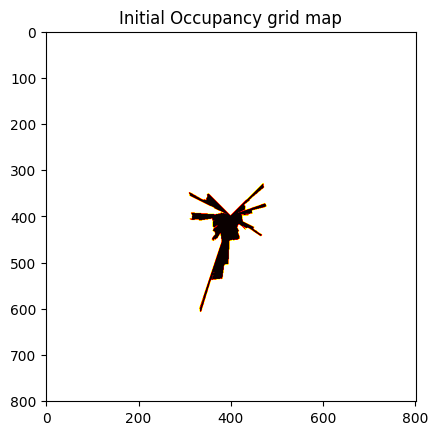

In [50]:

MAP2 = MAP.copy()
print(MAP2['map'])
OMAP2 = OMAP.copy()

state_list1 = np.zeros([4956, 3, N])

N = 10

state, weights = init_particles(N)

max_state = state[:, np.argmax(weights)]
ranges =  data['ranges'][:, 0]
MAP2 = update_map(MAP2,max_state,ranges,angles)
fig2 = plt.figure()
plt.imshow(sigmoid(MAP2['map']), cmap = 'hot');
plt.title("Initial Occupancy grid map")

trajectory_max = np.array([[0],[0]])
state_list1[0] = state

for t in tqdm(range(1,len(encoder_time_stamps))):
    tau = encoder_time_stamps[t] - encoder_time_stamps[t-1]
    w = imu_sync[t-1]
    #print(state_list[t])
    ranges =  data['ranges'][:, t]
    #prediction step
    state = prediction(state_list1[t-1].copy(), tau, v[t-1], w)
    state_list1[t] = state
    
    #update step
    state, weights = update(MAP2,state,weights,ranges,angles,N)

    #find max weighted paritcle 
    particle_max_position = np.argmax(weights)
    particle_max_state = state[:, particle_max_position]
    trajectory_max = np.hstack((trajectory_max,particle_max_state[0:2].reshape(2,1)))

    #Update map based on highest weighted particle
    MAP2 = update_map(MAP2, particle_max_state, ranges, angles)
    #print("state", state_t)
    

(2, 4956)


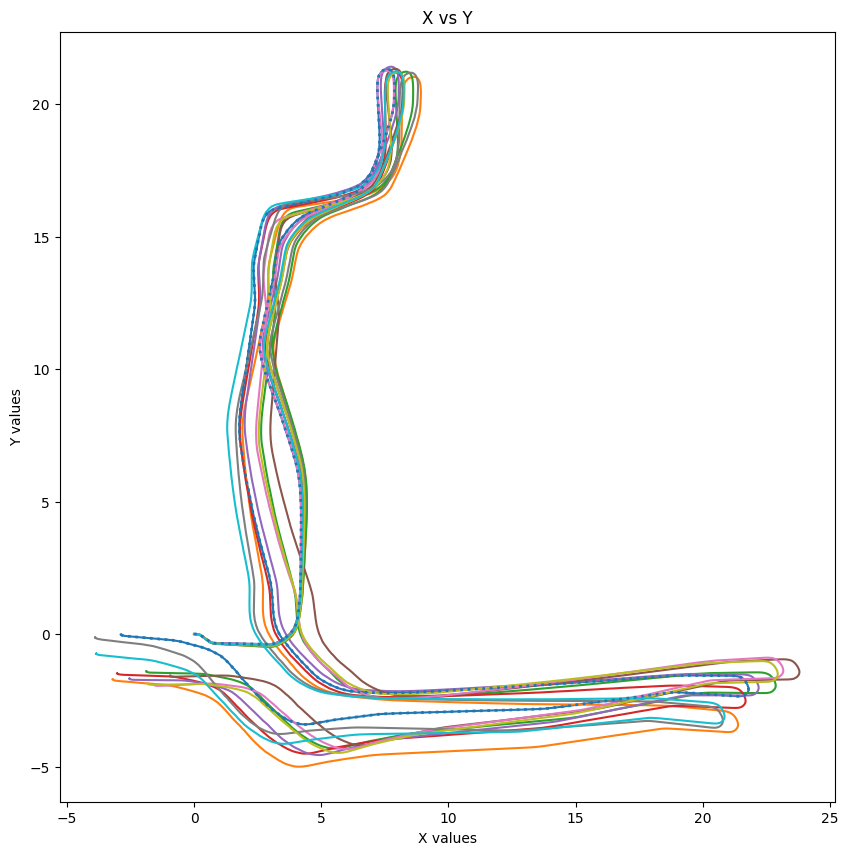

In [55]:
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))
ax2.set_xlabel("X values")
ax2.set_ylabel("Y values")
ax2.set_title("X vs Y")
for p in range(state_list1.shape[2]):
    ax2.plot(state_list1[:, 0, p], state_list1[:, 1, p])

print(trajectory_max.shape)
ax2.plot(trajectory_max[0,:], trajectory_max[1,:], linewidth=2, linestyle='dotted')


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/Disparity20/"
rgb_path = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/RGB20/"

def normalize(img):
  max_ = img.max()
  min_ = img.min()
  return (img - min_)/(max_-min_)

if __name__ == '__main__':

  # load RGBD image
  imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

  print(imc.shape)

  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)

  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd

  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z

  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

  # display valid RGB pixels
  fig = plt.figure(figsize=(10, 13.3))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.view_init(elev=0, azim=180)
  plt.show()

  # display disparity image
  plt.imshow(normalize(imd), cmap='gray')
  plt.show()

[ WARN:0@42.958] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/Disparity20/disparity20_1.png'): can't open/read file: check file path/integrity
[ WARN:0@42.959] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/RGB20/rgb20_1.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable